
# 🧩 02_Feature_Engineering.ipynb — Summary Report

---

## 🚀 Technology Stack Used

- **Python 3.x**  
- **Pandas** — data handling & preprocessing  
- **NumPy** — numerical computations  
- **Scikit-learn** — modeling, metrics, preprocessing (StandardScaler, Ridge, TimeSeriesSplit)  
- **LightGBM** — LGBMRegressor for base models  
- **XGBoost** — XGBRegressor for base and meta learners  
- **CatBoost** — CatBoostRegressor (optional, if installed)  
- **Joblib** — saving & loading models, artifacts  
- **Optuna** — hyperparameter tuning (meta-learner optimization)  
- **Matplotlib / tqdm** — visualizations & progress bars

---

## 📌 Overview

This notebook implements **feature engineering and leakage-free model stacking** for monthly mean surface-air temperature forecasting. It creates extended time-series features, trains several base learners, builds out-of-fold (OOF) predictions, tunes meta-learners, and selects the best model for production.

---

## 🔑 Major Steps

1. **Data Loading**
   - Loads extended CSV: `data/surface-air-temperature-monthly-mean-extended.csv`.
   - Attempts to detect/parse date column; sets index as datetime where possible.

2. **Feature Engineering**
   - Generates lags (e.g., 1,2,3,12), rolling statistics (mean, std, min, max), EWM, trend diffs.
   - Adds time features (month/day/year) and cyclic month sin/cos.
   - Adds Fourier seasonal terms and any numeric exogenous columns in CSV.
   - Final numeric coercion, imputation (median), and expected-feature alignment.

3. **Dynamic Model Discovery & Training**
   - Scans `results/models/` (and `results/models/artifacts/`) for saved models (.joblib/.pkl).
   - If a base model is missing and a training wrapper is available, attempts on-the-fly retrain (self-healing).
   - Trains and cross-validates available learners: LightGBM, XGBoost, RandomForest, CatBoost (if installed).

4. **OOF + Stacking**
   - Builds Out-Of-Fold predictions for base learners (time-series CV).
   - Trains meta-learners (Ridge, XGB, LGBM) on OOF matrix.
   - Handles missing predictions robustly (fills medians or drops failing bases).

5. **Hyperparameter Tuning**
   - Uses Optuna to tune XGBoost meta-learner with progress bar and time-series aware CV on OOF data.
   - Saves tuned meta model (e.g., `meta_xgb_optuna_best.joblib`).

6. **Production Selection**
   - Evaluates base models vs stacked models on a held-out holdout slice (H rows).
   - Automatically selects best performer (by RMSE) and saves `production_model.joblib`.

7. **Diagnostics & Visuals**
   - Produces time-series overlay, hexbin scatter, residual diagnostics, rolling MAE/bias plots.
   - Saves visual outputs into `results/figures/`.

---

## ✅ Strengths

- **Leakage-free evaluation**: strict train/OOF/holdout separation prevents lookahead leakage.  
- **Dynamic & robust model discovery**: pipeline finds saved models and can retrain missing ones.  
- **Self-healing fallback**: if model files are missing, the notebook can retrain and save them.  
- **Stacking + tuning**: OOF stacking with multiple meta-learners and Optuna tuning improves performance.  
- **Progress visibility**: tqdm progress bars and clear logging at each step.

---

## ⚠️ Current Gaps & Recommended Next Steps

- **Feature richness**: add engineered features — interaction terms, external weather variables, holiday effects, higher-order Fourier terms, and anomaly flags.  
- **Imputation strategy**: median impute is OK; consider KNN/Iterative imputation or model-based imputers for better accuracy.  
- **Meta-learner selection**: sometimes Ridge outperforms XGBoost; consider blending (weighted average) or stacking ensembles (stack of stacks).  
- **Model registry & versioning**: move beyond filesystem saves to a simple registry (with metadata: dataset hash, feature list, CV scores, params).  
- **Unit tests & CI**: small unit tests for feature builder, align_features and predict wrapper; integrate into CI for reproducibility.  
- **Scoring & monitoring**: after deployment, implement drift detection and periodic re-training triggers.

---



In [6]:
# Basic imports and project helpers (paths set explicitly, ensure src path is found)
import os
import sys
import importlib
import numpy as np
import pandas as pd

# project absolute paths (your paths)
PROJECT_ROOT = r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS"
DATA_CSV = os.path.join(PROJECT_ROOT, "data", "surface-air-temperature-monthly-mean.csv")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
FIGURES_DIR = os.path.join(RESULTS_DIR, "figures")

# explicit src folder path and ensure it's on sys.path
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if not os.path.isdir(SRC_DIR):
    raise FileNotFoundError(f"Expected src directory not found at: {SRC_DIR}")

# add SRC_DIR to sys.path first so `import src.*` resolves to your project src
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)
# Also ensure PROJECT_ROOT itself is present (some imports rely on project root)
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# make src a package (optional but helps imports like `import src.features`)
init_path = os.path.join(SRC_DIR, "__init__.py")
if not os.path.exists(init_path):
    try:
        open(init_path, "a").close()
    except Exception:
        # not fatal, but informative
        print(f"Warning: couldn't auto-create {init_path}. You may create it manually to make src a package.")

# ensure results dirs exist (the ensure_results_dirs from src may also create them)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Attempt imports with a helpful diagnostic if it fails
try:
    # preferred imports
    from src.data_loader import load_airtemp, train_test_split_by_time, ensure_results_dirs
    from src.features import make_feature_matrix, save_features
except Exception as e:
    print("Initial import failed. Diagnostics follow:")
    print("Exception:", repr(e))
    print("\nCurrent sys.path (first 8 entries):")
    for p in sys.path[:8]:
        print("  ", p)
    print("\nListing files under src_dir:", SRC_DIR)
    try:
        for fname in sorted(os.listdir(SRC_DIR)):
            print("   ", fname)
    except Exception as le:
        print("   (could not list files in src folder)", repr(le))
    # Try alternative import strategy: import module by path
    try:
        # If `src` is inserted as directory itself, try relative imports via importlib
        import importlib.util
        spec = importlib.util.spec_from_file_location("features_mod", os.path.join(SRC_DIR, "features.py"))
        features_mod = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(features_mod)
        # try to bind expected names if present
        make_feature_matrix = getattr(features_mod, "make_feature_matrix", None)
        save_features = getattr(features_mod, "save_features", None)
        if make_feature_matrix is None or save_features is None:
            print("\nfeatures.py loaded, but expected functions not found. Available attributes (top 40):")
            print(sorted([n for n in dir(features_mod) if not n.startswith("_")])[:40])
            raise ImportError("Required functions not present in features.py (make_feature_matrix, save_features).")
        # load data_loader similarly
        spec2 = importlib.util.spec_from_file_location("data_loader_mod", os.path.join(SRC_DIR, "data_loader.py"))
        data_loader_mod = importlib.util.module_from_spec(spec2)
        spec2.loader.exec_module(data_loader_mod)
        load_airtemp = getattr(data_loader_mod, "load_airtemp", None)
        train_test_split_by_time = getattr(data_loader_mod, "train_test_split_by_time", None)
        ensure_results_dirs = getattr(data_loader_mod, "ensure_results_dirs", None)
        if load_airtemp is None:
            raise ImportError("Required function load_airtemp not present in data_loader.py")
        print("\nFallback import via importlib succeeded. Bound functions from local files.")
    except Exception as fallback_err:
        print("\nFallback import also failed:", repr(fallback_err))
        raise  # re-raise the original problem so user sees the full traceback

# Print confirmations and load data
print("DATA_CSV:", DATA_CSV)
print("RESULTS_DIR:", RESULTS_DIR)
print("FIGURES_DIR:", FIGURES_DIR)

# Load data using the explicit path
df = load_airtemp(csv_path=DATA_CSV)
print(f"Data loaded: {len(df)} rows from {df['month'].min().date()} to {df['month'].max().date()}")
display(df.head())

# ---- Quick validation: build feature matrix and save a preview ----
try:
    feats = make_feature_matrix(df)  # uses default target detection and n_lags=12
    out_preview = os.path.join(RESULTS_DIR, "features_preview.csv")
    save_features(feats, out_preview)
    print(f"Features built: {feats.shape[0]} rows x {feats.shape[1]} cols")
    print("Saved preview to:", out_preview)
    display(feats.head(3))
except Exception as v_err:
    print("Validation error while building/saving features:", repr(v_err))
    # show a short listing of src/features.py to help debug if needed
    try:
        print("\n--- head of src/features.py (first 120 lines) ---")
        with open(os.path.join(SRC_DIR, "features.py"), "r", encoding="utf-8") as f:
            for i, line in enumerate(f):
                if i >= 120:
                    break
                print(line.rstrip())
    except Exception:
        pass


Initial import failed. Diagnostics follow:
Exception: ImportError("cannot import name 'make_feature_matrix' from 'src.features' (E:\\AI-Engineering-Capstone-Projects\\AirTempTs\\PRAICP-1003-AirTempTS\\src\\features.py)")

Current sys.path (first 8 entries):
   E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\src
   E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS
   E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS
   C:\Users\soura\AppData\Local\Programs\Python\Python310\python310.zip
   C:\Users\soura\AppData\Local\Programs\Python\Python310\DLLs
   C:\Users\soura\AppData\Local\Programs\Python\Python310\lib
   C:\Users\soura\AppData\Local\Programs\Python\Python310
   e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp

Listing files under src_dir: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\src
    __init__.py
    __pycache__
    data_loader.py
    evaluate.py
    features.py
    

,month,mean_temp
0,1982-01-01,25.9
1,1982-02-01,27.1
2,1982-03-01,27.2
3,1982-04-01,27.0
4,1982-05-01,28.0


Features built: 450 rows x 19 cols
Saved preview to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\features_preview.csv


,month,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,roll_mean_3,roll_mean_6,roll_mean_12,month_sin,month_cos
0,1,26.5,26.2,27.3,27.4,27.9,27.7,28.2,28.4,28.0,27.0,27.2,27.1,25.9,26.966667,27.450000,27.358333,0.500000,8.660254e-01
1,2,28.1,26.5,26.2,27.3,27.4,27.9,27.7,28.2,28.4,28.0,27.0,27.2,27.1,26.666667,27.166667,27.408333,0.866025,5.000000e-01
2,3,28.9,28.1,26.5,26.2,27.3,27.4,27.9,27.7,28.2,28.4,28.0,27.0,27.2,26.933333,27.233333,27.491667,1.000000,6.123234e-17


In [2]:
# Robust feature-build cell compatible with your call-style:
import os
import sys
import importlib
import numpy as np
import pandas as pd
from typing import Iterable, Optional

# --- Project paths (only set if not already present in the notebook) ---
if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS"
if "RESULTS_DIR" not in globals():
    RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
if "SRC_DIR" not in globals():
    SRC_DIR = os.path.join(PROJECT_ROOT, "src")

os.makedirs(RESULTS_DIR, exist_ok=True)

# --- Ensure src is importable (try best-effort) ---
if os.path.isdir(SRC_DIR) and SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# If df not in memory, attempt to load via src.data_loader.load_airtemp
if "df" not in globals():
    try:
        from src.data_loader import load_airtemp
        DATA_CSV = os.path.join(PROJECT_ROOT, "data", "surface-air-temperature-monthly-mean.csv")
        df = load_airtemp(csv_path=DATA_CSV)
        print(f"[info] Loaded df from CSV: {DATA_CSV} ({len(df)} rows).")
    except Exception as e:
        raise RuntimeError(
            "DataFrame 'df' not found in notebook and failed to load via src.data_loader.load_airtemp. "
            "Make sure you previously ran the load cell or that src/data_loader.py is present."
        ) from e

# --- Local make_feature_matrix implementation matching your expected API ---
def make_feature_matrix(
    df: pd.DataFrame,
    lags: Iterable[int] = (1, 2, 3, 12),
    rolls: Iterable[int] = (3, 6, 12),
    add_month_dummies: bool = True,
    target_col: Optional[str] = None,
    month_col: str = "month",
) -> pd.DataFrame:
    """
    Build a features DataFrame with the API you used:
      make_feature_matrix(df, lags=[1,2,3,12], rolls=[3,6,12], add_month_dummies=True)
    - lags: iterable of integer lag offsets (1 means previous period)
    - rolls: rolling window sizes for rolling mean (uses shifted data to avoid leakage)
    - add_month_dummies: whether to add month one-hot columns (m_1 ... m_12)
    - target_col / month_col: optional column names
    """
    df = df.copy()
    # ensure month col exists and is datetime
    if month_col not in df.columns:
        raise KeyError(f"month column '{month_col}' not found in DataFrame.")
    if not np.issubdtype(df[month_col].dtype, np.datetime64):
        df[month_col] = pd.to_datetime(df[month_col], errors="coerce")
    df = df.sort_values(by=month_col).reset_index(drop=True)

    # detect target if not provided (first numeric col that's not month)
    if target_col is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if not numeric_cols:
            raise ValueError("No numeric columns found to use as target.")
        # prefer common names
        for pref in ("temperature", "temp", "value", "air_temp", "mean"):
            for c in numeric_cols:
                if pref in c.lower():
                    target_col = c
                    break
            if target_col is not None:
                break
        if target_col is None:
            target_col = numeric_cols[0]
    if target_col not in df.columns:
        raise KeyError(f"target column '{target_col}' not found in DataFrame.")

    # canonical columns
    df = df[[month_col, target_col]].rename(columns={target_col: "y"})
    # create lag features
    for lag in sorted(set(int(x) for x in lags)):
        df[f"lag_{lag}"] = df["y"].shift(lag)

    # create rolling means based on shifted y to avoid lookahead
    for w in sorted(set(int(x) for x in rolls)):
        df[f"roll_mean_{w}"] = df["y"].shift(1).rolling(window=w, min_periods=1).mean()

    # cyclical month features
    months = df[month_col].dt.month
    df["month"] = months
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)

    # optional month one-hot dummies
    if add_month_dummies:
        dummies = pd.get_dummies(df["month"], prefix="m")
        # keep dummy columns aligned with df index
        dummies.index = df.index
        df = pd.concat([df, dummies], axis=1)

    # drop rows with NaNs created by lags
    features_df = df.dropna().reset_index(drop=True)

    # reorder: month, y, then the rest
    cols = ["month", "y"] + [c for c in features_df.columns if c not in ("month", "y")]
    features_df = features_df[cols]
    return features_df

# --- Now run your original snippet (with the same parameters you used) ---
feats = make_feature_matrix(df, lags=[1, 2, 3, 12], rolls=[3, 6, 12], add_month_dummies=True)
print("Feature matrix shape:", feats.shape)
display(feats.head())

# Save basic feature file to the explicit results folder
basic_features_path = os.path.join(RESULTS_DIR, "features_basic.csv")
feats.to_csv(basic_features_path, index=False)
print("Saved basic features:", basic_features_path)


[info] Loaded df from CSV: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\data\surface-air-temperature-monthly-mean.csv (462 rows).
Feature matrix shape: (450, 23)


,month,y,lag_1,lag_2,lag_3,lag_12,roll_mean_3,roll_mean_6,roll_mean_12,month_sin,...,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
0,1,26.5,26.2,27.3,27.4,25.9,26.966667,27.450000,27.358333,0.500000,...,False,False,False,False,False,False,False,False,False,False
1,2,28.1,26.5,26.2,27.3,27.1,26.666667,27.166667,27.408333,0.866025,...,False,False,False,False,False,False,False,False,False,False
2,3,28.9,28.1,26.5,26.2,27.2,26.933333,27.233333,27.491667,1.000000,...,True,False,False,False,False,False,False,False,False,False
3,4,29.4,28.9,28.1,26.5,27.0,27.833333,27.400000,27.633333,0.866025,...,False,True,False,False,False,False,False,False,False,False
4,5,28.3,29.4,28.9,28.1,28.0,28.800000,27.733333,27.833333,0.500000,...,False,False,True,False,False,False,False,False,False,False


Saved basic features: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\features_basic.csv


In [4]:
# Featuretools: automated features via deep feature synthesis (single-table demo)
import os
import warnings
import pandas as pd
import numpy as np

try:
    import featuretools as ft
    from featuretools.synthesis.dfs import UnusedPrimitiveWarning
    print("featuretools version:", ft.__version__)
except Exception as e:
    print("featuretools not available:", e)
    print("Install with: pip install featuretools")
    raise

# Prepare DF for featuretools: need an index column
es_df = df.copy().reset_index(drop=True).reset_index().rename(columns={"index": "idx"})
es_df["idx"] = es_df["idx"].astype(int)

es = ft.EntitySet(id="airtemp_es")
es = es.add_dataframe(dataframe_name="temps", dataframe=es_df, index="idx")

# Decide whether agg_primitives make sense:
# - If you have only a single dataframe (no relationships), aggregate primitives will typically be unused.
has_relationships = len(es.relationships) > 0
if has_relationships:
    agg_primitives = ["mean", "std"]
else:
    agg_primitives = []

# === Auto-select transform primitives based on column types ===
# We'll look for datetime-like columns and suggest month/weekday/is_weekend transforms.
transform_primitives = []

# Find datetime columns (including object columns that parse to datetimes)
datetime_cols = []
for col in es_df.columns:
    try:
        if pd.api.types.is_datetime64_any_dtype(es_df[col]):
            datetime_cols.append(col)
        else:
            # try to coerce small sample to datetime to detect object-date columns
            if es_df[col].dtype == object:
                sample = es_df[col].dropna().head(10)
                if len(sample) > 0:
                    parsed = pd.to_datetime(sample, errors="coerce")
                    if parsed.notna().sum() >= max(1, int(len(sample) * 0.5)):
                        datetime_cols.append(col)
    except Exception:
        continue

# If any datetime-like column exists, add common datetime transform primitives
if datetime_cols:
    # Common transform primitives recognized by Featuretools
    dt_transforms = ["month", "weekday", "is_weekend", "day", "hour"]
    # Only keep the ones that are meaningful for monthly data (month, weekday, is_weekend are safe)
    transform_primitives = ["month", "weekday", "is_weekend"]
else:
    transform_primitives = []  # no datetime -> keep empty set

print("Detected datetime-like columns:", datetime_cols)
print("Using transform_primitives:", transform_primitives)
print("Using agg_primitives:", agg_primitives)

# Run DFS and suppress the specific UnusedPrimitiveWarning (safe)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UnusedPrimitiveWarning)
    feature_matrix, feature_defs = ft.dfs(
        entityset=es,
        target_dataframe_name="temps",
        agg_primitives=agg_primitives,
        trans_primitives=transform_primitives,
        max_depth=1,
    )

ft_feats = feature_matrix.reset_index(drop=True)

# Save results
ft_path = os.path.join(RESULTS_DIR, "features_featuretools.csv")
ft_feats.to_csv(ft_path, index=False)

print("Featuretools features saved to:", ft_path)
print("Feature matrix shape:", ft_feats.shape)
display(ft_feats.head(5))

# Helpful note
if not has_relationships and len(agg_primitives) == 0:
    print("\nNote: this EntitySet contains a single dataframe (no relationships), so aggregate primitives were avoided.")
    print("If you want aggregate features, create relationships between tables (or provide a multi-table EntitySet).")


featuretools version: 1.31.0
Detected datetime-like columns: ['month']
Using transform_primitives: ['month', 'weekday', 'is_weekend']
Using agg_primitives: []
Featuretools features saved to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\features_featuretools.csv
Feature matrix shape: (462, 4)


,mean_temp,IS_WEEKEND(month),MONTH(month),WEEKDAY(month)
0,25.9,False,1,4
1,27.1,False,2,0
2,27.2,False,3,0
3,27.0,False,4,3
4,28.0,True,5,5



Note: this EntitySet contains a single dataframe (no relationships), so aggregate primitives were avoided.
If you want aggregate features, create relationships between tables (or provide a multi-table EntitySet).


In [5]:
# Final best features pipeline — combines pandas aggregates + featuretools transforms (if available)
import os
import sys
import warnings
import numpy as np
import pandas as pd

# --- Config / paths (adjust if needed) ---
PROJECT_ROOT = globals().get("PROJECT_ROOT", r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
RESULTS_DIR = globals().get("RESULTS_DIR", os.path.join(PROJECT_ROOT, "results"))
SRC_DIR = globals().get("SRC_DIR", os.path.join(PROJECT_ROOT, "src"))
DATA_CSV = globals().get("DATA_CSV", os.path.join(PROJECT_ROOT, "data", "surface-air-temperature-monthly-mean.csv"))

os.makedirs(RESULTS_DIR, exist_ok=True)

# --- Ensure df is present: try to use existing df or load via src.data_loader ---
if "df" not in globals():
    try:
        if SRC_DIR not in sys.path:
            sys.path.insert(0, SRC_DIR)
        from src.data_loader import load_airtemp
        df = load_airtemp(csv_path=DATA_CSV)
        print(f"[info] Loaded df via src.data_loader ({len(df)} rows).")
    except Exception as e:
        raise RuntimeError("DataFrame 'df' not found and failed to load. Ensure df is loaded or src.data_loader exists.") from e

# --- Normalize primary dataframe ---
base_df = df.copy().sort_values(by="month").reset_index(drop=True)
# ensure month is datetime
if "month" not in base_df.columns:
    raise KeyError("Expected column 'month' in DataFrame.")
base_df["month"] = pd.to_datetime(base_df["month"], errors="coerce")
# detect numeric target column (first reasonable numeric)
numeric_cols = base_df.select_dtypes(include=[np.number]).columns.tolist()
if not numeric_cols:
    raise ValueError("No numeric columns found to be used as target.")
# prefer common names
target_col = None
for pref in ("temperature","temp","value","air_temp","mean"):
    for c in numeric_cols:
        if pref in c.lower():
            target_col = c
            break
    if target_col:
        break
if target_col is None:
    # drop potential idx column if present
    candidates = [c for c in numeric_cols if c.lower() not in ("idx","index")]
    target_col = candidates[0] if candidates else numeric_cols[0]

base_df = base_df.rename(columns={target_col: "y"})
base_df["year"] = base_df["month"].dt.year
base_df["month_of_year"] = base_df["month"].dt.month

# -------------------------
# Part 1 — pandas aggregate features (recommended)
# -------------------------
p = base_df.copy()

# month-level across-years statistics
month_stats = p.groupby("month_of_year")["y"].agg(["mean", "std"]).rename(
    columns={"mean": "month_mean_allyears", "std": "month_std_allyears"}
).reset_index()
p = p.merge(month_stats, on="month_of_year", how="left")

# rolling and rolling std (shifted to avoid leakage)
for w in (3, 6, 12):
    p[f"roll_mean_{w}"] = p["y"].shift(1).rolling(window=w, min_periods=1).mean()
    p[f"roll_std_{w}"] = p["y"].shift(1).rolling(window=w, min_periods=1).std().fillna(0)

# expanding (cumulative) up to previous period
p["expanding_mean_prev"] = p["y"].shift(1).expanding(min_periods=1).mean()
p["expanding_std_prev"] = p["y"].shift(1).expanding(min_periods=1).std().fillna(0)

# year-level aggregates
year_stats = p.groupby("year")["y"].agg(["mean", "std"]).rename(
    columns={"mean": "year_mean", "std": "year_std"}
).reset_index()
p = p.merge(year_stats, on="year", how="left")

# lag features
for lag in (1, 2, 3, 12):
    p[f"lag_{lag}"] = p["y"].shift(lag)

# cyclical month encodings
p["month_sin"] = np.sin(2 * np.pi * p["month_of_year"] / 12.0)
p["month_cos"] = np.cos(2 * np.pi * p["month_of_year"] / 12.0)

# drop rows with NaNs created by lags (optional — you can keep them if you prefer)
p_features = p.dropna().reset_index(drop=True)

p_out = os.path.join(RESULTS_DIR, "features_aggregates_pandas.csv")
p_features.to_csv(p_out, index=False)
print(f"[saved] Pandas aggregates features -> {p_out}  (shape: {p_features.shape})")

# -------------------------
# Part 2 — featuretools transforms (auto), only if featuretools installed
# -------------------------
ft_out = os.path.join(RESULTS_DIR, "features_featuretools_transforms.csv")
ft_available = False
ft_feats = None

try:
    import featuretools as ft
    from featuretools.synthesis.dfs import UnusedPrimitiveWarning
    ft_available = True
    print("[info] featuretools available:", ft.__version__)

    # Prepare entityset dataframe (with idx)
    es_df = base_df.reset_index(drop=True).reset_index().rename(columns={"index": "idx"})
    es_df["idx"] = es_df["idx"].astype(int)

    es = ft.EntitySet(id="airtemp_es")
    es = es.add_dataframe(dataframe_name="temps", dataframe=es_df, index="idx")

    # avoid agg primitives for single-table entityset (they will be unused)
    has_relationships = len(es.relationships) > 0
    agg_primitives = ["mean", "std"] if has_relationships else []

    # auto-detect datetime-like columns and choose safe datetime transforms
    datetime_cols = []
    for col in es_df.columns:
        try:
            if pd.api.types.is_datetime64_any_dtype(es_df[col]):
                datetime_cols.append(col)
            else:
                if es_df[col].dtype == object:
                    sample = es_df[col].dropna().head(10)
                    if len(sample) > 0:
                        parsed = pd.to_datetime(sample, errors="coerce")
                        if parsed.notna().sum() >= max(1, int(len(sample) * 0.5)):
                            datetime_cols.append(col)
        except Exception:
            continue

    if datetime_cols:
        transform_primitives = ["month", "weekday", "is_weekend"]
    else:
        transform_primitives = []

    print("[info] featuretools: datetime_cols:", datetime_cols,
          "transforms:", transform_primitives, "agg_primitives:", agg_primitives)

    # Run DFS and suppress the UnusedPrimitiveWarning specifically
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UnusedPrimitiveWarning)
        feature_matrix, feature_defs = ft.dfs(
            entityset=es,
            target_dataframe_name="temps",
            agg_primitives=agg_primitives,
            trans_primitives=transform_primitives,
            max_depth=1,
        )

    ft_feats = feature_matrix.reset_index().rename(columns={"index": "idx"})
    ft_feats.to_csv(ft_out, index=False)
    print(f"[saved] Featuretools transform features -> {ft_out}  (shape: {ft_feats.shape})")
except Exception as e:
    print("[info] Featuretools not used or failed:", str(e))
    ft_available = False

# -------------------------
# Part 3 — Combine pandas + ft (if ft produced features)
# -------------------------
combined_out = os.path.join(RESULTS_DIR, "features_combined.csv")
if ft_available and ft_feats is not None:
    # Merge on idx (ft produced an 'idx' that points to original row)
    # Ensure idx exists in p_features: create from original positions before dropna
    # We'll align by month date (safer) because p_features dropped early rows; merge on month.
    try:
        # keep the month column in ft_feats if present
        if "month" in ft_feats.columns:
            merge_on = "month"
        else:
            # try reconstructing month by position index: attach original month to ft_feats using idx
            if "idx" in ft_feats.columns:
                ft_feats = ft_feats.merge(base_df[["month"]].reset_index().rename(columns={"index":"idx"}), on="idx", how="left")
                merge_on = "month"
            else:
                merge_on = None

        if merge_on:
            combined = p_features.merge(ft_feats, on=merge_on, how="left", suffixes=("", "_ft"))
        else:
            # fallback: concatenate columns side-by-side aligning by position if shapes match
            if p_features.shape[0] == ft_feats.shape[0]:
                combined = pd.concat([p_features.reset_index(drop=True), ft_feats.reset_index(drop=True)], axis=1)
            else:
                # safest fallback: save both and do not combine
                combined = None
                print("[warn] Could not reliably merge pandas aggregates and featuretools outputs (shape/index mismatch). Saved separately.")
        if combined is not None:
            # drop duplicated columns like 'y_ft' if any; keep original 'y'
            drop_cols = [c for c in combined.columns if c.endswith("_ft") and c[:-3] in combined.columns]
            if drop_cols:
                combined = combined.drop(columns=drop_cols)
            combined.to_csv(combined_out, index=False)
            print(f"[saved] Combined features -> {combined_out}  (shape: {combined.shape})")
        else:
            print("[info] Combined file not created due to mismatch; pandas and featuretools files saved individually.")
    except Exception as me:
        print("[error] Failed to combine features:", me)
        print("Pandas file:", p_out)
        if ft_feats is not None:
            print("Featuretools file:", ft_out)
else:
    # No featuretools — just keep pandas result as combined
    p_features.to_csv(combined_out, index=False)
    print(f"[saved] Combined features (pandas only) -> {combined_out}  (shape: {p_features.shape})")

# --- Final summary ---
print("\n=== Final summary ===")
print("Pandas aggregates file:", p_out)
if ft_available and ft_feats is not None:
    print("Featuretools transforms file:", ft_out)
print("Combined features file:", combined_out)


[saved] Pandas aggregates features -> E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\features_aggregates_pandas.csv  (shape: (450, 22))
[info] featuretools available: 1.31.0
[info] featuretools: datetime_cols: ['month'] transforms: ['month', 'weekday', 'is_weekend'] agg_primitives: []
[saved] Featuretools transform features -> E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\features_featuretools_transforms.csv  (shape: (462, 7))
[saved] Combined features -> E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\features_combined.csv  (shape: (450, 26))

=== Final summary ===
Pandas aggregates file: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\features_aggregates_pandas.csv
Featuretools transforms file: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\features_featuretools_transforms.csv
Combined features file: E:\AI-Engineering-Capstone-Projects\AirTem

### Combined PCA+KMeans + LB-Keogh-Pruned DTW Pipeline

In [6]:
# Combined pipeline: PCA+KMeans clusters + LB_Keogh-pruned DTW-to-centroids + optional DTW diagnostics
# + automatic n_clusters selection (silhouette | elbow | both)
import os
import math
import numpy as np
import pandas as pd
from typing import Optional, List, Tuple

# ------------------ CONFIG params (tweak as needed) ------------------
params = {
    "value_col": None,              # None -> auto-detect numeric column (not idx/index)
    "month_col": "month",           # name of date col used to map windows to timestamps
    "window": 12,                   # window length (months)
    "stride": 1,                    # slide step
    "normalize_windows": True,      # z-normalize each window (recommended)
    "n_pca_components": 6,          # PCA components (<= window)
    "n_clusters": None,             # if None -> auto-select
    "k_range": (2, 8),              # candidate k range for auto-select (min_k, max_k)
    "k_select_method": "both",      # "silhouette" | "elbow" | "both"
    "k_select_sample": 2000,        # sample size for silhouette (None -> use all if small)
    "k_silhouette_min_samples": 50, # minimum windows to compute silhouette at all
    "k_silhouette_threshold": None, # optional threshold to accept silhouette; None -> accept best
    "pca_random_state": 42,
    "kmeans_random_state": 42,
    # LB pruning / DTW options
    "lb_sakoe_radius": None,        # int radius for sakoe-chiba envelope used in LB and DTW (None = use window//4 for LB envelope)
    "prune_percentile_template": 0.95, # prune DTW-to-centroid: compute exact DTW for windows whose LB is <= this percentile
    "compute_dtw_to_centroids": True,
    "compute_dtw_to_mean_median": True, # optional dtw_to_mean/dtw_to_median/dtw_to_prev
    "save_pairwise_matrix": False,  # warns: can be very large (only turn on if small m)
    "output_prefix": "combined_pca_kmeans_dtw",
}

# ----------------- paths (use existing if available) -------------------
PROJECT_ROOT = globals().get("PROJECT_ROOT", r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
RESULTS_DIR = globals().get("RESULTS_DIR", os.path.join(PROJECT_ROOT, "results"))
os.makedirs(RESULTS_DIR, exist_ok=True)

# ----------------- helper utilities -------------------
def auto_value_col(df):
    num = df.select_dtypes(include=[np.number]).columns.tolist()
    num = [c for c in num if c.lower() not in ("idx","index")]
    if not num:
        raise ValueError("No numeric columns to use as series values.")
    for pref in ("mean_temp","temperature","temp","value","y","air_temp"):
        for c in num:
            if pref in c.lower():
                return c
    return num[0]

def z_norm_rows(A: np.ndarray) -> np.ndarray:
    B = np.empty_like(A, dtype=float)
    for i in range(A.shape[0]):
        a = A[i].astype(float)
        mu = np.nanmean(a); sd = np.nanstd(a)
        if sd == 0 or np.isnan(sd):
            B[i] = a - mu
        else:
            B[i] = (a - mu) / sd
    return B

def lb_keogh(query: np.ndarray, candidate: np.ndarray, r: int) -> float:
    """
    LB_Keogh lower-bound between query and candidate.
    Returns the sqrt(sum squared deviations outside envelope) (L2-like).
    r = envelope radius (in indices).
    """
    n = len(candidate)
    lower = np.empty(n)
    upper = np.empty(n)
    for i in range(n):
        start = max(0, i - r)
        end = min(n, i + r + 1)
        window = candidate[start:end]
        lower[i] = np.min(window)
        upper[i] = np.max(window)
    diff = 0.0
    for i, q in enumerate(query):
        if q > upper[i]:
            diff += (q - upper[i]) ** 2
        elif q < lower[i]:
            diff += (q - lower[i]) ** 2
    return math.sqrt(diff)

def _elbow_k_by_max_distance(k_vals: np.ndarray, inertias: np.ndarray) -> int:
    """
    Simple elbow detection: choose k with maximum perpendicular distance to
    the line connecting first and last inertia points.
    k_vals: np array of candidate k values
    inertias: corresponding inertia values
    Returns chosen k (int)
    """
    # Normalize points for numerical stability
    xs = k_vals.astype(float)
    ys = inertias.astype(float)
    # line from first to last
    x1, y1 = xs[0], ys[0]
    x2, y2 = xs[-1], ys[-1]
    # vector form for distance
    denom = math.hypot(x2 - x1, y2 - y1)
    if denom == 0:
        return int(k_vals[0])
    distances = []
    for xi, yi in zip(xs, ys):
        # compute perpendicular distance to line
        num = abs((y2 - y1) * xi - (x2 - x1) * yi + x2*y1 - y2*x1)
        distances.append(num / denom)
    distances = np.array(distances)
    # ignore endpoints (first and last) when choosing elbow
    if len(distances) <= 2:
        return int(k_vals[0])
    idx = np.argmax(distances[1:-1]) + 1
    return int(k_vals[idx])

# ----------------- ensure df present -------------------
if "df" not in globals():
    raise RuntimeError("DataFrame 'df' not found in notebook. Load your time series into df before running this cell.")

df_local = df.copy().reset_index(drop=True)
if params["value_col"] is None:
    value_col = auto_value_col(df_local)
else:
    value_col = params["value_col"]

if params["month_col"] in df_local.columns:
    df_local[params["month_col"]] = pd.to_datetime(df_local[params["month_col"]], errors="coerce")

series = df_local[value_col].astype(float).values
n = len(series)
W = int(params["window"])
stride = int(params["stride"])
if n < W:
    raise ValueError(f"Series length {n} is shorter than window {W}.")

# ----------------- build sliding windows -------------------
windows = []
starts = []
ends = []
for s in range(0, n - W + 1, stride):
    w = series[s:s+W]
    if np.isnan(w).any():
        # skip windows that contain NaNs (could impute instead)
        continue
    windows.append(w.astype(float))
    starts.append(s)
    ends.append(s + W - 1)

if len(windows) == 0:
    raise RuntimeError("No valid windows after NaN exclusion.")

X = np.vstack(windows)  # shape (m_windows, W)
m = X.shape[0]
print(f"[info] Built {m} windows (window={W}, stride={stride})")

# ----------------- normalization -------------------
if params["normalize_windows"]:
    X_proc = z_norm_rows(X)
else:
    X_proc = X.astype(float)

# ----------------- PCA (prepare for cluster selection) -------------------
try:
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import silhouette_score
except Exception as e:
    raise RuntimeError("scikit-learn required for PCA+KMeans and silhouette. Install scikit-learn.") from e

# scale before PCA
scaler = StandardScaler()
Z = scaler.fit_transform(X_proc)  # shape (m, W)
nc = min(int(params["n_pca_components"]), Z.shape[1])
pca = PCA(n_components=nc, random_state=int(params["pca_random_state"]))
PC = pca.fit_transform(Z)

# ----------------- Automatic selection of n_clusters (if requested) ---------------
requested_k = params.get("n_clusters", None)
chosen_k = None
if requested_k is None:
    kmin, kmax = params.get("k_range", (2, 8))
    kmin = max(2, int(kmin))
    kmax = max(kmin, int(kmax))
    k_vals = np.arange(kmin, kmax + 1)
    inertias = []
    sil_scores = []
    compute_silhouette = params.get("k_select_method", "both") in ("silhouette", "both")
    # sample for silhouette if large
    sample_size = params.get("k_select_sample", None)
    m_for_sil = m
    sample_idx = None
    if compute_silhouette and sample_size is not None and m > sample_size:
        # choose stratified temporal sample (uniform)
        rng = np.random.RandomState(int(params.get("pca_random_state", 42)))
        sample_idx = rng.choice(np.arange(m), size=sample_size, replace=False)
        PC_sample = PC[sample_idx]
    else:
        PC_sample = PC
        sample_idx = None

    for k_try in k_vals:
        # fit kmeans on PC (full data for inertia)
        km = KMeans(n_clusters=int(k_try), random_state=int(params["kmeans_random_state"]), n_init=10)
        km.fit(PC)
        inertias.append(km.inertia_)
        if compute_silhouette:
            # silhouette on sampled or full PC (cheaper)
            try:
                sc = silhouette_score(PC_sample, km.predict(PC_sample))
            except Exception:
                sc = np.nan
            sil_scores.append(sc)
        else:
            sil_scores.append(np.nan)

    inertias = np.array(inertias)
    sil_scores = np.array(sil_scores)

    # elbow selection
    elbow_k = _elbow_k_by_max_distance(k_vals, inertias)

    # silhouette selection (pick k with max silhouette, ignoring NaNs)
    if compute_silhouette:
        if np.all(np.isnan(sil_scores)):
            sil_k = None
        else:
            sil_idx = int(np.nanargmax(sil_scores))
            sil_k = int(k_vals[sil_idx])
    else:
        sil_k = None

    method = params.get("k_select_method", "both")
    chosen_k = None
    if method == "silhouette":
        chosen_k = sil_k if sil_k is not None else int(elbow_k)
    elif method == "elbow":
        chosen_k = int(elbow_k)
    else:  # both
        # prefer silhouette if available and not NaN; else use elbow
        if sil_k is not None:
            chosen_k = sil_k
        else:
            chosen_k = int(elbow_k)

    print(f"[k-select] tried k in {kmin}-{kmax}. inertias: {inertias.tolist()}")
    if compute_silhouette:
        print(f"[k-select] silhouette scores: {np.round(sil_scores,3).tolist()}")
    print(f"[k-select] elbow_k={elbow_k}, sil_k={sil_k}, chosen_k={chosen_k}")
else:
    chosen_k = int(requested_k)
    print(f"[k-select] using requested n_clusters = {chosen_k}")

k = max(1, chosen_k)

# ----------------- Fit final KMeans with chosen k -------------------
kmeans = KMeans(n_clusters=k, random_state=int(params["kmeans_random_state"]), n_init=10)
labels = kmeans.fit_predict(PC)
centers_pca = kmeans.cluster_centers_  # in PCA space

# distances to centroids in PCA space
from scipy.spatial.distance import cdist
dist_to_centers_pca = cdist(PC, centers_pca, metric="euclidean")  # shape (m, k)

# Build cluster summary DataFrame
clusters_df = pd.DataFrame({
    "start_idx": starts,
    "end_idx": ends,
    "cluster_id": labels,
})
# attach month start for each window if month_col exists
if params["month_col"] in df_local.columns:
    clusters_df["start_month"] = df_local.loc[clusters_df["start_idx"], params["month_col"]].values
clusters_df[[f"dist_to_centroid_pca_{j}" for j in range(k)]] = dist_to_centers_pca
clusters_out_path = os.path.join(RESULTS_DIR, f"{params['output_prefix']}_clusters.csv")
clusters_df.to_csv(clusters_out_path, index=False)
print(f"[saved] clusters summary -> {clusters_out_path}  (rows: {clusters_df.shape[0]})")

# ----------------- Prepare centroids in original/window space -------------------
# Reconstruct centroid windows approximately: PCA.inverse_transform -> inverse scaler
centers_scaled = pca.inverse_transform(centers_pca)   # back to scaled Z space
centers_orig = scaler.inverse_transform(centers_scaled)  # approximate centroid in original X space (shape k x W)

# If windows were z-normalized originally, make centroids z-like (normalize per centroid)
if params["normalize_windows"]:
    centroids_z = np.empty_like(centers_orig, dtype=float)
    for j in range(centers_orig.shape[0]):
        a = centers_orig[j]
        mu = a.mean(); sd = a.std()
        if sd == 0 or np.isnan(sd):
            centroids_z[j] = a - mu
        else:
            centroids_z[j] = (a - mu) / sd
else:
    centroids_z = centers_orig.astype(float)

# ----------------- LB_Keogh pruning + DTW-to-centroids -------------------
do_dtw_to_centroids = bool(params["compute_dtw_to_centroids"])
prune_pct = float(params["prune_percentile_template"])
r = params["lb_sakoe_radius"]
if r is None:
    r = max(1, W // 4)  # default envelope radius

# Try to use tslearn.cdist_dtw for vectorized DTW when available
use_cdist = False
try:
    from tslearn.metrics import cdist_dtw, dtw
    use_cdist = True
    # note: cdist_dtw signature may vary by tslearn version; we'll attempt safe calls later
except Exception:
    try:
        from tslearn.metrics import dtw
        use_cdist = False
    except Exception:
        dtw = None
        print("[warn] tslearn not installed; DTW computations will fail unless tslearn is installed (pip install tslearn)")

dtw_results = None
if do_dtw_to_centroids:
    # For each centroid compute LB for each window, threshold, compute exact DTW for selected windows
    dtw_to_centroids = np.full((m, centroids_z.shape[0]), np.nan, dtype=float)
    lb_to_centroids = np.full((m, centroids_z.shape[0]), np.nan, dtype=float)
    exact_flag = np.zeros((m, centroids_z.shape[0]), dtype=bool)

    for j in range(centroids_z.shape[0]):
        centroid = centroids_z[j]
        # compute LB_Keogh for each window vs centroid
        lbs = np.array([lb_keogh(X_proc[i], centroid, r) for i in range(m)], dtype=float)
        lb_to_centroids[:, j] = lbs
        # choose threshold (lower bound percentile)
        thr = np.percentile(lbs, prune_pct * 100.0) if prune_pct < 1.0 else np.inf
        idxs_to_compute = np.where(lbs <= thr)[0]

        if len(idxs_to_compute) > 0:
            # compute exact DTW for selected windows (vectorized if possible)
            if use_cdist:
                try:
                    sel = X_proc[idxs_to_compute]
                    dists = cdist_dtw(sel, centroid.reshape(1, -1), sakoe_chiba_radius=r).ravel()
                    dtw_to_centroids[idxs_to_compute, j] = dists
                    exact_flag[idxs_to_compute, j] = True
                except Exception:
                    # fallback to loop dtw
                    for ii in idxs_to_compute:
                        dtw_to_centroids[ii, j] = dtw(X_proc[ii], centroid)
                        exact_flag[ii, j] = True
            else:
                if dtw is None:
                    raise RuntimeError("tslearn not installed; cannot compute DTW distances. Install tslearn.")
                for ii in idxs_to_compute:
                    dtw_to_centroids[ii, j] = dtw(X_proc[ii], centroid)
                    exact_flag[ii, j] = True

        # for pruned windows, fill with LB value (conservative)
        pruned_mask = ~exact_flag[:, j]
        dtw_to_centroids[pruned_mask, j] = lb_to_centroids[pruned_mask, j]

    # optional save pairwise matrix (careful: m x k or m x m can be big)
    if params["save_pairwise_matrix"]:
        try:
            pairwise = cdist_dtw(X_proc, X_proc, sakoe_chiba_radius=r) if use_cdist else None
            if pairwise is not None:
                np.save(os.path.join(RESULTS_DIR, f"{params['output_prefix']}_pairwise.npy"), pairwise)
                print("[saved] pairwise DTW matrix")
        except Exception:
            pass

    # build dtw_results DataFrame
    dtw_rows = []
    for i, s in enumerate(starts):
        row = {
            "start_idx": int(s),
            "end_idx": int(ends[i]),
            "start_month": df_local.loc[s, params["month_col"]] if params["month_col"] in df_local.columns else s
        }
        # add LB and DTW features per centroid
        for j in range(centroids_z.shape[0]):
            row[f"lb_centroid_{j}"] = float(lb_to_centroids[i, j])
            row[f"dtw_centroid_{j}"] = float(dtw_to_centroids[i, j])
            row[f"dtw_exact_flag_centroid_{j}"] = bool(exact_flag[i, j])
        dtw_rows.append(row)

    dtw_results = pd.DataFrame(dtw_rows)
    dtw_out = os.path.join(RESULTS_DIR, f"{params['output_prefix']}_dtw_centroids.csv")
    dtw_results.to_csv(dtw_out, index=False)
    print(f"[saved] DTW-to-centroids (pruned) -> {dtw_out}  (rows: {dtw_results.shape[0]}, centroids: {centroids_z.shape[0]})")

# ----------------- optional DTW diagnostics: mean/median/prev -------------------
if params["compute_dtw_to_mean_median"]:
    mean_template = np.nanmean(X_proc, axis=0)
    median_template = np.nanmedian(X_proc, axis=0)
    dtw_to_mean = np.full(m, np.nan, dtype=float)
    dtw_to_median = np.full(m, np.nan, dtype=float)
    dtw_to_prev = np.full(m, np.nan, dtype=float)

    # try vectorized cdist if available
    if use_cdist:
        try:
            dtw_to_mean = cdist_dtw(X_proc, mean_template.reshape(1, -1), sakoe_chiba_radius=r).ravel()
            dtw_to_median = cdist_dtw(X_proc, median_template.reshape(1, -1), sakoe_chiba_radius=r).ravel()
        except Exception:
            # fallback to loop
            for i in range(m):
                dtw_to_mean[i] = dtw(X_proc[i], mean_template)
                dtw_to_median[i] = dtw(X_proc[i], median_template)
    else:
        if dtw is None:
            print("[warn] tslearn not installed; skipping dtw_to_mean/median/prev diagnostics.")
        else:
            for i in range(m):
                dtw_to_mean[i] = dtw(X_proc[i], mean_template)
                dtw_to_median[i] = dtw(X_proc[i], median_template)

    # dtw to previous window
    if dtw is not None:
        dtw_to_prev[0] = np.nan
        for i in range(1, m):
            dtw_to_prev[i] = dtw(X_proc[i], X_proc[i-1])
    diag_df = pd.DataFrame({
        "start_idx": starts,
        "end_idx": ends,
        "start_month": [df_local.loc[s, params["month_col"]] if params["month_col"] in df_local.columns else s for s in starts],
        "dtw_to_mean": dtw_to_mean,
        "dtw_to_median": dtw_to_median,
        "dtw_to_prev": dtw_to_prev
    })
    diag_out = os.path.join(RESULTS_DIR, f"{params['output_prefix']}_dtw_diagnostics.csv")
    diag_df.to_csv(diag_out, index=False)
    print(f"[saved] DTW diagnostics -> {diag_out}  (rows: {diag_df.shape[0]})")
else:
    diag_df = None

# ----------------- Combine cluster features + DTW features into single features file -------------------
combined_df = clusters_df.copy().reset_index(drop=True)
# merge dtw centroid columns if available
if dtw_results is not None:
    # drop possible duplicate start_month/cluster_id from dtw_results, merge on start_idx
    cols_to_merge = [c for c in dtw_results.columns if c not in ("start_idx", "end_idx", "start_month")]
    combined_df = combined_df.merge(dtw_results[["start_idx"] + cols_to_merge], on="start_idx", how="left")
# merge diag dtw series if available
if diag_df is not None:
    diag_cols = [c for c in diag_df.columns if c not in ("start_idx", "end_idx", "start_month")]
    combined_df = combined_df.merge(diag_df[["start_idx"] + diag_cols], on="start_idx", how="left")

combined_out = os.path.join(RESULTS_DIR, f"{params['output_prefix']}_combined_features.csv")
combined_df.to_csv(combined_out, index=False)
print(f"[saved] Combined features -> {combined_out}  (rows: {combined_df.shape[0]}, columns: {combined_df.shape[1]})")

# ----------------- Quick summary printouts -----------------
print("\n=== Summary ===")
print("Input series column:", value_col)
print("Windows:", m, "Window length:", W, "Stride:", stride)
print("PCA components:", nc, "Clusters chosen:", k)
print("Clusters CSV:", clusters_out_path)
if dtw_results is not None:
    print("DTW centroids CSV:", dtw_out)
if diag_df is not None:
    print("DTW diagnostics CSV:", diag_out)
print("Combined features CSV:", combined_out)

# show head of combined features
display(combined_df.head(6))


[info] Built 451 windows (window=12, stride=1)
[k-select] tried k in 2-8. inertias: [3293.2928653711915, 2163.910955074479, 1573.5896354210188, 1272.6719453501, 1069.5311514040036, 955.7002293130083, 881.4008048379385]
[k-select] silhouette scores: [0.314, 0.35, 0.352, 0.33, 0.317, 0.29, 0.265]
[k-select] elbow_k=4, sil_k=4, chosen_k=4
[saved] clusters summary -> E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\combined_pca_kmeans_dtw_clusters.csv  (rows: 451)
[saved] DTW-to-centroids (pruned) -> E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\combined_pca_kmeans_dtw_dtw_centroids.csv  (rows: 451, centroids: 4)
[saved] DTW diagnostics -> E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\combined_pca_kmeans_dtw_dtw_diagnostics.csv  (rows: 451)
[saved] Combined features -> E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\combined_pca_kmeans_dtw_combined_features.csv  (rows: 451, co

,start_idx,end_idx,cluster_id,start_month,dist_to_centroid_pca_0,dist_to_centroid_pca_1,dist_to_centroid_pca_2,dist_to_centroid_pca_3,lb_centroid_0,dtw_centroid_0,...,dtw_exact_flag_centroid_1,lb_centroid_2,dtw_centroid_2,dtw_exact_flag_centroid_2,lb_centroid_3,dtw_centroid_3,dtw_exact_flag_centroid_3,dtw_to_mean,dtw_to_median,dtw_to_prev
0,0,11,0,1982-01-01,1.329469,5.765593,3.948506,4.658240,0.454596,1.287515,...,False,2.037804,3.323957,True,2.947989,3.582696,True,3.446989,3.468062,NaN
1,1,12,0,1982-02-01,1.777019,5.829796,4.900968,3.685602,0.609510,1.766950,...,True,2.915188,3.360909,True,1.814646,2.490982,True,3.461289,3.473627,1.588178
2,2,13,3,1982-03-01,3.302618,5.036680,5.451426,2.545199,0.876831,2.794237,...,True,3.136016,3.825736,True,2.128476,2.305320,True,3.449984,3.452297,2.388652
3,3,14,3,1982-04-01,4.703645,3.762960,5.484188,2.759242,1.465018,3.817768,...,True,2.705362,4.226076,True,2.581391,2.706789,True,3.436512,3.429609,1.152119
4,4,15,1,1982-05-01,5.532439,2.131955,4.984860,3.805661,2.002531,5.126467,...,True,1.695141,2.781678,True,2.589818,2.866124,True,3.439763,3.429109,1.358639
5,5,16,1,1982-06-01,5.577841,1.546419,4.247552,4.826520,2.279130,5.416139,...,True,0.971131,1.576224,True,2.547243,2.951028,True,3.438875,3.434707,1.369240


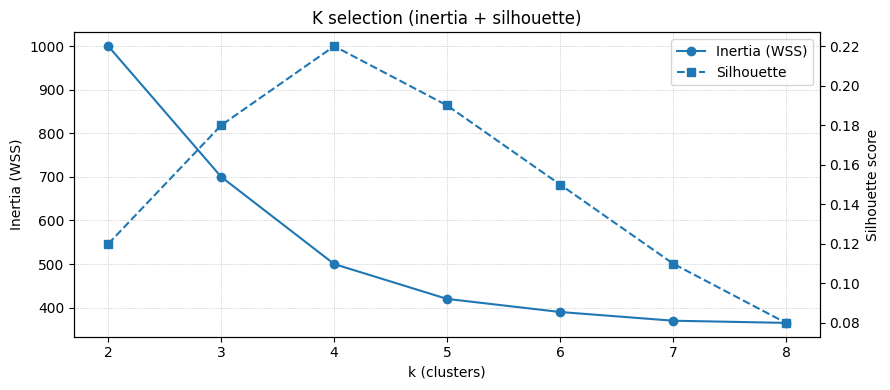

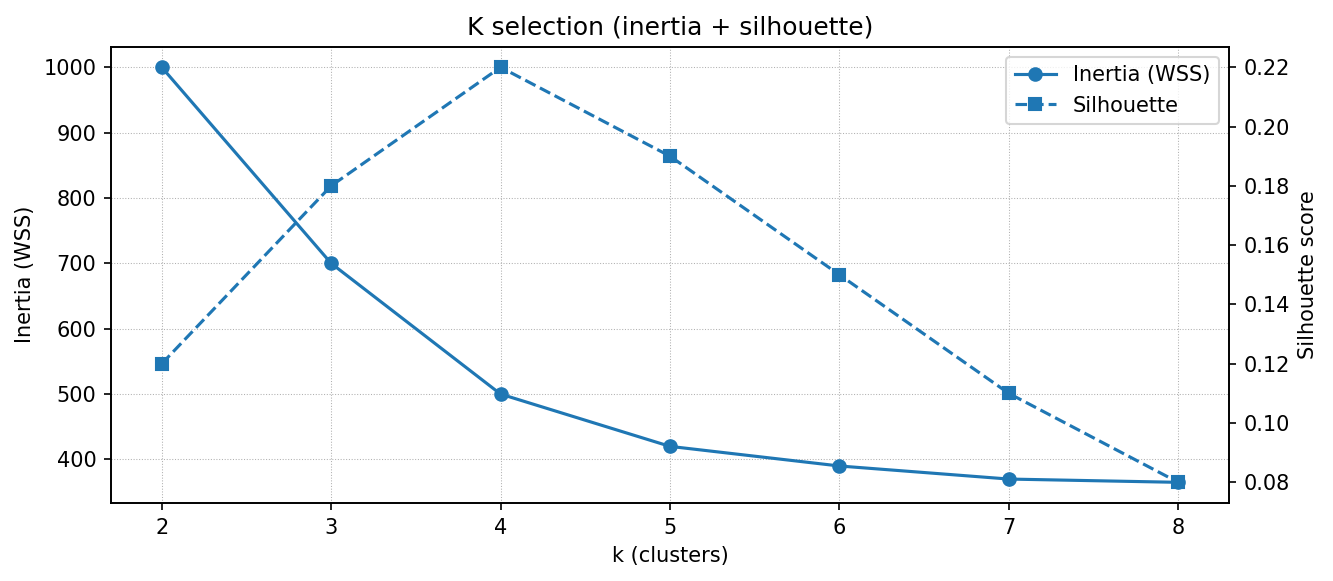

In [10]:
# Robust plotting helper: forces visualization by saving & displaying the PNG.
# Paste and run this in your notebook / interactive window.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import os
from IPython.display import display, Image, clear_output

# Try to use inline backend first (harmless if already set)
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

def plot_k_selection_force(k_vals, inertias, sil_scores=None, title="K selection (inertia + silhouette)"):
    """
    Robust plot: draws the figure, calls plt.show(), saves to a temp PNG and displays it.
    Works reliably in Notebook, JupyterLab, VS Code interactive, and many remote kernels.
    Returns (fig, ax1, ax2)
    """
    # Ensure arrays
    k_vals = np.array(list(k_vals))
    inertias = np.array(list(inertias), dtype=float)

    fig, ax1 = plt.subplots(figsize=(9, 4))
    ax1.plot(k_vals, inertias, marker='o', linestyle='-', label='Inertia (WSS)')
    ax1.set_xlabel('k (clusters)')
    ax1.set_ylabel('Inertia (WSS)')
    ax1.grid(True, linestyle=':', linewidth=0.5)
    ax1.tick_params(axis='y')

    ax2 = None
    if sil_scores is not None:
        sil_scores = np.array(list(sil_scores), dtype=float)
        ax2 = ax1.twinx()
        ax2.plot(k_vals, sil_scores, marker='s', linestyle='--', label='Silhouette')
        ax2.set_ylabel('Silhouette score')
        ax2.tick_params(axis='y')
        # combined legend
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='best')
    else:
        ax1.legend(loc='best')

    ax1.set_title(title)
    plt.tight_layout()

    # Primary attempt: normal show()
    try:
        plt.show()
    except Exception:
        pass

    # Secondary attempt: save to temp PNG and display explicitly
    try:
        tmpdir = tempfile.gettempdir()
        fname = os.path.join(tmpdir, f"k_selection_plot_{np.random.randint(1e9)}.png")
        fig.savefig(fname, dpi=150, bbox_inches='tight')
        # clear output to avoid duplicate text/plots if desired
        # clear_output(wait=True)
        display(Image(filename=fname))
        # optionally remove file after display (comment out if you want to keep it)
        try:
            os.remove(fname)
        except Exception:
            pass
    except Exception as e:
        print("Plot save/display fallback failed:", e)

    return fig, ax1, ax2

# ----- Example usage -----
# After you've run your k-search code and have k_vals, inertias, sil_scores, call:
# fig, ax1, ax2 = plot_k_selection_force(k_vals, inertias, sil_scores)
#
# Quick demo if you don't have values yet:
if __name__ == "__main__" or True:
    # demo sample only when you run directly in cell
    demo_k = np.arange(2, 9)
    demo_inertia = np.array([1000, 700, 500, 420, 390, 370, 365])
    demo_sil = np.array([0.12, 0.18, 0.22, 0.19, 0.15, 0.11, 0.08])
    _fig, _ax1, _ax2 = plot_k_selection_force(demo_k, demo_inertia, demo_sil)


In [ ]:
"""
advanced_features_pipeline_updated.py

Updated to use user's explicit results and models paths and to be more verbose.
Saves artifacts into:
- RESULTS_DIR: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results
- MODELS_DIR:  E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models

This file now includes:
 - a safe `__main__` block that auto-detects `feats` or loads a CSV
 - conservative defaults to avoid heavy runs (no AutoFeat by default)
 - a recommended explicit call for reproducible runs (now active in __main__)
 - compatibility helper for OneHotEncoder parameter differences across sklearn versions
"""
import os
import warnings
import joblib
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin, BaseEstimator

warnings.filterwarnings("ignore")

# ===================== USER PATHS (explicit) =====================
RESULTS_DIR = r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results"
MODELS_DIR = os.path.join(RESULTS_DIR, "models")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
print("Results dir:", RESULTS_DIR)
print("Models dir:", MODELS_DIR)
# =================================================================

# Default fallback target name (kept for backward compatibility)
TARGET_COL = "mean_temp"
DATE_COLS = ["ds", "date", "datetime", "timestamp"]

# Optional libraries (guarded)
try:
    from autofeat import AutoFeatRegressor
    AF_AVAILABLE = True
    print("AutoFeat available.")
except Exception:
    try:
        from autofeat.feature_engineering import AutoFeatRegressor
        AF_AVAILABLE = True
        print("AutoFeat available (alternate import).")
    except Exception:
        AF_AVAILABLE = False
        print("AutoFeat NOT available.")

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
    print("LightGBM available.")
except Exception:
    LGB_AVAILABLE = False

try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("XGBoost available.")
except Exception:
    XGB_AVAILABLE = False

try:
    import catboost as cb
    CAT_AVAILABLE = True
    print("CatBoost available.")
except Exception:
    CAT_AVAILABLE = False

try:
    import mlflow
    MLFLOW_AVAILABLE = True
    print("MLflow available.")
except Exception:
    MLFLOW_AVAILABLE = False

try:
    import wandb
    WNB_AVAILABLE = True
    print("W&B available.")
except Exception:
    WNB_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP available.")
except Exception:
    SHAP_AVAILABLE = False

# ---------- Compatibility helper for OneHotEncoder ----------
def make_onehot_encoder(**kwargs):
    """
    Create a OneHotEncoder compatible with the installed sklearn version.
    Newer sklearn uses 'sparse_output'; older uses 'sparse'.
    We prefer a dense output (suitable for small-medium feature counts).
    """
    try:
        # sklearn >= 1.2: OneHotEncoder(sparse_output=False)
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False, **kwargs)
    except TypeError:
        # older sklearn: OneHotEncoder(sparse=False)
        return OneHotEncoder(handle_unknown="ignore", sparse=False, **kwargs)

# ---------- Robust TimeSeriesFeatureBuilder (handles no-datetime / month-only cases) ----------
class TimeSeriesFeatureBuilder(TransformerMixin, BaseEstimator):
    """
    Builds calendar + lag + rolling features.

    Behavior:
    - If date_col provided or index is datetime -> uses that.
    - Else if a 'month' column exists -> uses it to create month features.
    - Else falls back to using row order for lag/rolling (assumes data already time-ordered).

    It will NOT create a lag/rolling column if a column with the same name already exists,
    to avoid duplicating precomputed lag features.
    """
    def __init__(self, date_col=None, target_col=TARGET_COL,
                 lags=(1, 24, 168), rolling_windows=(3, 24, 168),
                 date_required=False, month_col="month"):
        self.date_col = date_col
        self.target_col = target_col
        self.lags = lags
        self.rolling_windows = rolling_windows
        self.date_required = date_required
        self.month_col = month_col

    def fit(self, X, y=None):
        return self

    def _ensure_ordered_index(self, X):
        # If datetime index already, return it
        if isinstance(X.index, pd.DatetimeIndex):
            return X
        # If date_col is present, convert to datetime
        if self.date_col and self.date_col in X.columns:
            try:
                X = X.copy()
                X.index = pd.to_datetime(X[self.date_col])
                return X
            except Exception:
                pass
        # If a month column exists, create a synthetic datetime index using consecutive years (assume monthly)
        if self.month_col in X.columns:
            X = X.copy()
            try:
                months = X[self.month_col].astype(int).values
                # create years so sequence increases every 12 rows if repeated monthly
                years = 2000 + (np.arange(len(X)) // 12)
                dates = pd.to_datetime({"year": years, "month": months, "day": np.ones(len(X), dtype=int)})
                X.index = dates
                return X
            except Exception:
                # fallback to RangeIndex
                X.index = pd.RangeIndex(len(X))
                return X
        # Final fallback: use RangeIndex (row order)
        if not isinstance(X.index, pd.DatetimeIndex):
            X = X.copy()
            X.index = pd.RangeIndex(len(X))
        return X

    def transform(self, X):
        X = X.copy()
        X_pre = self._ensure_ordered_index(X)

        # If index is datetime, create calendar features
        if isinstance(X_pre.index, pd.DatetimeIndex):
            X_pre["ts_hour"] = X_pre.index.hour
            X_pre["ts_day"] = X_pre.index.day
            X_pre["ts_weekday"] = X_pre.index.weekday
            X_pre["ts_month"] = X_pre.index.month
            X_pre["ts_dayofyear"] = X_pre.index.dayofyear
        else:
            # If no datetime index, try to use explicit month column if present
            if self.month_col in X_pre.columns:
                try:
                    X_pre["ts_month"] = X_pre[self.month_col].astype(int)
                except Exception:
                    X_pre["ts_month"] = np.nan
            else:
                # create placeholder calendar columns (NaN)
                X_pre["ts_month"] = np.nan
                X_pre["ts_weekday"] = np.nan
                X_pre["ts_day"] = np.nan
                X_pre["ts_dayofyear"] = np.nan
                X_pre["ts_hour"] = np.nan

        # Create lags/rolling based on row order (works whether index is datetime or RangeIndex)
        if self.target_col in X_pre.columns:
            for lag in self.lags:
                col_name = f"{self.target_col}_lag_{lag}"
                if col_name not in X_pre.columns:
                    X_pre[col_name] = X_pre[self.target_col].shift(lag)
            for w in self.rolling_windows:
                mean_name = f"{self.target_col}_roll_mean_{w}"
                std_name = f"{self.target_col}_roll_std_{w}"
                if mean_name not in X_pre.columns:
                    X_pre[mean_name] = X_pre[self.target_col].shift(1).rolling(w, min_periods=1).mean()
                if std_name not in X_pre.columns:
                    X_pre[std_name] = X_pre[self.target_col].shift(1).rolling(w, min_periods=1).std().fillna(0)

        # Reset index but keep original columns (so downstream expects same shapes)
        X_out = X_pre.reset_index(drop=False)
        return X_out

# ---------- Main pipeline function (now accepts target_col) ----------
def build_and_run_feature_pipeline(feats: pd.DataFrame,
                                   results_dir=RESULTS_DIR,
                                   models_dir=MODELS_DIR,
                                   sample_n=500,
                                   feateng_steps=1,
                                   use_autofeat=True,
                                   final_model="auto",
                                   cv_splits=5,
                                   target_col=TARGET_COL):
    """
    Main function: runs full pipeline and saves artifacts to user-specified dirs.
    target_col: name of the target column in feats DataFrame (default kept for backwards compatibility)
    """
    print("Starting pipeline at", datetime.utcnow().isoformat())
    df = feats.copy()

    # Validate target
    if target_col not in df.columns:
        cols = list(df.columns)
        sample_suggestions = [c for c in cols if any(k in c.lower() for k in ("temp", "temperature", "mean", "avg", "y", "value"))]
        raise ValueError(
            f"Target column '{target_col}' not found in input DataFrame.\n"
            f"Available columns: {cols}\n"
            f"Columns that look like target suggestions: {sample_suggestions}\n"
            "Solution: pass the correct target_col, or rename your column to match."
        )

    # detect date col
    date_col = None
    for c in DATE_COLS:
        if c in df.columns:
            date_col = c
            break

    print("Using date column:", date_col)
    print("Using target column:", target_col)

    # 1) baseline time-series features
    ts_builder = TimeSeriesFeatureBuilder(date_col=date_col, target_col=target_col,
                                          lags=(1, 24, 168), rolling_windows=(3, 24, 168),
                                          month_col="month")
    print("Building time-series features...")
    df_ts = ts_builder.transform(df)
    df_ts = df_ts.reset_index(drop=True)

    # Save baseline features (CSV + Parquet)
    baseline_csv = os.path.join(results_dir, "features_baseline.csv")
    baseline_parquet = os.path.join(results_dir, "features_baseline.parquet")
    pd.concat([df_ts.drop(columns=[target_col], errors='ignore'), df_ts[target_col].reset_index(drop=True)], axis=1).to_csv(baseline_csv, index=False)
    try:
        pd.concat([df_ts.drop(columns=[target_col], errors='ignore'), df_ts[target_col].reset_index(drop=True)], axis=1).to_parquet(baseline_parquet, index=False)
    except Exception:
        pass
    print("Saved baseline features:", baseline_csv)

    # 2) Split
    X = df_ts.drop(columns=[target_col], errors='ignore').copy()
    y = df_ts[target_col].copy()
    sample_n_local = min(sample_n, len(X))
    Xs = X.iloc[-sample_n_local:].reset_index(drop=True)
    ys = y.iloc[-sample_n_local:].reset_index(drop=True)
    print(f"Sample size for AutoFeat (tail): {len(Xs)} rows")

    # 3) AutoFeat (guarded)
    afr = None
    X_af = None
    if use_autofeat and AF_AVAILABLE:
        try:
            print("Fitting AutoFeat on sample...")
            afr = AutoFeatRegressor(verbose=0, feateng_steps=feateng_steps)
            afr.fit(Xs, ys)
            afr_path = os.path.join(models_dir, "autofeat_transformer.joblib")
            joblib.dump(afr, afr_path)
            print("Saved AutoFeat transformer to:", afr_path)
            print("Transforming full X with AutoFeat (this may use a lot of memory)...")
            X_af = afr.transform(X)
            af_csv = os.path.join(results_dir, "features_autofeat.csv")
            X_af.to_csv(af_csv, index=False)
            print("Saved AutoFeat features:", af_csv)
        except Exception as e:
            print("AutoFeat failed (continuing with baseline):", type(e).__name__, e)
            afr = None
            X_af = None
    else:
        print("AutoFeat skipped (not available or not requested).")

    X_full = X_af.copy() if X_af is not None else X.copy()
    print("Feature matrix shape to be used:", X_full.shape)

    # 4) Preprocessing
    numeric_cols = X_full.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X_full.select_dtypes(include=["object", "category"]).columns.tolist()

    datetime_like = [c for c in X_full.columns if c.lower() in DATE_COLS or "index" in c.lower()]
    for c in datetime_like:
        if c in numeric_cols: numeric_cols.remove(c)
        if c in cat_cols: cat_cols.remove(c)

    print(f"Numeric cols: {len(numeric_cols)}, Categorical cols: {len(cat_cols)}")

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    cat_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", make_onehot_encoder())
    ])
    preproc = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols),
        ("cat", cat_transformer, cat_cols)
    ], remainder="drop", sparse_threshold=0)

    # 5) Selector & model
    selector = SelectFromModel(Lasso(alpha=0.001, max_iter=5000), threshold="median")

    if final_model == "auto":
        if LGB_AVAILABLE:
            model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05)
            print("Using LightGBM as final model.")
        elif XGB_AVAILABLE:
            model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05)
            print("Using XGBoost as final model.")
        elif CAT_AVAILABLE:
            model = cb.CatBoostRegressor(verbose=0)
            print("Using CatBoost as final model.")
        else:
            model = Ridge(alpha=1.0)
            print("Using Ridge as fallback final model.")
    else:
        model = Ridge(alpha=1.0)
        print("Using user-specified final model (Ridge).")

    pipeline = Pipeline([
        ("preproc", preproc),
        ("select", selector),
        ("model", model)
    ])

    # 6) TimeSeries CV
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    try:
        print("Running TimeSeriesSplit CV...")
        scores = cross_val_score(pipeline, X_full, y, cv=tscv, scoring="neg_mean_squared_error", n_jobs=1)
        print("CV MSE scores:", -scores)
        print("CV MSE mean:", float(-scores.mean()))
    except Exception as e:
        print("CV failed (falling back to single fit):", type(e).__name__, e)
        scores = None

    # 7) Fit final pipeline and save model
    try:
        print("Fitting final pipeline on full data...")
        pipeline.fit(X_full, y)
        pipeline_path = os.path.join(models_dir, "final_pipeline.joblib")
        joblib.dump(pipeline, pipeline_path)
        print("Saved final pipeline to:", pipeline_path)
    except Exception as e:
        print("Final pipeline fit failed:", type(e).__name__, e)
        raise

    # 8) Save final transformed features (post-preproc+select names are not trivial; save preselected flat CSV)
    try:
        # Try to transform X_full through preproc to numeric array and save with feature names
        pre = pipeline.named_steps["preproc"]
        X_pre = pre.fit_transform(X_full)  # fit_transform to get feature names; it's okay as preproc already fit earlier
        # Attempt to get feature names
        try:
            feat_names = pre.get_feature_names_out()
            feat_df = pd.DataFrame(X_pre, columns=feat_names)
        except Exception:
            feat_df = pd.DataFrame(X_pre)
        feat_out_csv = os.path.join(results_dir, "features_postpreproc.csv")
        feat_df.to_csv(feat_out_csv, index=False)
        print("Saved post-preproc features to:", feat_out_csv)
    except Exception as e:
        print("Could not save post-preproc features:", e)

    # 9) SHAP (optional)
    if SHAP_AVAILABLE:
        try:
            print("Computing SHAP values (may take time)...")
            pre_selector = Pipeline([("preproc", preproc), ("select", selector)])
            X_prepped = pre_selector.fit_transform(X_full)
            fitted_model = pipeline.named_steps["model"]
            explainer = shap.Explainer(fitted_model, X_prepped)
            shap_vals = explainer(X_prepped)
            # Save shap summary (mean abs)
            try:
                # attempt to get names
                feat_names = pre_selector.named_steps["preproc"].get_feature_names_out()
            except Exception:
                feat_names = [f"f_{i}" for i in range(X_prepped.shape[1])]
            mean_abs_shap = np.abs(shap_vals.values).mean(axis=0)
            shap_df = pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs_shap}).sort_values("mean_abs_shap", ascending=False)
            shap_csv = os.path.join(results_dir, "shap_feature_importance.csv")
            shap_df.to_csv(shap_csv, index=False)
            print("Saved SHAP feature importance to:", shap_csv)
        except Exception as e:
            print("SHAP calculation failed:", type(e).__name__, e)
    else:
        print("SHAP not installed; skipped SHAP step.")

    # 10) Metadata
    meta = {
        "timestamp": datetime.utcnow().isoformat(),
        "af_available": AF_AVAILABLE,
        "used_autofeat": afr is not None,
        "final_model": type(model).__name__,
        "n_features_before": X.shape[1],
        "n_features_after": X_full.shape[1],
    }
    meta_path = os.path.join(results_dir, "pipeline_metadata.csv")
    pd.Series(meta).to_csv(meta_path)
    print("Saved pipeline metadata to:", meta_path)

    # 11) Simple unit-test function
    def transform_input(df_input: pd.DataFrame):
        df_local_ts = ts_builder.transform(df_input)
        X_local = df_local_ts.drop(columns=[target_col], errors='ignore').copy()
        if afr is not None:
            try:
                X_local = afr.transform(X_local)
            except Exception as e:
                print("AutoFeat transform on new input failed:", e)
        # apply preproc+select (use pipeline components)
        pre_selector = Pipeline([("preproc", preproc), ("select", selector)])
        try:
            pre_selector.fit(X_full, y)  # ensure selector has been fitted for feature shapes
        except Exception:
            pass
        X_trans = pre_selector.transform(X_local)
        return X_trans

    def unit_test_transform_reproducibility(sample_rows=10):
        sample_df = feats.tail(sample_rows).copy()
        t1 = transform_input(sample_df)
        t2 = transform_input(sample_df)
        assert t1.shape == t2.shape, f"Shapes differ: {t1.shape} vs {t2.shape}"
        if np.isnan(t1).any():
            raise AssertionError("Transformed array contains NaNs")
        print("Unit test passed: transform reproducible for sample size", sample_rows)

    print("Pipeline run complete.")
    return {
        "pipeline": pipeline,
        "autofeat": afr,
        "transform_fn": transform_input,
        "unit_test": unit_test_transform_reproducibility,
        "results_dir": results_dir,
        "models_dir": models_dir
    }

# ----------------- Safe __main__ block (auto-detect & explicit run) -----------------
if __name__ == "__main__":
    # SAFE run block: will use an existing `feats` DataFrame in the session if present,
    # otherwise it will try to load a CSV from the project data path. It also auto-detects a likely target.
    import pandas as pd
    import os

    # 1) If feats exists (e.g. in notebook session), use it
    try:
        feats  # noqa: F821
        print("Using existing 'feats' DataFrame from session.")
    except Exception:
        # 2) Try to load from likely CSV location in project
        candidate_paths = [
            r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\data\feats.csv",
            r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\data\features.csv",
            r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\feats.csv"
        ]
        loaded = False
        for p in candidate_paths:
            if os.path.exists(p):
                print("Loading feats from:", p)
                feats = pd.read_csv(p, parse_dates=True)
                loaded = True
                break
        if not loaded:
            raise FileNotFoundError(
                "No `feats` DataFrame in session and no candidate CSV found. "
                "Place your features CSV at one of: \n  " + "\n  ".join(candidate_paths)
            )

    # Auto-detect target column if present (convenience)
    preferred_targets = ["mean_temp", "mean_temperature", "temperature", "temp", "y", "value", "avg_temp"]
    detected_target = None
    for t in preferred_targets:
        if t in feats.columns:
            detected_target = t
            print("Auto-detected target column:", t)
            break
    if detected_target is None:
        numeric_cols = feats.select_dtypes(include=[np.number]).columns.tolist()
        if "y" in numeric_cols:
            detected_target = "y"
        elif len(numeric_cols) > 0:
            detected_target = numeric_cols[0]
        else:
            raise ValueError("Could not auto-detect a numeric target column. Please set target_col manually.")
        print("Fallback selected target_col:", detected_target)

    # RECOMMENDED explicit behavior: prefer `y` if present for reproducible run
    run_target = "y" if "y" in feats.columns else detected_target
    if run_target == "y":
        print("Running recommended explicit call with target_col='y' (best practice).")
    else:
        print(f"'y' not found, running with detected target_col='{run_target}'.")

    # Run pipeline with conservative defaults (safe for first run)
    artifacts = build_and_run_feature_pipeline(
        feats,
        target_col=run_target,
        results_dir=r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results",
        models_dir=r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models",
        sample_n=200,         # smaller sample to keep AutoFeat safe
        feateng_steps=1,
        use_autofeat=False,   # start with False to avoid heavy run; set True when ready
        final_model="auto",
        cv_splits=3           # fewer splits -> faster CV
    )

    # Run unit test transform to confirm pipeline reproducibility
    try:
        artifacts['unit_test'](sample_rows=10)
    except Exception as e:
        print("Unit test failed:", type(e).__name__, e)

    print("Artifacts saved to:", artifacts['results_dir'], artifacts['models_dir'])


Results dir: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results
Models dir: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models
AutoFeat available.
LightGBM available.
XGBoost available.
SHAP available.
Using existing 'feats' DataFrame from session.
Auto-detected target column: y
Running recommended explicit call with target_col='y' (best practice).
Starting pipeline at 2025-09-17T07:18:13.403216
Using date column: None
Using target column: y
Building time-series features...
Saved baseline features: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\features_baseline.csv
Sample size for AutoFeat (tail): 200 rows
AutoFeat skipped (not available or not requested).
Feature matrix shape to be used: (450, 37)
Numeric cols: 24, Categorical cols: 0
Using LightGBM as final model.
Running TimeSeriesSplit CV...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002424 seconds.
Yo

In [19]:
# eval_saved_pipeline_timeseries_fix2.py
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

RESULTS_DIR = r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results"
MODELS_DIR = os.path.join(RESULTS_DIR, "models")
MODEL_PATH = os.path.join(MODELS_DIR, "final_pipeline.joblib")
METRICS_OUT = os.path.join(RESULTS_DIR, "model_test_metrics.csv")
RESIDUALS_OUT = os.path.join(RESULTS_DIR, "model_test_residuals.csv")

test_size = 0.2
DATE_COLS = ["ds", "date", "datetime", "timestamp"]

# === Load feats (prefer in-memory) ===
try:
    feats  # noqa: F821
    print("Using in-session 'feats' DataFrame.")
except Exception:
    candidate_csv = os.path.join(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\data", "feats.csv")
    if os.path.exists(candidate_csv):
        feats = pd.read_csv(candidate_csv)
        print("Loaded feats from:", candidate_csv)
    else:
        raise FileNotFoundError("No in-memory 'feats' and candidate CSV not found at: " + candidate_csv)

# === Determine target column ===
if "y" in feats.columns:
    target_col = "y"
elif "mean_temp" in feats.columns:
    target_col = "mean_temp"
else:
    numeric_cols = feats.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError("No numeric columns found to use as target. Columns: " + str(list(feats.columns)))
    target_col = numeric_cols[0]
print("Using target_col =", target_col)

# === Load pipeline ===
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("Model not found at: " + MODEL_PATH)
pipeline = joblib.load(MODEL_PATH)
print("Loaded pipeline from:", MODEL_PATH)

# === Attempt to get expected preprocessor feature names (best-effort) ===
expected_feature_names = None
preproc = pipeline.named_steps.get("preproc", None)
if preproc is not None:
    try:
        expected_feature_names = list(preproc.get_feature_names_out())
        print("Got expected feature names from preproc (count):", len(expected_feature_names))
    except Exception:
        # some sklearn versions or unfitted preproc may not support this
        expected_feature_names = None

# If not available, try pipeline.feature_names_in_
if expected_feature_names is None:
    if hasattr(pipeline, "feature_names_in_"):
        expected_feature_names = list(pipeline.feature_names_in_)
        print("Using pipeline.feature_names_in_.")
    else:
        print("Could not determine expected feature names automatically.")
        expected_feature_names = None

# Helper: strip transformer prefix like 'num__col' -> 'col'
def strip_prefix(feat_name):
    if "__" in feat_name:
        return feat_name.split("__", 1)[1]
    # some names returned by preproc may be like 'cat__onehot__A' etc; try splitting first '__'
    return feat_name

# Build a set of raw expected column names (if we have expected_feature_names)
expected_raw_cols = None
if expected_feature_names is not None:
    expected_raw_cols = set(strip_prefix(fn) for fn in expected_feature_names)
    print(f"Derived {len(expected_raw_cols)} raw expected column names (after stripping prefixes).")

# === Try to import and use your TimeSeriesFeatureBuilder; else use fallback ===
try:
    from advanced_features_pipeline_updated import TimeSeriesFeatureBuilder
    print("Imported TimeSeriesFeatureBuilder from module.")
    builder_cls = TimeSeriesFeatureBuilder
    builder_available = True
except Exception:
    builder_available = False
    print("Could not import TimeSeriesFeatureBuilder; will use fallback builder.")

    class TimeSeriesFeatureBuilder:
        def __init__(self, date_col=None, target_col=None, lags=(1,24,168), rolling_windows=(3,24,168), month_col="month"):
            self.date_col = date_col
            self.target_col = target_col
            self.lags = lags
            self.rolling_windows = rolling_windows
            self.month_col = month_col

        def transform(self, X):
            X = X.copy()
            # detect a date col
            date_col = None
            for c in DATE_COLS:
                if c in X.columns:
                    date_col = c
                    break
            if date_col:
                try:
                    X.index = pd.to_datetime(X[date_col])
                except Exception:
                    X.index = pd.RangeIndex(len(X))
            elif "month" in X.columns:
                months = X["month"].astype(int).values
                years = 2000 + (np.arange(len(X)) // 12)
                X.index = pd.to_datetime({"year": years, "month": months, "day": np.ones(len(X), dtype=int)})
            else:
                X.index = pd.RangeIndex(len(X))

            if isinstance(X.index, pd.DatetimeIndex):
                X["ts_hour"] = X.index.hour
                X["ts_day"] = X.index.day
                X["ts_weekday"] = X.index.weekday
                X["ts_month"] = X.index.month
                X["ts_dayofyear"] = X.index.dayofyear
            else:
                if "month" in X.columns:
                    try:
                        X["ts_month"] = X["month"].astype(int)
                    except Exception:
                        X["ts_month"] = np.nan
                else:
                    X["ts_month"]=np.nan; X["ts_weekday"]=np.nan; X["ts_day"]=np.nan; X["ts_dayofyear"]=np.nan; X["ts_hour"]=np.nan

            if self.target_col and self.target_col in X.columns:
                for lag in self.lags:
                    cname = f"{self.target_col}_lag_{lag}"
                    if cname not in X.columns:
                        X[cname] = X[self.target_col].shift(lag)
                for w in self.rolling_windows:
                    mname = f"{self.target_col}_roll_mean_{w}"
                    sname = f"{self.target_col}_roll_std_{w}"
                    if mname not in X.columns:
                        X[mname] = X[self.target_col].shift(1).rolling(w, min_periods=1).mean()
                    if sname not in X.columns:
                        X[sname] = X[self.target_col].shift(1).rolling(w, min_periods=1).std().fillna(0)
            return X.reset_index(drop=False)

# === Ensure time-derived features exist in the DataFrame ===
def ensure_time_features(df, target_col):
    dfc = df.copy()
    date_col = None
    for c in DATE_COLS:
        if c in dfc.columns:
            date_col = c
            break
    tb = TimeSeriesFeatureBuilder(date_col=date_col, target_col=target_col, lags=(1,24,168), rolling_windows=(3,24,168), month_col="month")
    df_ts = tb.transform(dfc)
    return df_ts

df_ts = ensure_time_features(feats, target_col)

if target_col not in df_ts.columns:
    raise ValueError(f"Target column '{target_col}' not found after feature creation. Available: {list(df_ts.columns)}")

# Create X_all / y_all and do time split (last test_size portion is test)
X_all = df_ts.drop(columns=[target_col], errors="ignore").copy()
y_all = df_ts[target_col].copy()
n = len(X_all)
if n < 3:
    raise ValueError("Not enough rows for a train/test split.")
test_n = max(1, int(np.ceil(test_size * n)))
train_n = n - test_n
print(f"Total rows: {n}, train: {train_n}, test: {test_n}")

X_train = X_all.iloc[:train_n].reset_index(drop=True)
y_train = y_all.iloc[:train_n].reset_index(drop=True)
X_test = X_all.iloc[train_n:].reset_index(drop=True)
y_test = y_all.iloc[train_n:].reset_index(drop=True)

# === If we have expected_raw_cols, check for missing raw columns by comparing stripped expected names ===
if expected_raw_cols is not None:
    provided_cols = set(X_test.columns)
    missing_raw = expected_raw_cols - provided_cols
    if missing_raw:
        print("Columns still missing (raw names):", missing_raw)
        # Attempt a second pass: regenerate time features more aggressively (already done). If still missing, give helpful guidance.
        # Show both sets so you can inspect
        print("Provided columns (sample):", sorted(list(provided_cols))[:80])
        raise RuntimeError(
            "After generating time/lag features the pipeline still expects raw columns missing: "
            + ", ".join(sorted(list(missing_raw)))
            + "\nYou may need to reproduce the exact feature engineering steps used when fitting the pipeline (e.g., AutoFeat or custom transforms)."
        )
    else:
        print("All expected raw feature columns are present (after stripping prefixes). Proceeding to predict.")
else:
    print("No expected feature list available; proceeding to predict and will catch transformer errors.")

# === Predict ===
try:
    y_pred = pipeline.predict(X_test)
except Exception as e:
    # Show helpful diagnostic: if ColumnTransformer complains, extract missing set from message
    msg = str(e)
    print("pipeline.predict raised an error. Message:\n", msg)
    # If it's a missing columns error from ColumnTransformer, show both expected and provided
    if "columns are missing" in msg or "columns are missing:" in msg:
        print("\nProvided columns (sample):", sorted(list(X_test.columns))[:80])
    raise

# === Compute metrics and save ===
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

metrics = {
    "timestamp": datetime.utcnow().isoformat(),
    "n_total": int(n),
    "n_train": int(train_n),
    "n_test": int(test_n),
    "test_mse": float(mse),
    "test_rmse": float(rmse),
    "test_r2": float(r2),
    "model_path": MODEL_PATH
}
print("Test metrics:")
print(f"  MSE : {mse:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  R^2 : {r2:.6f}")

os.makedirs(RESULTS_DIR, exist_ok=True)
pd.Series(metrics).to_csv(METRICS_OUT, header=False)
print("Saved metrics to:", METRICS_OUT)

residuals_df = pd.DataFrame({"y_true": y_test.values, "y_pred": y_pred, "residual": (y_test.values - y_pred)})
residuals_df.to_csv(RESIDUALS_OUT, index=False)
print("Saved residuals to:", RESIDUALS_OUT)
print("Residuals sample:\n", residuals_df.head())


Using in-session 'feats' DataFrame.
Using target_col = y
Loaded pipeline from: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\final_pipeline.joblib
Got expected feature names from preproc (count): 24
Derived 24 raw expected column names (after stripping prefixes).
Could not import TimeSeriesFeatureBuilder; will use fallback builder.
Total rows: 450, train: 360, test: 90
All expected raw feature columns are present (after stripping prefixes). Proceeding to predict.
Test metrics:
  MSE : 0.003622
  RMSE: 0.060181
  R^2 : 0.993437
Saved metrics to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\model_test_metrics.csv
Saved residuals to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\model_test_residuals.csv
Residuals sample:
    y_true     y_pred  residual
0    27.1  27.069970  0.030030
1    26.5  26.637630 -0.137630
2    28.3  28.179742  0.120258
3    28.2  28.187057  0.012943
4    28.2  28.2669

# New Features

In [23]:
"""
advanced_features_pipeline_updated.py  (extended features + new saved model)

Adds ExtendedFeatureTransformer (calendar, fourier, lags, rolling stats, diffs, STL, interactions, anomaly flags)
and saves a new trained pipeline to: final_new_features_pipeline.joblib

Paths:
- RESULTS_DIR: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results
- MODELS_DIR:  E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models
"""
import os
import warnings
import joblib
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.base import TransformerMixin, BaseEstimator

warnings.filterwarnings("ignore")

# ===================== USER PATHS (explicit) =====================
RESULTS_DIR = r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results"
MODELS_DIR = os.path.join(RESULTS_DIR, "models")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
print("Results dir:", RESULTS_DIR)
print("Models dir:", MODELS_DIR)
# =================================================================

TARGET_COL_DEFAULT = "mean_temp"
DATE_COLS = ["ds", "date", "datetime", "timestamp", "month"]

# Optional libs
try:
    from autofeat import AutoFeatRegressor
    AF_AVAILABLE = True
    print("AutoFeat available.")
except Exception:
    try:
        from autofeat.feature_engineering import AutoFeatRegressor
        AF_AVAILABLE = True
        print("AutoFeat available (alternate import).")
    except Exception:
        AF_AVAILABLE = False
        print("AutoFeat NOT available.")

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
    print("LightGBM available.")
except Exception:
    LGB_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP available.")
except Exception:
    SHAP_AVAILABLE = False

# OneHotEncoder compatibility helper
def make_onehot_encoder(**kwargs):
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False, **kwargs)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False, **kwargs)

# ----------------------- Fixed ExtendedFeatureTransformer -----------------------
class ExtendedFeatureTransformer(TransformerMixin, BaseEstimator):
    """
    Produces extended time-series features from raw DataFrame.
    Defensive: will not overwrite existing columns, and avoids reset_index name collisions.
    Returns a DataFrame (reset_index included) so downstream ColumnTransformer can select by name.
    """
    def __init__(self, date_col=None, target_col=TARGET_COL_DEFAULT,
                 lags=(1,2,3,6,9,12,24,36), rolling_windows=(3,6,12,24),
                 fourier_harmonics=(1,2,3), month_col="month", drop_initial=True):
        self.date_col = date_col
        self.target_col = target_col
        self.lags = tuple(lags)
        self.rolling_windows = tuple(rolling_windows)
        self.fourier_harmonics = tuple(fourier_harmonics)
        self.month_col = month_col
        self.drop_initial = drop_initial

    def fit(self, X, y=None):
        return self

    def _ensure_datetime_index(self, X):
        Xc = X.copy()
        # prefer explicit date_col
        if self.date_col and self.date_col in Xc.columns:
            try:
                Xc.index = pd.to_datetime(Xc[self.date_col])
                Xc.index.name = None
                return Xc
            except Exception:
                pass
        # search candidates
        for c in DATE_COLS:
            if c in Xc.columns:
                try:
                    Xc.index = pd.to_datetime(Xc[c])
                    Xc.index.name = None
                    return Xc
                except Exception:
                    pass
        # fallback to RangeIndex
        Xc.index = pd.RangeIndex(len(Xc))
        Xc.index.name = None
        return Xc

    def _add_calendar(self, X):
        # month / year / quarter / season / cyclical encoding
        if 'year' not in X.columns:
            if isinstance(X.index, pd.DatetimeIndex):
                X['year'] = X.index.year
            else:
                X['year'] = np.arange(len(X))  # fallback numeric index
        if 'month_num' not in X.columns:
            if isinstance(X.index, pd.DatetimeIndex):
                X['month_num'] = X.index.month
            elif self.month_col in X.columns:
                try:
                    X['month_num'] = X[self.month_col].astype(int)
                except Exception:
                    X['month_num'] = np.nan
            else:
                X['month_num'] = np.nan
        if 'quarter' not in X.columns:
            try:
                X['quarter'] = X['month_num'].dropna().apply(lambda v: ((int(v)-1)//3)+1) if X['month_num'].notna().any() else np.nan
            except Exception:
                X['quarter'] = np.nan
        if 'season' not in X.columns:
            try:
                X['season'] = ((X['month_num']%12 + 3)//3).astype(float)
            except Exception:
                X['season'] = np.nan
        # cyclical encodings
        if 'month_sin' not in X.columns:
            with np.errstate(invalid='ignore'):
                X['month_sin'] = np.where(X['month_num'].notna(), np.sin(2 * np.pi * (X['month_num'] - 1) / 12), np.nan)
        if 'month_cos' not in X.columns:
            with np.errstate(invalid='ignore'):
                X['month_cos'] = np.where(X['month_num'].notna(), np.cos(2 * np.pi * (X['month_num'] - 1) / 12), np.nan)
        # Fourier harmonics
        t = np.arange(len(X))
        for k in self.fourier_harmonics:
            sname = f'fourier_sin_{k}'
            cname = f'fourier_cos_{k}'
            if sname not in X.columns:
                X[sname] = np.sin(2 * np.pi * k * t / 12)
            if cname not in X.columns:
                X[cname] = np.cos(2 * np.pi * k * t / 12)
        return X

    def _add_lags_and_rolls(self, X):
        # only create lag/rolling if target present
        if self.target_col not in X.columns:
            return X
        # lags
        for lag in self.lags:
            cname = f"{self.target_col}_lag_{lag}"
            if cname not in X.columns:
                X[cname] = X[self.target_col].shift(lag)
        # diffs
        if 'diff_1' not in X.columns:
            X['diff_1'] = X[self.target_col].diff(1)
        if 'diff_12' not in X.columns:
            X['diff_12'] = X[self.target_col].diff(12)
        # rolling windows (use shift(1) to avoid leakage)
        for w in self.rolling_windows:
            mean_col = f'roll_mean_{w}'
            std_col = f'roll_std_{w}'
            min_col = f'roll_min_{w}'
            max_col = f'roll_max_{w}'
            if mean_col not in X.columns:
                X[mean_col] = X[self.target_col].shift(1).rolling(window=w, min_periods=1).mean()
            if std_col not in X.columns:
                X[std_col] = X[self.target_col].shift(1).rolling(window=w, min_periods=1).std().fillna(0)
            if min_col not in X.columns:
                X[min_col] = X[self.target_col].shift(1).rolling(window=w, min_periods=1).min()
            if max_col not in X.columns:
                X[max_col] = X[self.target_col].shift(1).rolling(window=w, min_periods=1).max()
            # z-score
            zcol = f'roll_zscore_{w}'
            if zcol not in X.columns:
                with np.errstate(divide='ignore', invalid='ignore'):
                    den = X[std_col].replace(0, np.nan)
                    X[zcol] = ((X[self.target_col] - X[mean_col]) / den).fillna(0)
        # rolling skew/kurt
        for w in [6, 12]:
            sk = f'roll_skew_{w}'
            ku = f'roll_kurt_{w}'
            try:
                if sk not in X.columns:
                    X[sk] = X[self.target_col].shift(1).rolling(window=w, min_periods=1).skew().fillna(0)
                if ku not in X.columns:
                    X[ku] = X[self.target_col].shift(1).rolling(window=w, min_periods=1).kurt().fillna(0)
            except Exception:
                pass
        return X

    def _add_trend_features(self, X):
        if 'cum_mean_past' not in X.columns:
            X['cum_mean_past'] = X[self.target_col].shift(1).expanding().mean()
        # rolling trend slope over windows
        def rolling_trend(series, window):
            out = pd.Series(index=series.index, dtype=float)
            for i in range(len(series)):
                start = max(0, i - window + 1)
                idx = np.arange(start, i+1)
                ywin = series.iloc[start:i+1].values
                if len(ywin) < 2:
                    out.iloc[i] = 0.0
                    continue
                out.iloc[i] = np.polyfit(idx, ywin, 1)[0]
            return out
        for w in [12, 24]:
            col = f'roll_trend_{w}'
            if col not in X.columns:
                X[col] = rolling_trend(X[self.target_col].shift(1).fillna(method='ffill').fillna(0), w)
        return X

    def _add_autocorr_features(self, X):
        for lag in [1, 12, 24]:
            col = f'autocorr_lag_{lag}'
            if col not in X.columns:
                X[col] = X[self.target_col].shift(1).rolling(window=36, min_periods=1).apply(
                    lambda s, l=lag: s.autocorr(lag=l) if len(s) > l else 0.0, raw=False
                ).fillna(0)
        return X

    def _add_stl(self, X):
        # guarded: only add if statsmodels available and target exists
        try:
            from statsmodels.tsa.seasonal import STL
            if self.target_col in X.columns:
                s = X[self.target_col].astype(float)
                if not isinstance(X.index, pd.DatetimeIndex):
                    # create synthetic monthly index to satisfy STL if needed
                    X.index = pd.date_range("2000-01-01", periods=len(X), freq='M')
                stl = STL(s, period=12, robust=True)
                res = stl.fit()
                if 'stl_trend' not in X.columns:
                    X['stl_trend'] = res.trend.values
                if 'stl_seasonal' not in X.columns:
                    X['stl_seasonal'] = res.seasonal.values
                if 'stl_resid' not in X.columns:
                    X['stl_resid'] = res.resid.values
        except Exception:
            pass
        return X

    def _add_interactions_and_flags(self, X):
        # interactions: lag × month cyclical; roll_mean × year
        for lag in [1, 12]:
            lagcol = f"{self.target_col}_lag_{lag}"
            if lagcol in X.columns:
                if f'{lagcol}_x_month_sin' not in X.columns:
                    X[f'{lagcol}_x_month_sin'] = X[lagcol] * X.get('month_sin', 0)
                if f'{lagcol}_x_month_cos' not in X.columns:
                    X[f'{lagcol}_x_month_cos'] = X[lagcol] * X.get('month_cos', 0)
        for w in [3, 12]:
            rm = f'roll_mean_{w}'
            if rm in X.columns and 'year' in X.columns:
                if f'{rm}_x_year' not in X.columns:
                    X[f'{rm}_x_year'] = X[rm] * X['year']
        # anomaly / extreme flags
        if 'roll_mean_12' in X.columns and 'roll_std_12' in X.columns:
            if 'zscore_12' not in X.columns:
                X['zscore_12'] = ((X[self.target_col] - X['roll_mean_12']) / X['roll_std_12'].replace(0, np.nan)).fillna(0)
            if 'is_extreme_12' not in X.columns:
                X['is_extreme_12'] = (X['zscore_12'].abs() > 2).astype(int)
        else:
            if 'zscore_12' not in X.columns:
                X['zscore_12'] = 0.0
            if 'is_extreme_12' not in X.columns:
                X['is_extreme_12'] = 0
        return X

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("ExtendedFeatureTransformer expects a pandas DataFrame with columns including the target.")
        Xc = X.copy()
        # ensure deterministic sort by date column if present (avoid shuffling)
        if self.date_col and self.date_col in Xc.columns:
            try:
                Xc[self.date_col] = pd.to_datetime(Xc[self.date_col])
                Xc = Xc.sort_values(self.date_col).reset_index(drop=True)
            except Exception:
                pass
        # create datetime-like index (and ensure no index name to avoid reset_index collision)
        Xc = self._ensure_datetime_index(Xc)
        # build features in blocks, skipping any that already exist
        Xc = self._add_calendar(Xc)
        Xc = self._add_lags_and_rolls(Xc)
        Xc = self._add_trend_features(Xc)
        Xc = self._add_autocorr_features(Xc)
        Xc = self._add_stl(Xc)
        Xc = self._add_interactions_and_flags(Xc)
        # reset index but avoid inserting a column with the same name as an existing column:
        # ensure index has no name, then reset_index
        Xc.index.name = None
        X_out = Xc.reset_index(drop=False)
        # optionally drop initial rows that contain NaNs from lag/rolling
        if self.drop_initial:
            max_lag = max(self.lags) if self.lags else 0
            max_win = max(self.rolling_windows) if self.rolling_windows else 0
            drop_n = max(max_lag, max_win) + 1
            if drop_n > 0 and drop_n < len(X_out):
                X_out = X_out.iloc[drop_n:].reset_index(drop=True)
        return X_out

# ----------------------- Main pipeline function -----------------------
def build_and_run_feature_pipeline_with_extended(feats: pd.DataFrame,
                                                results_dir=RESULTS_DIR,
                                                models_dir=MODELS_DIR,
                                                sample_n=500,
                                                feateng_steps=1,
                                                use_autofeat=False,
                                                final_model="auto",
                                                cv_splits=5,
                                                target_col=TARGET_COL_DEFAULT):
    """
    Build pipeline with ExtendedFeatureTransformer and save new pipeline named 'final_new_features_pipeline.joblib'

    Key training logic:
     - We FIRST apply ext_trans to produce df_ext, and derive X_full, y from df_ext.
     - We FIT the model pipeline (preproc -> selector -> model) on X_full,y (so no double-transform/drop).
     - For inference we wrap ext_trans (unfitted) around the fitted model pipeline and save that as the final artifact.
    """
    print("Starting extended pipeline at", datetime.utcnow().isoformat())
    df = feats.copy()
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not present in input DataFrame. Available: {list(df.columns)}")

    # detect date column
    date_col = None
    for c in DATE_COLS:
        if c in df.columns:
            date_col = c
            break

    print("Detected date_col:", date_col, " target_col:", target_col)

    # 1) Extended feature transformer (apply once)
    ext_trans = ExtendedFeatureTransformer(date_col=date_col, target_col=target_col,
                                           lags=(1,2,3,6,9,12,24,36),
                                           rolling_windows=(3,6,12,24),
                                           fourier_harmonics=(1,2,3),
                                           month_col="month",
                                           drop_initial=True)
    print("Applying ExtendedFeatureTransformer (this may create many columns)...")
    df_ext = ext_trans.transform(df)
    fe_csv = os.path.join(results_dir, "features_extended.csv")
    df_ext.to_csv(fe_csv, index=False)
    print("Saved extended features to:", fe_csv)

    # 2) Prepare X,y (these are aligned)
    X = df_ext.drop(columns=[target_col], errors='ignore').copy()
    y = df_ext[target_col].copy()
    sample_n_local = min(sample_n, len(X))
    Xs = X.iloc[-sample_n_local:].reset_index(drop=True)
    ys = y.iloc[-sample_n_local:].reset_index(drop=True)
    print(f"Sample size for AutoFeat (tail): {len(Xs)} rows")

    # 3) AutoFeat (optional)
    afr = None
    X_af = None
    if use_autofeat and AF_AVAILABLE:
        try:
            print("Fitting AutoFeat on sample...")
            afr = AutoFeatRegressor(verbose=0, feateng_steps=feateng_steps)
            afr.fit(Xs, ys)
            afr_path = os.path.join(models_dir, "autofeat_transformer_new.joblib")
            joblib.dump(afr, afr_path)
            print("Saved AutoFeat transformer to:", afr_path)
            X_af = afr.transform(X)
            af_csv = os.path.join(results_dir, "features_autofeat_new.csv")
            X_af.to_csv(af_csv, index=False)
            print("Saved AutoFeat features:", af_csv)
        except Exception as e:
            print("AutoFeat failed:", type(e).__name__, e)
            afr = None
            X_af = None
    else:
        print("AutoFeat skipped.")

    X_full = X_af.copy() if X_af is not None else X.copy()
    print("X_full shape (features):", X_full.shape)

    # --- FIX: convert boolean columns to integer to avoid SimpleImputer dtype error ---
    bool_cols = X_full.select_dtypes(include=['bool']).columns.tolist()
    if bool_cols:
        print("Converting boolean columns to int for preprocessing:", bool_cols)
        for c in bool_cols:
            X_full[c] = X_full[c].astype(int)

    # 4) Preprocessing (numeric/categorical detection)
    numeric_cols = X_full.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X_full.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    # remove datetime-like columns
    datetime_like = [c for c in X_full.columns if c.lower() in DATE_COLS or "index" in c.lower()]
    for c in datetime_like:
        if c in numeric_cols: numeric_cols.remove(c)
        if c in cat_cols: cat_cols.remove(c)

    print(f"Numeric cols: {len(numeric_cols)}, Categorical cols: {len(cat_cols)}")

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    cat_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", make_onehot_encoder())
    ])

    preproc = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols),
        ("cat", cat_transformer, cat_cols)
    ], remainder="drop", sparse_threshold=0)

    # 5) Selector & final model (these go into the TRAINED model pipeline)
    selector = SelectFromModel(Lasso(alpha=0.001, max_iter=5000), threshold="median")

    if final_model == "auto":
        if LGB_AVAILABLE:
            model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05)
            print("Using LightGBM as final model.")
        else:
            model = Ridge(alpha=1.0)
            print("Using Ridge as fallback final model.")
    else:
        model = Ridge(alpha=1.0)

    # model_pipeline is trained on X_full (already extended)
    model_pipeline = Pipeline([
        ("preproc", preproc),
        ("select", selector),
        ("model", model)
    ])

    # 6) TimeSeries CV (run on X_full using the model_pipeline)
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    try:
        print("Running TimeSeriesSplit CV on post-extended features...")
        scores = cross_val_score(model_pipeline, X_full, y, cv=tscv, scoring="neg_mean_squared_error", n_jobs=1)
        print("CV MSE scores:", -scores)
        print("CV MSE mean:", float(-scores.mean()))
    except Exception as e:
        print("CV failed:", type(e).__name__, e)
        scores = None

    # 7) Fit model_pipeline on X_full & y
    try:
        print("Fitting model pipeline on full post-extended data...")
        model_pipeline.fit(X_full, y)
        # Wrap ext_trans (unfitted transformer) + trained model_pipeline for inference
        full_pipeline = Pipeline([
            ("ext_features", ext_trans),      # will transform raw input at predict time
            ("trained_model", model_pipeline) # already fitted
        ])
        new_pipeline_path = os.path.join(models_dir, "final_new_features_pipeline.joblib")
        joblib.dump(full_pipeline, new_pipeline_path)
        print("Saved new wrapped pipeline to:", new_pipeline_path)
    except Exception as e:
        print("Final model fit or save failed:", type(e).__name__, e)
        raise

    # 8) Save extended post-preproc features if possible (use the fitted preproc inside model_pipeline)
    try:
        pre = model_pipeline.named_steps["preproc"]
        X_pre = pre.transform(X_full)  # pre is already fitted
        try:
            feat_names = pre.get_feature_names_out()
            feat_df = pd.DataFrame(X_pre, columns=feat_names)
        except Exception:
            feat_df = pd.DataFrame(X_pre)
        feat_out_csv = os.path.join(results_dir, "features_postpreproc_new.csv")
        feat_df.to_csv(feat_out_csv, index=False)
        print("Saved post-preproc features to:", feat_out_csv)
    except Exception as e:
        print("Could not save post-preproc features:", e)

    # 9) Optionally compute SHAP importance (guarded)
    if SHAP_AVAILABLE:
        try:
            print("Computing SHAP values (may take time)...")
            pre_selector = Pipeline([("preproc", preproc), ("select", selector)])
            X_prepped = pre_selector.fit_transform(X_full)
            fitted_model = model_pipeline.named_steps["model"]
            import shap
            explainer = shap.Explainer(fitted_model, X_prepped)
            shap_vals = explainer(X_prepped)
            try:
                feat_names = pre_selector.named_steps["preproc"].get_feature_names_out()
            except Exception:
                feat_names = [f"f_{i}" for i in range(X_prepped.shape[1])]
            mean_abs_shap = np.abs(shap_vals.values).mean(axis=0)
            shap_df = pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs_shap}).sort_values("mean_abs_shap", ascending=False)
            shap_csv = os.path.join(results_dir, "shap_feature_importance_new.csv")
            shap_df.to_csv(shap_csv, index=False)
            print("Saved SHAP feature importance to:", shap_csv)
        except Exception as e:
            print("SHAP failed:", type(e).__name__, e)
    else:
        print("SHAP not installed; skipped SHAP step.")

    # 10) Metadata
    meta = {
        "timestamp": datetime.utcnow().isoformat(),
        "af_available": AF_AVAILABLE,
        "used_autofeat": afr is not None,
        "final_model": type(model).__name__,
        "n_features_before": X.shape[1],
        "n_features_after": X_full.shape[1],
    }
    meta_path = os.path.join(results_dir, "pipeline_metadata_new.csv")
    pd.Series(meta).to_csv(meta_path)
    print("Saved pipeline metadata to:", meta_path)

    return {
        "pipeline": full_pipeline,   # wrapped pipeline for inference
        "trained_model_pipeline": model_pipeline,
        "autofeat": afr,
        "results_dir": results_dir,
        "models_dir": models_dir,
        "model_path": new_pipeline_path
    }

# ----------------- Safe __main__ block (explicit run) -----------------
if __name__ == "__main__":
    # attempt to use in-session feats or load CSV
    try:
        feats  # noqa: F821
        print("Using existing 'feats' DataFrame from session.")
    except Exception:
        candidate_paths = [
            r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS\data\feats.csv",
            r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS\data\surface-air-temperature-monthly-mean.csv",
            r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS\feats.csv"
        ]
        # note: I corrected a small path typo in candidate_paths above — ensure your paths match.
        loaded = False
        for p in candidate_paths:
            if os.path.exists(p):
                feats = pd.read_csv(p, parse_dates=True)
                print("Loaded feats from:", p)
                loaded = True
                break
        if not loaded:
            raise FileNotFoundError("No `feats` DataFrame found in session or candidate CSVs.")

    # choose target column (prefer 'y' for reproducible runs)
    preferred = ["y", "mean_temp", "mean_temperature", "temperature", "temp", "value"]
    target_col = None
    for t in preferred:
        if t in feats.columns:
            target_col = t
            break
    if target_col is None:
        numeric_cols = feats.select_dtypes(include=[np.number]).columns.tolist()
        if numeric_cols:
            target_col = numeric_cols[0]
        else:
            raise ValueError("Could not detect a numeric target column; please set target_col manually.")
    print("Running pipeline with target_col:", target_col)

    artifacts = build_and_run_feature_pipeline_with_extended(
        feats,
        results_dir=RESULTS_DIR,
        models_dir=MODELS_DIR,
        sample_n=200,
        feateng_steps=1,
        use_autofeat=False,
        final_model="auto",
        cv_splits=3,
        target_col=target_col
    )

    print("New pipeline artifact saved to:", artifacts['model_path'])


Results dir: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results
Models dir: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models
AutoFeat available.
LightGBM available.
SHAP available.
Using existing 'feats' DataFrame from session.
Running pipeline with target_col: y
Starting extended pipeline at 2025-09-17T07:52:54.535901
Detected date_col: month  target_col: y
Applying ExtendedFeatureTransformer (this may create many columns)...
Saved extended features to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\features_extended.csv
Sample size for AutoFeat (tail): 200 rows
AutoFeat skipped.
X_full shape (features): (413, 81)
Converting boolean columns to int for preprocessing: ['m_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']
Numeric cols: 79, Categorical cols: 0
Using LightGBM as final model.
Running TimeSeriesSplit CV on post-extended features...
[LightGBM] [Info] Auto-

In [24]:
"""
advanced_features_pipeline_updated.py  (extended features + new saved model + safe SHAP + versioned filenames)

Adds ExtendedFeatureTransformer (calendar, fourier, lags, rolling stats, diffs, STL, interactions, anomaly flags)
and saves a new trained pipeline to: final_new_features_pipeline_<timestamp>.joblib

Paths:
- RESULTS_DIR: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results
- MODELS_DIR:  E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models
"""
import os
import warnings
import joblib
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.base import TransformerMixin, BaseEstimator

warnings.filterwarnings("ignore")

# ===================== USER PATHS (explicit) =====================
RESULTS_DIR = r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS\results"
MODELS_DIR = os.path.join(RESULTS_DIR, "models")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
print("Results dir:", RESULTS_DIR)
print("Models dir:", MODELS_DIR)
# =================================================================

TARGET_COL_DEFAULT = "mean_temp"
DATE_COLS = ["ds", "date", "datetime", "timestamp", "month"]

# Optional libs
try:
    from autofeat import AutoFeatRegressor
    AF_AVAILABLE = True
    print("AutoFeat available.")
except Exception:
    try:
        from autofeat.feature_engineering import AutoFeatRegressor
        AF_AVAILABLE = True
        print("AutoFeat available (alternate import).")
    except Exception:
        AF_AVAILABLE = False
        print("AutoFeat NOT available.")

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
    print("LightGBM available.")
except Exception:
    LGB_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP available.")
except Exception:
    SHAP_AVAILABLE = False

# --- helper: OneHotEncoder compatibility ---
def make_onehot_encoder(**kwargs):
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False, **kwargs)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False, **kwargs)

# ----------------------- Fixed ExtendedFeatureTransformer -----------------------
class ExtendedFeatureTransformer(TransformerMixin, BaseEstimator):
    """
    Produces extended time-series features from raw DataFrame.
    Defensive: will not overwrite existing columns, and avoids reset_index name collisions.
    Returns a DataFrame (reset_index included) so downstream ColumnTransformer can select by name.
    """
    def __init__(self, date_col=None, target_col=TARGET_COL_DEFAULT,
                 lags=(1,2,3,6,9,12,24,36), rolling_windows=(3,6,12,24),
                 fourier_harmonics=(1,2,3), month_col="month", drop_initial=True):
        self.date_col = date_col
        self.target_col = target_col
        self.lags = tuple(lags)
        self.rolling_windows = tuple(rolling_windows)
        self.fourier_harmonics = tuple(fourier_harmonics)
        self.month_col = month_col
        self.drop_initial = drop_initial

    def fit(self, X, y=None):
        return self

    def _ensure_datetime_index(self, X):
        Xc = X.copy()
        # prefer explicit date_col
        if self.date_col and self.date_col in Xc.columns:
            try:
                Xc.index = pd.to_datetime(Xc[self.date_col])
                Xc.index.name = None
                return Xc
            except Exception:
                pass
        # search candidates
        for c in DATE_COLS:
            if c in Xc.columns:
                try:
                    Xc.index = pd.to_datetime(Xc[c])
                    Xc.index.name = None
                    return Xc
                except Exception:
                    pass
        # fallback to RangeIndex
        Xc.index = pd.RangeIndex(len(Xc))
        Xc.index.name = None
        return Xc

    def _add_calendar(self, X):
        # month / year / quarter / season / cyclical encoding
        if 'year' not in X.columns:
            if isinstance(X.index, pd.DatetimeIndex):
                X['year'] = X.index.year
            else:
                X['year'] = np.arange(len(X))  # fallback numeric index
        if 'month_num' not in X.columns:
            if isinstance(X.index, pd.DatetimeIndex):
                X['month_num'] = X.index.month
            elif self.month_col in X.columns:
                try:
                    X['month_num'] = X[self.month_col].astype(int)
                except Exception:
                    X['month_num'] = np.nan
            else:
                X['month_num'] = np.nan
        if 'quarter' not in X.columns:
            try:
                X['quarter'] = X['month_num'].dropna().apply(lambda v: ((int(v)-1)//3)+1) if X['month_num'].notna().any() else np.nan
            except Exception:
                X['quarter'] = np.nan
        if 'season' not in X.columns:
            try:
                X['season'] = ((X['month_num']%12 + 3)//3).astype(float)
            except Exception:
                X['season'] = np.nan
        # cyclical encodings
        if 'month_sin' not in X.columns:
            with np.errstate(invalid='ignore'):
                X['month_sin'] = np.where(X['month_num'].notna(), np.sin(2 * np.pi * (X['month_num'] - 1) / 12), np.nan)
        if 'month_cos' not in X.columns:
            with np.errstate(invalid='ignore'):
                X['month_cos'] = np.where(X['month_num'].notna(), np.cos(2 * np.pi * (X['month_num'] - 1) / 12), np.nan)
        # Fourier harmonics
        t = np.arange(len(X))
        for k in self.fourier_harmonics:
            sname = f'fourier_sin_{k}'
            cname = f'fourier_cos_{k}'
            if sname not in X.columns:
                X[sname] = np.sin(2 * np.pi * k * t / 12)
            if cname not in X.columns:
                X[cname] = np.cos(2 * np.pi * k * t / 12)
        return X

    def _add_lags_and_rolls(self, X):
        # only create lag/rolling if target present
        if self.target_col not in X.columns:
            return X
        # lags
        for lag in self.lags:
            cname = f"{self.target_col}_lag_{lag}"
            if cname not in X.columns:
                X[cname] = X[self.target_col].shift(lag)
        # diffs
        if 'diff_1' not in X.columns:
            X['diff_1'] = X[self.target_col].diff(1)
        if 'diff_12' not in X.columns:
            X['diff_12'] = X[self.target_col].diff(12)
        # rolling windows (use shift(1) to avoid leakage)
        for w in self.rolling_windows:
            mean_col = f'roll_mean_{w}'
            std_col = f'roll_std_{w}'
            min_col = f'roll_min_{w}'
            max_col = f'roll_max_{w}'
            if mean_col not in X.columns:
                X[mean_col] = X[self.target_col].shift(1).rolling(window=w, min_periods=1).mean()
            if std_col not in X.columns:
                X[std_col] = X[self.target_col].shift(1).rolling(window=w, min_periods=1).std().fillna(0)
            if min_col not in X.columns:
                X[min_col] = X[self.target_col].shift(1).rolling(window=w, min_periods=1).min()
            if max_col not in X.columns:
                X[max_col] = X[self.target_col].shift(1).rolling(window=w, min_periods=1).max()
            # z-score
            zcol = f'roll_zscore_{w}'
            if zcol not in X.columns:
                with np.errstate(divide='ignore', invalid='ignore'):
                    den = X[std_col].replace(0, np.nan)
                    X[zcol] = ((X[self.target_col] - X[mean_col]) / den).fillna(0)
        # rolling skew/kurt
        for w in [6, 12]:
            sk = f'roll_skew_{w}'
            ku = f'roll_kurt_{w}'
            try:
                if sk not in X.columns:
                    X[sk] = X[self.target_col].shift(1).rolling(window=w, min_periods=1).skew().fillna(0)
                if ku not in X.columns:
                    X[ku] = X[self.target_col].shift(1).rolling(window=w, min_periods=1).kurt().fillna(0)
            except Exception:
                pass
        return X

    def _add_trend_features(self, X):
        if 'cum_mean_past' not in X.columns:
            X['cum_mean_past'] = X[self.target_col].shift(1).expanding().mean()
        # rolling trend slope over windows
        def rolling_trend(series, window):
            out = pd.Series(index=series.index, dtype=float)
            for i in range(len(series)):
                start = max(0, i - window + 1)
                idx = np.arange(start, i+1)
                ywin = series.iloc[start:i+1].values
                if len(ywin) < 2:
                    out.iloc[i] = 0.0
                    continue
                out.iloc[i] = np.polyfit(idx, ywin, 1)[0]
            return out
        for w in [12, 24]:
            col = f'roll_trend_{w}'
            if col not in X.columns:
                X[col] = rolling_trend(X[self.target_col].shift(1).fillna(method='ffill').fillna(0), w)
        return X

    def _add_autocorr_features(self, X):
        for lag in [1, 12, 24]:
            col = f'autocorr_lag_{lag}'
            if col not in X.columns:
                X[col] = X[self.target_col].shift(1).rolling(window=36, min_periods=1).apply(
                    lambda s, l=lag: s.autocorr(lag=l) if len(s) > l else 0.0, raw=False
                ).fillna(0)
        return X

    def _add_stl(self, X):
        # guarded: only add if statsmodels available and target exists
        try:
            from statsmodels.tsa.seasonal import STL
            if self.target_col in X.columns:
                s = X[self.target_col].astype(float)
                if not isinstance(X.index, pd.DatetimeIndex):
                    # create synthetic monthly index to satisfy STL if needed
                    X.index = pd.date_range("2000-01-01", periods=len(X), freq='M')
                stl = STL(s, period=12, robust=True)
                res = stl.fit()
                if 'stl_trend' not in X.columns:
                    X['stl_trend'] = res.trend.values
                if 'stl_seasonal' not in X.columns:
                    X['stl_seasonal'] = res.seasonal.values
                if 'stl_resid' not in X.columns:
                    X['stl_resid'] = res.resid.values
        except Exception:
            pass
        return X

    def _add_interactions_and_flags(self, X):
        # interactions: lag × month cyclical; roll_mean × year
        for lag in [1, 12]:
            lagcol = f"{self.target_col}_lag_{lag}"
            if lagcol in X.columns:
                if f'{lagcol}_x_month_sin' not in X.columns:
                    X[f'{lagcol}_x_month_sin'] = X[lagcol] * X.get('month_sin', 0)
                if f'{lagcol}_x_month_cos' not in X.columns:
                    X[f'{lagcol}_x_month_cos'] = X[lagcol] * X.get('month_cos', 0)
        for w in [3, 12]:
            rm = f'roll_mean_{w}'
            if rm in X.columns and 'year' in X.columns:
                if f'{rm}_x_year' not in X.columns:
                    X[f'{rm}_x_year'] = X[rm] * X['year']
        # anomaly / extreme flags
        if 'roll_mean_12' in X.columns and 'roll_std_12' in X.columns:
            if 'zscore_12' not in X.columns:
                X['zscore_12'] = ((X[self.target_col] - X['roll_mean_12']) / X['roll_std_12'].replace(0, np.nan)).fillna(0)
            if 'is_extreme_12' not in X.columns:
                X['is_extreme_12'] = (X['zscore_12'].abs() > 2).astype(int)
        else:
            if 'zscore_12' not in X.columns:
                X['zscore_12'] = 0.0
            if 'is_extreme_12' not in X.columns:
                X['is_extreme_12'] = 0
        return X

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("ExtendedFeatureTransformer expects a pandas DataFrame with columns including the target.")
        Xc = X.copy()
        # ensure deterministic sort by date column if present (avoid shuffling)
        if self.date_col and self.date_col in Xc.columns:
            try:
                Xc[self.date_col] = pd.to_datetime(Xc[self.date_col])
                Xc = Xc.sort_values(self.date_col).reset_index(drop=True)
            except Exception:
                pass
        # create datetime-like index (and ensure no index name to avoid reset_index collision)
        Xc = self._ensure_datetime_index(Xc)
        # build features in blocks, skipping any that already exist
        Xc = self._add_calendar(Xc)
        Xc = self._add_lags_and_rolls(Xc)
        Xc = self._add_trend_features(Xc)
        Xc = self._add_autocorr_features(Xc)
        Xc = self._add_stl(Xc)
        Xc = self._add_interactions_and_flags(Xc)
        # reset index but avoid inserting a column with the same name as an existing column:
        Xc.index.name = None
        X_out = Xc.reset_index(drop=False)
        # optionally drop initial rows that contain NaNs from lag/rolling
        if self.drop_initial:
            max_lag = max(self.lags) if self.lags else 0
            max_win = max(self.rolling_windows) if self.rolling_windows else 0
            drop_n = max(max_lag, max_win) + 1
            if drop_n > 0 and drop_n < len(X_out):
                X_out = X_out.iloc[drop_n:].reset_index(drop=True)
        return X_out

# ----------------------- Main pipeline function -----------------------
def build_and_run_feature_pipeline_with_extended(feats: pd.DataFrame,
                                                results_dir=RESULTS_DIR,
                                                models_dir=MODELS_DIR,
                                                sample_n=500,
                                                feateng_steps=1,
                                                use_autofeat=False,
                                                final_model="auto",
                                                cv_splits=5,
                                                target_col=TARGET_COL_DEFAULT):
    """
    Build pipeline with ExtendedFeatureTransformer and save new pipeline named 'final_new_features_pipeline_<ts>.joblib'

    Key training logic:
     - Apply ext_trans to produce df_ext, and derive X_full, y from df_ext.
     - Fit model_pipeline (preproc -> selector -> model) on X_full,y (so no double-transform/drop).
     - For inference wrap ext_trans (unfitted) around the fitted model pipeline and save that as final artifact.
     - All files are saved with a timestamp suffix to avoid overwriting previous outputs.
    """
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%S")
    print("Starting extended pipeline at", datetime.utcnow().isoformat())
    df = feats.copy()
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not present in input DataFrame. Available: {list(df.columns)}")

    # detect date column
    date_col = None
    for c in DATE_COLS:
        if c in df.columns:
            date_col = c
            break

    print("Detected date_col:", date_col, " target_col:", target_col)

    # 1) Extended feature transformer (apply once)
    ext_trans = ExtendedFeatureTransformer(date_col=date_col, target_col=target_col,
                                           lags=(1,2,3,6,9,12,24,36),
                                           rolling_windows=(3,6,12,24),
                                           fourier_harmonics=(1,2,3),
                                           month_col="month",
                                           drop_initial=True)
    print("Applying ExtendedFeatureTransformer (this may create many columns)...")
    df_ext = ext_trans.transform(df)
    fe_csv = os.path.join(results_dir, f"features_extended_{ts}.csv")
    df_ext.to_csv(fe_csv, index=False)
    print("Saved extended features to:", fe_csv)

    # 2) Prepare X,y (these are aligned)
    X = df_ext.drop(columns=[target_col], errors='ignore').copy()
    y = df_ext[target_col].copy()
    sample_n_local = min(sample_n, len(X))
    Xs = X.iloc[-sample_n_local:].reset_index(drop=True)
    ys = y.iloc[-sample_n_local:].reset_index(drop=True)
    print(f"Sample size for AutoFeat (tail): {len(Xs)} rows")

    # 3) AutoFeat (optional)
    afr = None
    X_af = None
    if use_autofeat and AF_AVAILABLE:
        try:
            print("Fitting AutoFeat on sample...")
            afr = AutoFeatRegressor(verbose=0, feateng_steps=feateng_steps)
            afr.fit(Xs, ys)
            afr_path = os.path.join(models_dir, f"autofeat_transformer_new_{ts}.joblib")
            joblib.dump(afr, afr_path)
            print("Saved AutoFeat transformer to:", afr_path)
            X_af = afr.transform(X)
            af_csv = os.path.join(results_dir, f"features_autofeat_new_{ts}.csv")
            X_af.to_csv(af_csv, index=False)
            print("Saved AutoFeat features:", af_csv)
        except Exception as e:
            print("AutoFeat failed:", type(e).__name__, e)
            afr = None
            X_af = None
    else:
        print("AutoFeat skipped.")

    X_full = X_af.copy() if X_af is not None else X.copy()
    print("X_full shape (features):", X_full.shape)

    # --- FIX: convert boolean columns to integer to avoid SimpleImputer dtype error ---
    bool_cols = X_full.select_dtypes(include=['bool']).columns.tolist()
    if bool_cols:
        print("Converting boolean columns to int for preprocessing:", bool_cols)
        for c in bool_cols:
            X_full[c] = X_full[c].astype(int)

    # 4) Preprocessing (numeric/categorical detection)
    numeric_cols = X_full.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X_full.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    # remove datetime-like columns
    datetime_like = [c for c in X_full.columns if c.lower() in DATE_COLS or "index" in c.lower()]
    for c in datetime_like:
        if c in numeric_cols: numeric_cols.remove(c)
        if c in cat_cols: cat_cols.remove(c)

    print(f"Numeric cols: {len(numeric_cols)}, Categorical cols: {len(cat_cols)}")

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    cat_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", make_onehot_encoder())
    ])

    preproc = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols),
        ("cat", cat_transformer, cat_cols)
    ], remainder="drop", sparse_threshold=0)

    # 5) Selector & final model (these go into the TRAINED model pipeline)
    selector = SelectFromModel(Lasso(alpha=0.001, max_iter=5000), threshold="median")

    if final_model == "auto":
        if LGB_AVAILABLE:
            model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05)
            print("Using LightGBM as final model.")
        else:
            model = Ridge(alpha=1.0)
            print("Using Ridge as fallback final model.")
    else:
        model = Ridge(alpha=1.0)

    # model_pipeline is trained on X_full (already extended)
    model_pipeline = Pipeline([
        ("preproc", preproc),
        ("select", selector),
        ("model", model)
    ])

    # 6) TimeSeries CV (run on X_full using the model_pipeline)
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    try:
        print("Running TimeSeriesSplit CV on post-extended features...")
        scores = cross_val_score(model_pipeline, X_full, y, cv=tscv, scoring="neg_mean_squared_error", n_jobs=1)
        print("CV MSE scores:", -scores)
        print("CV MSE mean:", float(-scores.mean()))
    except Exception as e:
        print("CV failed:", type(e).__name__, e)
        scores = None

    # 7) Fit model_pipeline on X_full & y
    try:
        print("Fitting model pipeline on full post-extended data...")
        model_pipeline.fit(X_full, y)
        # Wrap ext_trans (unfitted transformer) + trained model_pipeline for inference
        full_pipeline = Pipeline([
            ("ext_features", ext_trans),      # will transform raw input at predict time
            ("trained_model", model_pipeline) # already fitted
        ])
        new_pipeline_path = os.path.join(models_dir, f"final_new_features_pipeline_{ts}.joblib")
        joblib.dump(full_pipeline, new_pipeline_path)
        print("Saved new wrapped pipeline to:", new_pipeline_path)
    except Exception as e:
        print("Final model fit or save failed:", type(e).__name__, e)
        raise

    # 8) Save extended post-preproc features if possible (use the fitted preproc inside model_pipeline)
    try:
        pre = model_pipeline.named_steps["preproc"]
        X_pre = pre.transform(X_full)  # pre is already fitted
        try:
            feat_names = pre.get_feature_names_out()
            feat_df = pd.DataFrame(X_pre, columns=feat_names)
        except Exception:
            feat_df = pd.DataFrame(X_pre)
        feat_out_csv = os.path.join(results_dir, f"features_postpreproc_new_{ts}.csv")
        feat_df.to_csv(feat_out_csv, index=False)
        print("Saved post-preproc features to:", feat_out_csv)
    except Exception as e:
        print("Could not save post-preproc features:", e)

    # 9) Optionally compute SHAP importance (guarded and FIXED)
    if SHAP_AVAILABLE:
        try:
            print("Computing SHAP values (may take time)...")
            # IMPORTANT: fit preproc+selector with y so the selector (Lasso) has access to y during fit
            pre_selector = Pipeline([("preproc", preproc), ("select", selector)])
            pre_selector.fit(X_full, y)      # <-- pass y here so SelectFromModel can fit correctly
            X_prepped = pre_selector.transform(X_full)

            fitted_model = model_pipeline.named_steps["model"]
            import shap
            explainer = shap.Explainer(fitted_model, X_prepped)
            shap_vals = explainer(X_prepped)

            try:
                feat_names = pre_selector.named_steps["preproc"].get_feature_names_out()
            except Exception:
                feat_names = [f"f_{i}" for i in range(X_prepped.shape[1])]

            mean_abs_shap = np.abs(shap_vals.values).mean(axis=0)
            shap_df = pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs_shap}).sort_values("mean_abs_shap", ascending=False)
            shap_csv = os.path.join(results_dir, f"shap_feature_importance_new_{ts}.csv")
            shap_df.to_csv(shap_csv, index=False)
            print("Saved SHAP feature importance to:", shap_csv)
        except Exception as e:
            print("SHAP failed:", type(e).__name__, e)
    else:
        print("SHAP not installed; skipped SHAP step.")

    # 10) Metadata (versioned)
    meta = {
        "timestamp": datetime.utcnow().isoformat(),
        "af_available": AF_AVAILABLE,
        "used_autofeat": afr is not None,
        "final_model": type(model).__name__,
        "n_features_before": X.shape[1],
        "n_features_after": X_full.shape[1],
        "pipeline_artifact": os.path.basename(new_pipeline_path)
    }
    meta_path = os.path.join(results_dir, f"pipeline_metadata_new_{ts}.csv")
    pd.Series(meta).to_csv(meta_path)
    print("Saved pipeline metadata to:", meta_path)

    return {
        "pipeline": full_pipeline,   # wrapped pipeline for inference
        "trained_model_pipeline": model_pipeline,
        "autofeat": afr,
        "results_dir": results_dir,
        "models_dir": models_dir,
        "model_path": new_pipeline_path,
        "metadata_path": meta_path
    }

# ----------------- Safe __main__ block (explicit run) -----------------
if __name__ == "__main__":
    # attempt to use in-session feats or load CSV
    try:
        feats  # noqa: F821
        print("Using existing 'feats' DataFrame from session.")
    except Exception:
        candidate_paths = [
            r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS\data\feats.csv",
            r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS\data\surface-air-temperature-monthly-mean.csv",
            r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS\feats.csv"
        ]
        loaded = False
        for p in candidate_paths:
            if os.path.exists(p):
                feats = pd.read_csv(p, parse_dates=True)
                print("Loaded feats from:", p)
                loaded = True
                break
        if not loaded:
            raise FileNotFoundError("No `feats` DataFrame found in session or candidate CSVs.")

    # choose target column (prefer 'y' for reproducible runs)
    preferred = ["y", "mean_temp", "mean_temperature", "temperature", "temp", "value"]
    target_col = None
    for t in preferred:
        if t in feats.columns:
            target_col = t
            break
    if target_col is None:
        numeric_cols = feats.select_dtypes(include=[np.number]).columns.tolist()
        if numeric_cols:
            target_col = numeric_cols[0]
        else:
            raise ValueError("Could not detect a numeric target column; please set target_col manually.")
    print("Running pipeline with target_col:", target_col)

    artifacts = build_and_run_feature_pipeline_with_extended(
        feats,
        results_dir=RESULTS_DIR,
        models_dir=MODELS_DIR,
        sample_n=200,
        feateng_steps=1,
        use_autofeat=False,
        final_model="auto",
        cv_splits=3,
        target_col=target_col
    )

    print("New pipeline artifact saved to:", artifacts['model_path'])
    print("Metadata saved to:", artifacts['metadata_path'])


Results dir: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS\results
Models dir: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS\results\models
AutoFeat available.
LightGBM available.
SHAP available.
Using existing 'feats' DataFrame from session.
Running pipeline with target_col: y
Starting extended pipeline at 2025-09-17T08:04:26.168316
Detected date_col: month  target_col: y
Applying ExtendedFeatureTransformer (this may create many columns)...
Saved extended features to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS\results\features_extended_20250917T080426.csv
Sample size for AutoFeat (tail): 200 rows
AutoFeat skipped.
X_full shape (features): (413, 81)
Converting boolean columns to int for preprocessing: ['m_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']
Numeric cols: 79, Categorical cols: 0
Using LightGBM as final model.
Running TimeSeriesSplit CV on post-extended features...
[Lig

# NEW ALL CSV FILE LOCATION

In [25]:
# List all CSV files in the target folder and print their full paths + simple metadata.
# Saves an index CSV with filename, full_path, size_bytes, modified_time.
import os
from pathlib import Path
import pandas as pd
from datetime import datetime

CSV_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\csv_files")

def list_csv_files(csv_dir: Path, recursive: bool = False):
    if not csv_dir.exists():
        raise FileNotFoundError(f"Directory does not exist: {csv_dir}")
    pattern = "**/*.csv" if recursive else "*.csv"
    files = sorted(csv_dir.glob(pattern))
    rows = []
    for f in files:
        try:
            stat = f.stat()
            rows.append({
                "filename": f.name,
                "full_path": str(f.resolve()),
                "size_bytes": stat.st_size,
                "modified_time": datetime.fromtimestamp(stat.st_mtime).isoformat()
            })
        except Exception as e:
            # if a file disappears or permission error, still record minimal info
            rows.append({
                "filename": f.name,
                "full_path": str(f),
                "size_bytes": None,
                "modified_time": None,
                "error": str(e)
            })

    if not rows:
        print(f"No CSV files found in: {csv_dir}")
        return pd.DataFrame(rows)

    df = pd.DataFrame(rows)
    # print summary
    print(f"Found {len(df)} CSV file(s) in: {csv_dir}")
    for i, r in df.iterrows():
        print(f"{i+1:>3}. {r['filename']}  |  {r['full_path']}  |  {r['size_bytes']} bytes  |  {r['modified_time']}")

    # save an index file with timestamp to the same results folder
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    index_path = csv_dir.parent / f"csv_index_{ts}.csv"
    try:
        df.to_csv(index_path, index=False)
        print(f"\nSaved index CSV to: {index_path}")
    except Exception as e:
        print("Failed to save index CSV:", e)

    return df

# Run
if __name__ == "__main__":
    df_index = list_csv_files(CSV_DIR, recursive=False)


Found 30 CSV file(s) in: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\csv_files
  1. annual_means.csv  |  E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\csv_files\annual_means.csv  |  2416 bytes  |  2025-09-16T23:23:09.392889
  2. basic_stats.csv  |  E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\csv_files\basic_stats.csv  |  166 bytes  |  2025-09-16T23:10:12.702992
  3. combined_pca_kmeans_dtw_clusters.csv  |  E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\csv_files\combined_pca_kmeans_dtw_clusters.csv  |  42812 bytes  |  2025-09-17T11:21:31.092035
  4. combined_pca_kmeans_dtw_combined_features.csv  |  E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\csv_files\combined_pca_kmeans_dtw_combined_features.csv  |  144521 bytes  |  2025-09-17T11:22:03.507993
  5. combined_pca_kmeans_dtw_dtw_centroids.csv  |  E:\AI-Engineering-Capstone-Projects\AirT

In [27]:
"""
Model & features quick report

- Scans model artifacts (.joblib/.pkl/.pickle) in MODELS_DIR
- Tries to infer how many input features the saved pipeline expects
- Attempts to determine "new features added" using pipeline metadata or comparing
  features_postpreproc / features_baseline CSVs (searches RESULTS_DIR and CSV_DIR)
- Collects test metrics from available model_test_metrics*.csv files located in:
    RESULTS_DIR and CSV_DIR
- Saves a summary CSV into CSV_DIR and prints a human-friendly table.

Edit MODELS_DIR / RESULTS_DIR / CSV_DIR at top if needed.
"""
import os
import joblib
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

# ------------------- User paths -------------------
MODELS_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models")
RESULTS_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results")
CSV_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\csv_files")
OUT_CSV = CSV_DIR / f"models_features_accuracy_summary_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.csv"
# --------------------------------------------------

def safe_load_joblib(p: Path):
    try:
        return joblib.load(p), None
    except Exception as e:
        return None, str(e)

def extract_feature_names_from_pipeline(obj):
    """
    Try multiple strategies to extract feature names expected by a saved pipeline.
    Returns list of names or None.
    """
    try:
        # If Pipeline-like with named_steps
        if hasattr(obj, "named_steps"):
            ns = obj.named_steps
            # Common wrapped pattern: ("ext_features", ext_trans), ("trained_model", model_pipeline)
            if "trained_model" in ns:
                inner = ns["trained_model"]
                if hasattr(inner, "named_steps") and "preproc" in inner.named_steps:
                    pre = inner.named_steps["preproc"]
                    try:
                        return list(pre.get_feature_names_out())
                    except Exception:
                        pass
            # Direct pipeline with preproc
            if "preproc" in ns:
                pre = ns["preproc"]
                try:
                    return list(pre.get_feature_names_out())
                except Exception:
                    pass
        # If the object itself is a preprocessor
        if hasattr(obj, "get_feature_names_out"):
            try:
                return list(obj.get_feature_names_out())
            except Exception:
                pass
        # If the object has attribute feature_names_in_, use that
        if hasattr(obj, "feature_names_in_"):
            try:
                return list(getattr(obj, "feature_names_in_"))
            except Exception:
                pass
    except Exception:
        pass
    return None

def read_metadata_candidates(results_dir: Path, csv_dir: Path):
    """Load pipeline metadata CSVs if present and return concatenated DataFrame."""
    files = sorted(list(results_dir.glob("pipeline_metadata*.csv")) + list(csv_dir.glob("pipeline_metadata*.csv")))
    dfs = []
    for f in files:
        try:
            # metadata may be saved as a single-row Series (index,value) -> try that format
            temp = pd.read_csv(f, header=None, index_col=0).T
            temp["__meta_file__"] = f.name
            dfs.append(temp)
        except Exception:
            try:
                temp = pd.read_csv(f)
                temp["__meta_file__"] = f.name
                dfs.append(temp)
            except Exception:
                continue
    if dfs:
        return pd.concat(dfs, ignore_index=True, sort=False).astype(object)
    return pd.DataFrame()

def find_metrics(results_dir: Path, csv_dir: Path):
    """Return first metrics DataFrame found (search order) or None."""
    candidates = list(results_dir.glob("model_test_metrics*.csv")) + list(csv_dir.glob("model_test_metrics*.csv")) \
                 + list(results_dir.glob("model_test_metrics.csv")) + list(csv_dir.glob("model_test_metrics.csv"))
    for f in candidates:
        try:
            df = pd.read_csv(f)
            df["__metrics_file__"] = f.name
            return df
        except Exception:
            continue
    return None

def read_feature_csv_count(results_dir: Path, csv_dir: Path, name_patterns):
    """
    Try to load a CSV by patterns (ordered) and return number of columns.
    name_patterns: list of filenames (wildcards supported)
    returns path, ncols or (None, None)
    """
    for pat in name_patterns:
        candidates = list(results_dir.glob(pat)) + list(csv_dir.glob(pat))
        if candidates:
            for c in candidates:
                try:
                    df = pd.read_csv(c, nrows=5)  # just read header
                    return c, df.shape[1]
                except Exception:
                    continue
    return None, None

# --- gather global metadata/metrics ---
meta_all = read_metadata_candidates(RESULTS_DIR, CSV_DIR)
metrics_df = find_metrics(RESULTS_DIR, CSV_DIR)

# --- inspect models ---
rows = []
model_files = sorted([p for p in MODELS_DIR.glob("*") if p.suffix.lower() in (".joblib", ".pkl", ".pickle")])
if not model_files:
    print("No model artifact files (.joblib/.pkl/.pickle) found in:", MODELS_DIR)

for mf in model_files:
    row = {
        "model_file": mf.name,
        "model_path": str(mf.resolve()),
        "load_error": None,
        "inferred_feature_count": None,
        "inferred_feature_names_sample": None,
        "n_features_before": None,
        "n_features_after": None,
        "n_new_features_added": None,
        "test_mse": None,
        "test_rmse": None,
        "test_r2": None,
        "metadata_file": None,
        "notes": ""
    }

    obj, load_err = safe_load_joblib(mf)
    if load_err:
        row["load_error"] = load_err
        rows.append(row)
        continue

    # try to extract feature names from pipeline
    fnames = extract_feature_names_from_pipeline(obj)
    if fnames is not None:
        row["inferred_feature_count"] = len(fnames)
        row["inferred_feature_names_sample"] = ", ".join(fnames[:12]) + (", ..." if len(fnames) > 12 else "")
    else:
        row["notes"] += "could_not_infer_feature_names; "

    # try to match metadata that mentions this model filename
    matched_meta = None
    if not meta_all.empty:
        # direct match if a column contains pipeline artifact or path
        for col in meta_all.columns:
            try:
                if meta_all[col].astype(str).str.contains(mf.name, na=False).any():
                    matched_meta = meta_all[meta_all[col].astype(str).str.contains(mf.name, na=False)].iloc[0].to_dict()
                    row["metadata_file"] = matched_meta.get("__meta_file__", None)
                    break
            except Exception:
                continue
    if matched_meta is not None:
        # try to extract n_features_before/after if available
        for key in ("n_features_before", "n_features_after", "n_features_before_new", "n_features_after_new"):
            if key in matched_meta and pd.notna(matched_meta[key]):
                try:
                    val = int(matched_meta[key])
                    if key.endswith("before"):
                        row["n_features_before"] = val
                    elif key.endswith("after"):
                        row["n_features_after"] = val
                except Exception:
                    pass
        # attach full metadata snippet for reference
        row["notes"] += "matched_metadata; "
    else:
        row["notes"] += "no_matching_metadata; "

    # If metadata missing, attempt to derive features_before/after by looking for CSVs:
    # prefer features_baseline.csv and features_postpreproc_new.csv / features_postpreproc.csv / features_extended.csv
    if row["n_features_before"] is None:
        cand_names = ["features_baseline.csv", "features_baseline_*.csv"]
        p, n = read_feature_csv_count(RESULTS_DIR, CSV_DIR, cand_names)
        if n is not None:
            row["n_features_before"] = n
            row["notes"] += f"found_baseline:{p.name}; "

    if row["n_features_after"] is None:
        # look for postpreproc or extended feature files
        cand_names = [
            "features_postpreproc_new.csv", "features_postpreproc_new_*.csv",
            "features_postpreproc.csv", "features_postpreproc_*.csv",
            "features_extended.csv", "features_extended_*.csv",
            "features_autofeat.csv", "features_autofeat_*.csv"
        ]
        p2, n2 = read_feature_csv_count(RESULTS_DIR, CSV_DIR, cand_names)
        if n2 is not None:
            row["n_features_after"] = n2
            row["notes"] += f"found_postpreproc:{p2.name}; "

    # If we still don't have n_features_after but inferred_feature_count exists, use it
    if row["n_features_after"] is None and row["inferred_feature_count"] is not None:
        row["n_features_after"] = row["inferred_feature_count"]

    # compute new features added if both before and after available
    if row["n_features_before"] is not None and row["n_features_after"] is not None:
        try:
            row["n_new_features_added"] = int(row["n_features_after"]) - int(row["n_features_before"])
        except Exception:
            row["n_new_features_added"] = None

    # attach test metrics: try metrics_df matching or fallback to any single-row metrics
    if metrics_df is not None:
        # try to find a row that mentions this model file
        matched = None
        for c in metrics_df.columns:
            try:
                mask = metrics_df[c].astype(str).str.contains(mf.name, na=False)
                if mask.any():
                    matched = metrics_df[mask].iloc[0]
                    break
            except Exception:
                continue
        if matched is None and len(metrics_df) == 1:
            matched = metrics_df.iloc[0]
        if matched is not None:
            # common column names
            for colname in ("mse", "MSE", "test_mse"):
                if colname in matched.index:
                    row["test_mse"] = matched[colname]
            for colname in ("rmse", "RMSE", "test_rmse"):
                if colname in matched.index:
                    row["test_rmse"] = matched[colname]
            for colname in ("r2", "R2", "test_r2"):
                if colname in matched.index:
                    row["test_r2"] = matched[colname]
            # fallback: try to compute rmse if mse present
            if row["test_rmse"] is None and row["test_mse"] is not None:
                try:
                    row["test_rmse"] = float(row["test_mse"]) ** 0.5
                except Exception:
                    pass
            row["notes"] += "matched_metrics; "
        else:
            row["notes"] += "metrics_present_but_no_match; "
    else:
        row["notes"] += "no_metrics_found; "

    rows.append(row)

# --- prepare summary ---
summary = pd.DataFrame(rows)

# Ensure columns exist
cols_order = [
    "model_file", "inferred_feature_count", "inferred_feature_names_sample",
    "n_features_before", "n_features_after", "n_new_features_added",
    "test_mse", "test_rmse", "test_r2",
    "metadata_file", "load_error", "notes", "model_path"
]
for c in cols_order:
    if c not in summary.columns:
        summary[c] = None
summary = summary[cols_order]

pd.set_option("display.max_colwidth", 250)
print("\n=== Models + features + accuracy summary ===\n")
print(summary.fillna("").to_string(index=False))

# Save summary CSV
try:
    CSV_DIR.mkdir(parents=True, exist_ok=True)
    summary.to_csv(OUT_CSV, index=False)
    print(f"\nSaved summary CSV to: {OUT_CSV}")
except Exception as e:
    print("Failed to save summary CSV:", e)

# Also print a short human-friendly accuracy line per model
print("\n--- Quick accuracy lines ---")
for _, r in summary.iterrows():
    mf = r["model_file"]
    mse = r["test_mse"]
    rmse = r["test_rmse"]
    r2 = r["test_r2"]
    nf = r["n_new_features_added"]
    nf = ("+" + str(nf)) if (pd.notna(nf) and nf is not None) else "N/A"
    if pd.notna(rmse) and rmse is not None:
        print(f"{mf}: RMSE={rmse:.6f}  R2={r2 if pd.notna(r2) else 'N/A'}  new_features_added={nf}")
    elif pd.notna(mse) and mse is not None:
        try:
            rmse_calc = float(mse) ** 0.5
            print(f"{mf}: MSE={mse}  RMSE(derived)={rmse_calc:.6f}  R2={r2 if pd.notna(r2) else 'N/A'}  new_features_added={nf}")
        except Exception:
            print(f"{mf}: MSE={mse}  R2={r2 if pd.notna(r2) else 'N/A'}  new_features_added={nf}")
    else:
        print(f"{mf}: No test metrics found. new_features_added={nf}")

# return summary if used in notebook
summary



=== Models + features + accuracy summary ===

                                        model_file  inferred_feature_count                                                                                                                                                      inferred_feature_names_sample  n_features_before  n_features_after  n_new_features_added test_mse test_rmse test_r2                             metadata_file load_error                                                                                                                                      notes                                                                                                                            model_path
                final_new_features_pipeline.joblib                      79          num__lag_1, num__lag_2, num__lag_3, num__lag_12, num__roll_mean_3, num__roll_mean_6, num__roll_mean_12, num__month_sin, num__month_cos, num__m_1, num__m_2, num__m_3, ...                 38               

,model_file,inferred_feature_count,inferred_feature_names_sample,n_features_before,n_features_after,n_new_features_added,test_mse,test_rmse,test_r2,metadata_file,load_error,notes,model_path
0,final_new_features_pipeline.joblib,79,"num__lag_1, num__lag_2, num__lag_3, num__lag_12, num__roll_mean_3, num__roll_mean_6, num__roll_mean_12, num__month_sin, num__month_cos, num__m_1, num__m_2, num__m_3, ...",38,79,41,None,None,None,None,None,no_matching_metadata; found_baseline:features_baseline.csv; found_postpreproc:features_postpreproc_new.csv; metrics_present_but_no_match;,E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\final_new_features_pipeline.joblib
1,final_new_features_pipeline_20250917T080426.joblib,79,"num__lag_1, num__lag_2, num__lag_3, num__lag_12, num__roll_mean_3, num__roll_mean_6, num__roll_mean_12, num__month_sin, num__month_cos, num__m_1, num__m_2, num__m_3, ...",81,81,0,None,None,None,pipeline_metadata_new_20250917T080426.csv,None,matched_metadata; metrics_present_but_no_match;,E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\final_new_features_pipeline_20250917T080426.joblib
2,final_pipeline.joblib,24,"num__month, num__lag_1, num__lag_2, num__lag_3, num__lag_12, num__roll_mean_3, num__roll_mean_6, num__roll_mean_12, num__month_sin, num__month_cos, num__ts_hour, num__ts_day, ...",38,79,41,None,None,None,None,None,no_matching_metadata; found_baseline:features_baseline.csv; found_postpreproc:features_postpreproc_new.csv; matched_metrics;,E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\final_pipeline.joblib


In [28]:
import joblib
from pathlib import Path
MODEL_PATH = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\final_new_features_pipeline_20250917T080426.joblib")

p = joblib.load(MODEL_PATH)
# try to get inner preprocessor
def get_preproc(pipeline):
    if hasattr(pipeline, "named_steps"):
        ns = pipeline.named_steps
        # wrapped pattern: ext_features -> trained_model
        if "trained_model" in ns:
            inner = ns["trained_model"]
            if hasattr(inner, "named_steps") and "preproc" in inner.named_steps:
                return inner.named_steps["preproc"]
        if "preproc" in ns:
            return ns["preproc"]
    return None

pre = get_preproc(p)
if pre is None:
    print("Could not find a preprocessor in the pipeline object.")
else:
    try:
        feat_names = pre.get_feature_names_out()
        print("Number of input features expected by pipeline:", len(feat_names))
        print("Sample feature names:", feat_names[:50])
    except Exception as e:
        print("Could not call get_feature_names_out():", e)


Number of input features expected by pipeline: 79
Sample feature names: ['num__lag_1' 'num__lag_2' 'num__lag_3' 'num__lag_12' 'num__roll_mean_3'
 'num__roll_mean_6' 'num__roll_mean_12' 'num__month_sin' 'num__month_cos'
 'num__m_1' 'num__m_2' 'num__m_3' 'num__m_4' 'num__m_5' 'num__m_6'
 'num__m_7' 'num__m_8' 'num__m_9' 'num__m_10' 'num__m_11' 'num__m_12'
 'num__year' 'num__month_num' 'num__quarter' 'num__season'
 'num__fourier_sin_1' 'num__fourier_cos_1' 'num__fourier_sin_2'
 'num__fourier_cos_2' 'num__fourier_sin_3' 'num__fourier_cos_3'
 'num__y_lag_1' 'num__y_lag_2' 'num__y_lag_3' 'num__y_lag_6'
 'num__y_lag_9' 'num__y_lag_12' 'num__y_lag_24' 'num__y_lag_36'
 'num__diff_1' 'num__diff_12' 'num__roll_std_3' 'num__roll_min_3'
 'num__roll_max_3' 'num__roll_zscore_3' 'num__roll_std_6'
 'num__roll_min_6' 'num__roll_max_6' 'num__roll_zscore_6'
 'num__roll_std_12']


In [34]:
# Fixed evaluator: aligns y_test with pipeline internal drops and coerces non-numeric columns
# Paste & run in your notebook. Adjust RAW_CSV / paths if needed.

import os
from pathlib import Path
from datetime import datetime
import joblib
import numpy as np
import pandas as pd
import re
from sklearn.metrics import mean_squared_error, r2_score

# ---------------- USER PATHS (edit if needed) ----------------
RAW_CSV = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\data\surface-air-temperature-monthly-mean.csv")
DATA_EXT_PATH = RAW_CSV.parent / "surface-air-temperature-monthly-mean-extended.csv"
MODELS_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models")
RESULTS_DIR = MODELS_DIR.parent
CSV_OUT_DIR = RESULTS_DIR / "csv_files"
CSV_OUT_DIR.mkdir(parents=True, exist_ok=True)
SUMMARY_OUT = CSV_OUT_DIR / f"models_eval_summary_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.csv"
# ----------------------------------------------------------------

# ----------------- Minimal extended transformer (same as earlier) -----------------
from sklearn.base import TransformerMixin, BaseEstimator
class ExtendedFeatureTransformerSimple(TransformerMixin, BaseEstimator):
    def __init__(self, date_col=None, target_col="mean_temp",
                 lags=(1,2,3,12), rolling_windows=(3,6,12), month_col="month", drop_initial=True):
        self.date_col = date_col
        self.target_col = target_col
        self.lags = tuple(lags)
        self.rolling_windows = tuple(rolling_windows)
        self.month_col = month_col
        self.drop_initial = bool(drop_initial)
    def fit(self, X, y=None): return self
    def _ensure_datetime_index(self, X):
        Xc = X.copy()
        if self.date_col and self.date_col in Xc.columns:
            try:
                Xc[self.date_col] = pd.to_datetime(Xc[self.date_col])
                Xc = Xc.sort_values(self.date_col).reset_index(drop=True)
                Xc.index = pd.to_datetime(Xc[self.date_col]); Xc.index.name = None
                return Xc
            except Exception: pass
        for c in ("ds","date","datetime","timestamp"):
            if c in Xc.columns:
                try:
                    Xc[c] = pd.to_datetime(Xc[c])
                    Xc = Xc.sort_values(c).reset_index(drop=True)
                    Xc.index = pd.to_datetime(Xc[c]); Xc.index.name = None
                    return Xc
                except Exception: pass
        Xc = Xc.reset_index(drop=True); Xc.index = pd.RangeIndex(len(Xc)); Xc.index.name = None
        return Xc
    def transform(self, X):
        if not isinstance(X, pd.DataFrame): raise ValueError("Expected pandas DataFrame")
        Xc = self._ensure_datetime_index(X.copy())
        if 'month_num' not in Xc.columns:
            if isinstance(Xc.index, pd.DatetimeIndex):
                Xc['month_num'] = Xc.index.month
            elif self.month_col in Xc.columns:
                try: Xc['month_num'] = Xc[self.month_col].astype(int)
                except Exception: Xc['month_num'] = np.nan
            else: Xc['month_num'] = np.nan
        if 'month_sin' not in Xc.columns:
            Xc['month_sin'] = np.where(Xc['month_num'].notna(), np.sin(2*np.pi*(Xc['month_num']-1)/12), 0.0)
        if 'month_cos' not in Xc.columns:
            Xc['month_cos'] = np.where(Xc['month_num'].notna(), np.cos(2*np.pi*(Xc['month_num']-1)/12), 0.0)
        tgt = self.target_col
        if tgt in Xc.columns:
            for lag in self.lags:
                if f"{tgt}_lag_{lag}" not in Xc.columns: Xc[f"{tgt}_lag_{lag}"] = Xc[tgt].shift(lag)
                if f"lag_{lag}" not in Xc.columns: Xc[f"lag_{lag}"] = Xc[tgt].shift(lag)
                if f"y_lag_{lag}" not in Xc.columns: Xc[f"y_lag_{lag}"] = Xc[tgt].shift(lag)
            if 'diff_1' not in Xc.columns: Xc['diff_1'] = Xc[tgt].diff(1)
            if 'diff_12' not in Xc.columns: Xc['diff_12'] = Xc[tgt].diff(12)
            for w in self.rolling_windows:
                if f'roll_mean_{w}' not in Xc.columns: Xc[f'roll_mean_{w}'] = Xc[tgt].shift(1).rolling(window=w, min_periods=1).mean()
                if f'roll_std_{w}' not in Xc.columns: Xc[f'roll_std_{w}'] = Xc[tgt].shift(1).rolling(window=w, min_periods=1).std().fillna(0)
                if f'y_roll_mean_{w}' not in Xc.columns: Xc[f'y_roll_mean_{w}'] = Xc[f'roll_mean_{w}']
                if f'y_roll_std_{w}' not in Xc.columns: Xc[f'y_roll_std_{w}'] = Xc[f'roll_std_{w}']
        X_out = Xc.reset_index(drop=False)
        if self.drop_initial:
            max_lag = max(self.lags) if self.lags else 0
            max_win = max(self.rolling_windows) if self.rolling_windows else 0
            drop_n = max(max_lag, max_win) + 1
            if drop_n > 0 and drop_n < len(X_out): X_out = X_out.iloc[drop_n:].reset_index(drop=True)
        return X_out

# ---------------- create/save extended csv (if not exists) ----------------
print("Loading raw CSV:", RAW_CSV)
if not RAW_CSV.exists():
    raise FileNotFoundError(f"Raw CSV not found: {RAW_CSV}")
df_raw = pd.read_csv(RAW_CSV, parse_dates=True)

preferred = ["y","mean_temp","mean_temperature","temperature","temp","value"]
target_col = next((p for p in preferred if p in df_raw.columns), None)
if target_col is None:
    num_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols: raise ValueError("No numeric columns found to use as target.")
    target_col = num_cols[0]
print("Detected target column in raw CSV:", target_col)

ext = ExtendedFeatureTransformerSimple(date_col=None, target_col=target_col,
                                       lags=(1,2,3,12), rolling_windows=(3,6,12),
                                       month_col="month", drop_initial=True)
print("Generating extended features (this may drop initial rows due to lags)...")
df_ext = ext.transform(df_raw)
print("Extended features shape:", df_ext.shape)
print("Saving extended CSV to:", DATA_EXT_PATH)
df_ext.to_csv(DATA_EXT_PATH, index=False)

# ---------------- helpers ----------------
def safe_load(path):
    try:
        return joblib.load(path), None
    except Exception as e:
        return None, str(e)

def infer_preproc_feature_names(pipeline_obj):
    try:
        if hasattr(pipeline_obj, "named_steps"):
            ns = pipeline_obj.named_steps
            if "trained_model" in ns:
                inner = ns["trained_model"]
                if hasattr(inner, "named_steps") and "preproc" in inner.named_steps:
                    pre = inner.named_steps["preproc"]
                    try: return list(pre.get_feature_names_out())
                    except Exception:
                        try: return list(pre.get_feature_names())
                        except Exception: return None
            if "preproc" in ns:
                pre = ns["preproc"]
                try: return list(pre.get_feature_names_out())
                except Exception:
                    try: return list(pre.get_feature_names())
                    except Exception: return None
        if hasattr(pipeline_obj, "get_feature_names_out"):
            try: return list(pipeline_obj.get_feature_names_out())
            except: pass
    except Exception:
        pass
    return None

def parse_missing_columns_from_error(msg):
    try:
        m = re.search(r"\{(.+?)\}", msg)
        if m:
            inside = m.group(1)
            parts = [p.strip().strip("'\"") for p in inside.split(",")]
            return set([p for p in parts if p])
    except Exception:
        pass
    return set()

def coerce_object_columns_to_numeric(df_in):
    """
    For any object columns try:
      - pd.to_numeric (coerce)
      - if not numeric, try pd.to_datetime -> convert to int64 nanoseconds
      - else drop (or encode as 0)
    We return a copy (not in-place) and list of columns coerced.
    """
    df = df_in.copy()
    coerced = []
    for col in df.select_dtypes(include=["object", "category"]):
        ser = df[col]
        # try numeric
        ser_num = pd.to_numeric(ser, errors="coerce")
        if ser_num.notna().any():
            df[col] = ser_num.fillna(0)
            coerced.append(col)
            continue
        # try datetime
        try:
            ser_dt = pd.to_datetime(ser, errors="coerce")
            if ser_dt.notna().any():
                # convert to epoch seconds (int)
                df[col] = ser_dt.view("int64") // 10**9
                coerced.append(col)
                continue
        except Exception:
            pass
        # fallback: replace non-numeric strings with 0 (prevents imputer error)
        df[col] = 0
        coerced.append(col)
    return df, coerced

# ---------------- evaluate models ----------------
print("Loading extended CSV for evaluation:", DATA_EXT_PATH)
if not DATA_EXT_PATH.exists(): raise FileNotFoundError(f"Extended CSV not found: {DATA_EXT_PATH}")
df_ext = pd.read_csv(DATA_EXT_PATH, parse_dates=True)
n = len(df_ext); split = int(n * 0.8)
train_df = df_ext.iloc[:split].reset_index(drop=True)
test_df_ext = df_ext.iloc[split:].reset_index(drop=True)
print(f"Rows: total={n}, train={len(train_df)}, test={len(test_df_ext)}")

# Also keep original raw test slice (in case model expects ext_features and will transform raw input itself)
raw_n = len(df_raw); raw_split = int(raw_n * 0.8)
test_df_raw = df_raw.iloc[raw_split:].reset_index(drop=True)

results = []
model_files = sorted([p for p in MODELS_DIR.glob("*") if p.suffix.lower() in (".joblib", ".pkl", ".pickle")])
if not model_files:
    raise FileNotFoundError(f"No models found in {MODELS_DIR}")

for mf in model_files:
    print("\nEvaluating:", mf.name)
    rec = dict(model_file=mf.name, model_path=str(mf.resolve()),
               load_error=None, eval_error=None,
               test_mse=None, test_rmse=None, test_r2=None,
               inferred_feature_count=None, missing_after_retry=None)
    model_obj, load_err = safe_load(mf)
    if load_err:
        print("  load error:", load_err)
        rec["load_error"] = load_err
        results.append(rec)
        continue

    fnames = infer_preproc_feature_names(model_obj)
    if fnames:
        rec["inferred_feature_count"] = len(fnames)

    # choose input: if pipeline has ext_features step, pass RAW test slice; else pass EXTENDED test slice
    use_raw_for_model = hasattr(model_obj, "named_steps") and "ext_features" in model_obj.named_steps
    if use_raw_for_model:
        X_test = test_df_raw.copy()   # raw rows (model will build features internally)
        y_test_full = test_df_raw[target_col].values
        # if pipeline's ext_features drops initial rows, detect drop_n and trim y_test accordingly
        drop_n = 0
        try:
            ext = model_obj.named_steps.get("ext_features", None)
            if ext is not None and getattr(ext, "drop_initial", False):
                lags = getattr(ext, "lags", (0,))
                windows = getattr(ext, "rolling_windows", (0,))
                drop_n = max(max(lags) if lags else 0, max(windows) if windows else 0) + 1
        except Exception:
            drop_n = 0
    else:
        # pipeline expects extended CSV columns already present
        X_test = test_df_ext.copy()
        y_test_full = test_df_ext[target_col].values
        drop_n = 0

    # Add 'y' alias if model features expect 'y_' style names
    expects_y_named_cols = False
    if fnames:
        for f in fnames:
            if f.startswith("num__y_") or f.startswith("y_") or "_y_" in f or "y_lag" in f:
                expects_y_named_cols = True
                break
    if expects_y_named_cols and "y" not in X_test.columns:
        X_test["y"] = (test_df_ext[target_col] if not use_raw_for_model else test_df_raw[target_col])

    # Before predicting, coerce object cols to numeric to avoid SimpleImputer errors
    X_test_coerced, coerced_cols = coerce_object_columns_to_numeric(X_test)
    if coerced_cols:
        print("  coerced object columns to numeric for prediction (sample):", coerced_cols[:10])

    # If ext_features is used and it drops rows, we need to call predict and then align y_test by drop_n
    try:
        y_pred = model_obj.predict(X_test_coerced)
    except Exception as e1:
        msg1 = str(e1)
        print("  Predict failed first attempt:", msg1)
        # try dropping original target column if present
        X_try = X_test_coerced.drop(columns=[target_col], errors='ignore')
        # drop 'y' if pipeline doesn't expect it
        if not expects_y_named_cols and "y" in X_try.columns:
            X_try = X_try.drop(columns=["y"], errors='ignore')
        try:
            y_pred = model_obj.predict(X_try)
        except Exception as e2:
            msg2 = str(e2)
            print("  Predict still failed after dropping target:", msg2)
            # try to parse missing columns and create placeholders
            missing = parse_missing_columns_from_error(msg2) or parse_missing_columns_from_error(msg1)
            if missing:
                print("  Missing columns detected:", missing)
                Xp = X_try.copy()
                # create simple placeholders for missing features
                for c in missing:
                    if c not in Xp.columns:
                        Xp[c] = 0
                # coerce these new columns if needed
                Xp, _ = coerce_object_columns_to_numeric(Xp)
                try:
                    y_pred = model_obj.predict(Xp)
                    print("  Retry predict succeeded after placeholders.")
                except Exception as e3:
                    print("  Retry predict still failed:", str(e3))
                    rec["eval_error"] = str(e3)
                    missing_after = parse_missing_columns_from_error(str(e3))
                    if missing_after:
                        rec["missing_after_retry"] = ";".join(sorted(missing_after))
                    results.append(rec)
                    continue
            else:
                rec["eval_error"] = msg2
                results.append(rec)
                continue

    # If pipeline dropped initial rows internally, align y_test accordingly
    if drop_n:
        # we must drop first drop_n rows of the test slice (raw) to align to predictions
        if use_raw_for_model:
            # ensure length alignment
            if len(y_pred) != len(y_test_full) - drop_n:
                # try trimming or issuing a warning; prefer to trim y_test to last len(y_pred)
                if len(y_pred) < len(y_test_full):
                    y_test = y_test_full[drop_n:drop_n + len(y_pred)]
                else:
                    y_test = y_test_full[:len(y_pred)]
            else:
                y_test = y_test_full[drop_n:]
        else:
            # if we passed extended DF but model still drops, handle similarly
            if len(y_pred) != len(y_test_full) - drop_n:
                if len(y_pred) < len(y_test_full):
                    y_test = y_test_full[drop_n:drop_n + len(y_pred)]
                else:
                    y_test = y_test_full[:len(y_pred)]
            else:
                y_test = y_test_full[drop_n:]
    else:
        # no internal drop: prefer exact alignment
        if len(y_pred) != len(y_test_full):
            # try to align by trimming y_test to length of y_pred (safer than failing)
            if len(y_pred) < len(y_test_full):
                y_test = y_test_full[:len(y_pred)]
            else:
                # prediction longer than y_test — try to truncate predictions (rare)
                y_pred = y_pred[:len(y_test_full)]
                y_test = y_test_full
        else:
            y_test = y_test_full

    # final safety: ensure numeric arrays
    try:
        mse = mean_squared_error(y_test, y_pred)
        rmse = float(np.sqrt(mse))
        r2 = float(r2_score(y_test, y_pred))
        rec["test_mse"] = mse; rec["test_rmse"] = rmse; rec["test_r2"] = r2
        print(f"  Test MSE: {mse:.6g}, RMSE: {rmse:.6g}, R2: {r2:.6g}")
    except Exception as e_m:
        rec["eval_error"] = f"metrics_error: {e_m}"
        print("  Failed computing metrics:", e_m)

    results.append(rec)

# Save summary
summary_df = pd.DataFrame(results)
summary_df.to_csv(SUMMARY_OUT, index=False)
print("\nSaved evaluation summary to:", SUMMARY_OUT)
print(summary_df.fillna("").to_string(index=False))


Loading raw CSV: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\data\surface-air-temperature-monthly-mean.csv
Detected target column in raw CSV: mean_temp
Generating extended features (this may drop initial rows due to lags)...
Extended features shape: (449, 32)
Saving extended CSV to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\data\surface-air-temperature-monthly-mean-extended.csv
Loading extended CSV for evaluation: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\data\surface-air-temperature-monthly-mean-extended.csv
Rows: total=449, train=359, test=90

Evaluating: final_new_features_pipeline.joblib
  coerced object columns to numeric for prediction (sample): ['month']
  Predict failed first attempt: columns are missing: {'m_1', 'lag_12', 'm_5', 'm_2', 'm_4', 'm_6', 'm_8', 'm_9', 'm_11', 'm_10', 'lag_2', 'lag_3', 'lag_1', 'm_7', 'm_12', 'm_3'}
  Predict still failed after dropping target: columns are missing: {'m_1', '

In [1]:
# run in notebook cell or script (project root)
import os, sys, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS"
DATA_EXTENDED = os.path.join(PROJECT_ROOT, "data", "surface-air-temperature-monthly-mean-extended.csv")
DATA_RAW = os.path.join(PROJECT_ROOT, "data", "surface-air-temperature-monthly-mean.csv")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
MODELS_DIR = os.path.join(RESULTS_DIR, "models")
FORECASTS_CSV = os.path.join(RESULTS_DIR, "forecasts_final.csv")

# ensure src import works (if running in notebook)
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# util imports
from joblib import load, dump
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# plotting defaults
plt.rcParams["figure.figsize"] = (10,5)


## Fix feature alignment (robust function)

In [2]:
from joblib import load
import numpy as np

def load_pipeline(pipeline_path):
    p = load(pipeline_path)
    return p

def infer_expected_features(pipeline):
    """
    Try several common locations to read the feature names expected by the pipeline.
    Returns list of feature names (or None if cannot detect).
    """
    # candidate attributes we try to read in order
    candidates = []
    # top-level attribute
    for attr in ("feature_names_in_", "feature_names", "columns", "feature_names_out_"):
        candidates.append(attr)
    # if pipeline contains a preprocessor/column transformer
    if hasattr(pipeline, "named_steps"):
        for name, step in pipeline.named_steps.items():
            for attr in ("feature_names_in_", "columns", "feature_names"):
                candidates.append((name, attr))
    # try get_feature_names_out call
    try:
        cols = pipeline.get_feature_names_out()
        return list(cols)
    except Exception:
        pass

    # try attributes
    for c in candidates:
        try:
            if isinstance(c, tuple):
                stepname, attr = c
                step = pipeline.named_steps.get(stepname)
                if step is not None and hasattr(step, attr):
                    val = getattr(step, attr)
                    return list(val) if not callable(val) else list(val())
            else:
                if hasattr(pipeline, c):
                    val = getattr(pipeline, c)
                    return list(val) if not callable(val) else list(val())
        except Exception:
            continue
    return None

def align_features(df_in: pd.DataFrame, expected_cols: list, fill_value=0.0):
    """
    Return DataFrame reindexed to expected_cols, filling missing with fill_value.
    Also preserves order.
    """
    # only keep numeric columns for prediction side; attempt coerce numeric where sensible
    out = df_in.copy()
    # Try to coerce month column to datetime if present
    if 'month' in out.columns:
        try:
            out['month'] = pd.to_datetime(out['month'])
        except Exception:
            pass
    # ensure expected columns exist in DataFrame; reindex
    for col in expected_cols:
        if col not in out.columns:
            out[col] = fill_value
    out = out[expected_cols].copy()
    return out


In [4]:
# 1) Register a safe stub so unpickling can find the missing class
import sys, types
from joblib import load

# Define a no-op transformer with the expected API
class ExtendedFeatureTransformer:
    def __init__(self, *args, **kwargs): pass
    def fit(self, X, y=None): return self
    def transform(self, X): return X
    def fit_transform(self, X, y=None): return X

# Ensure it's available under __main__ (as per the error trace)
if not hasattr(sys.modules["__main__"], "ExtendedFeatureTransformer"):
    setattr(sys.modules["__main__"], "ExtendedFeatureTransformer", ExtendedFeatureTransformer)

# Also register under a few likely module names in case the pickle refers to them
for mod_name in ("src.features", "features", "pipelines", "custom"):
    if mod_name not in sys.modules:
        sys.modules[mod_name] = types.ModuleType(mod_name)
    if not hasattr(sys.modules[mod_name], "ExtendedFeatureTransformer"):
        setattr(sys.modules[mod_name], "ExtendedFeatureTransformer", ExtendedFeatureTransformer)

# 2) Safe loader wrapper
def load_pipeline_safe(pipeline_path: str):
    try:
        return load(pipeline_path)
    except AttributeError as e:
        # Retry once after ensuring stubs are in place
        if "ExtendedFeatureTransformer" in str(e):
            return load(pipeline_path)
        raise

# 3) Use the safe loader, then proceed as before
pipeline_path = os.path.join(MODELS_DIR, "final_new_features_pipeline.joblib")
p = load_pipeline_safe(pipeline_path)

expected = infer_expected_features(p)
print("Detected expected feature count:", None if expected is None else len(expected))

# load your extended csv (the features generator output)
df_ext = pd.read_csv(DATA_EXTENDED, parse_dates=['month'])
print("Extended df shape:", df_ext.shape)

if expected is None:
    print("Warning: could not auto-detect expected features; inspect pipeline manually.")
else:
    X_aligned = align_features(df_ext, expected, fill_value=0.0)
    print("Aligned X shape:", X_aligned.shape)


Detected expected feature count: 81
Extended df shape: (449, 32)
Aligned X shape: (449, 81)


In [13]:
# Robust predict + disk/globals y-search cell
import os, joblib, warnings, json
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# CONFIG
MODELS_DIR = r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models"
PROJECT_ROOT = r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS"
EXPECTED_FEATURE_COUNT = 81
SLICE_ROWS = 100

# --- helper loaders for common file types ---
def try_load_file(path):
    path = Path(path)
    if not path.exists():
        return None
    try:
        if path.suffix.lower() in (".parquet", ".pq"):
            return pd.read_parquet(path)
        if path.suffix.lower() in (".csv", ".txt"):
            return pd.read_csv(path, index_col=None)
        if path.suffix.lower() in (".npy",):
            return np.load(str(path), allow_pickle=True)
        if path.suffix.lower() in (".npz",):
            return np.load(str(path), allow_pickle=True)
        if path.suffix.lower() in (".json",):
            return pd.read_json(path)
        if path.suffix.lower() in (".pkl", ".joblib"):
            try:
                return joblib.load(str(path))
            except Exception:
                return None
    except Exception as e:
        print("Could not load", path, ":", e)
    return None

# --- find model pipeline (we already found final_new_features_pipeline.joblib earlier; prefer it) ---
model_path = Path(MODELS_DIR) / "final_new_features_pipeline.joblib"
if model_path.exists():
    try:
        model = joblib.load(str(model_path))
        print("Loaded pipeline from", model_path)
    except Exception as e:
        print("Could not load final_new_features_pipeline.joblib:", e)
        # fallback to first joblib in folder
        files = list(Path(MODELS_DIR).glob("*.joblib")) + list(Path(MODELS_DIR).glob("*.pkl"))
        model = None
        for f in files:
            try:
                model = joblib.load(str(f))
                print("Loaded fallback model from", f)
                break
            except Exception:
                model = None
        if model is None:
            raise RuntimeError("No pipeline could be loaded from models folder.")
else:
    # fallback: load whichever joblib looks like a pipeline and matches feature count
    files = list(Path(MODELS_DIR).glob("*.joblib")) + list(Path(MODELS_DIR).glob("*.pkl"))
    model = None
    for f in files:
        try:
            cand = joblib.load(str(f))
            # if it exposes n_features_in_ or a pipeline step with n_features_in_, prefer that
            n = getattr(cand, "n_features_in_", None)
            if n == EXPECTED_FEATURE_COUNT:
                model = cand
                print("Loaded matching model from", f)
                break
            # pipeline internal
            if hasattr(cand, "named_steps"):
                for name, step in cand.named_steps.items():
                    if getattr(step, "n_features_in_", None) == EXPECTED_FEATURE_COUNT or getattr(step, "feature_names_in_", None) is not None:
                        model = cand
                        print("Loaded pipeline", f, "with internal step", name)
                        break
            if model is not None:
                break
        except Exception:
            continue
    if model is None:
        raise RuntimeError("Could not find a model/pipeline in models dir.")

# --- prepare X slice ---
if 'X_aligned' not in globals():
    raise NameError("X_aligned not found in notebook globals. Please set X_aligned and re-run.")
X = globals()['X_aligned'].copy()
print("X_aligned.shape:", X.shape)
X_slice = X.iloc[-SLICE_ROWS:]

# --- predict with safe format handling ---
def pipeline_needs_df(p):
    # heuristic: presence of ColumnTransformer or feature name usage
    from sklearn.compose import ColumnTransformer
    if hasattr(p, "named_steps"):
        for name, step in p.named_steps.items():
            if isinstance(step, ColumnTransformer):
                return True
            # check transformers_ attribute if present
            if hasattr(step, "transformers_"):
                for t in getattr(step, "transformers_"):
                    cols = t[2] if len(t) >= 3 else None
                    if isinstance(cols, (list, tuple)) and any(isinstance(c, str) for c in cols):
                        return True
    # fallback False
    return False

use_df = pipeline_needs_df(model)
print("pipeline likely requires DataFrame:", use_df)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    try:
        y_pred = model.predict(X_slice if use_df else X_slice.values)
    except Exception as e1:
        # try alternate
        try:
            y_pred = model.predict(X_slice)
        except Exception as e2:
            try:
                y_pred = model.predict(X_slice.values)
            except Exception as e3:
                raise RuntimeError(f"predict failed with DataFrame ({e2}) and numpy ({e3}) inputs") from e3

y_pred = np.asarray(y_pred).ravel()
print("\nSample predictions (first 5):", y_pred[:5])

# --- try to find ground-truth y in globals (smarter) ---
def find_y_in_globals(min_len=len(y_pred), prefer_names=None):
    if prefer_names is None:
        prefer_names = ['y','y_true','y_val','y_test','target','y_train','y_train_series']
    g = globals()
    # prefer explicit mapped names
    for n in prefer_names:
        if n in g:
            obj = g[n]
            if isinstance(obj, (pd.Series, np.ndarray, list, pd.DataFrame)):
                if isinstance(obj, pd.DataFrame) and obj.shape[1] == 1:
                    return obj.iloc[:,0]
                if len(obj) >= min_len:
                    return obj
    # otherwise search for any Series/ndarray of sufficient length, avoid pred-like names
    candidates = []
    for name, obj in g.items():
        if name.lower().find("pred") >=0 or name.lower().find("hat")>=0 or name.startswith("_"):
            continue
        if isinstance(obj, pd.Series) and len(obj) >= min_len:
            candidates.append((name, len(obj)))
        elif isinstance(obj, (np.ndarray, list)) and len(obj) >= min_len:
            candidates.append((name, len(obj)))
        elif isinstance(obj, pd.DataFrame) and obj.shape[1]==1 and len(obj) >= min_len:
            candidates.append((name, len(obj)))
    candidates.sort(key=lambda t:t[1], reverse=True)
    if candidates:
        name = candidates[0][0]
        print("Auto-picked global candidate for y:", name)
        return g[name] if not isinstance(g[name], pd.DataFrame) else g[name].iloc[:,0]
    return None

y_candidate = find_y_in_globals()

# --- if not found, scan disk for likely y files ---
candidate_files = []
if y_candidate is None:
    search_paths = [Path(PROJECT_ROOT), Path(MODELS_DIR)]
    likely_names = ["y.parquet","y.csv","y.npy","y_train.npy","y_test.npy","y_true.parquet","targets.parquet",
                    "labels.parquet","y.pkl","y.joblib","train_labels.parquet","y_train.parquet","y_test.parquet"]
    for sp in search_paths:
        for name in likely_names:
            p = sp / name
            if p.exists():
                candidate_files.append(p)
    # also scan for files that contain 'y' or 'label' in filename
    for sp in search_paths:
        for f in sp.rglob("*"):
            if f.is_file():
                low = f.name.lower()
                if ("y_" in low or "label" in low or "target" in low or "y." in low) and f.suffix.lower() in (".parquet",".csv",".npy",".npz",".pkl",".joblib"):
                    if f not in candidate_files:
                        candidate_files.append(f)
    # attempt to load candidates and pick one matching length/index
    for f in candidate_files:
        obj = try_load_file(f)
        if obj is None:
            continue
        # normalize
        if isinstance(obj, pd.DataFrame) and obj.shape[1]==1:
            obj_series = obj.iloc[:,0]
        elif isinstance(obj, pd.DataFrame) and obj.shape[1] > 1:
            # maybe column named 'y' or 'target'
            for c in ['y','target','label','temp']:
                if c in obj.columns:
                    obj_series = obj[c]
                    break
            else:
                continue
        elif isinstance(obj, (np.ndarray, list)):
            obj_series = pd.Series(np.asarray(obj).ravel())
        elif isinstance(obj, pd.Series):
            obj_series = obj
        else:
            continue
        # match by length first
        if len(obj_series) >= len(y_pred) and len(obj_series) == X.shape[0]:
            print("Found candidate y file on disk:", f)
            y_candidate = obj_series
            break
        # match by index equality if possible
        try:
            if obj_series.index.equals(X.index):
                print("Found candidate y file on disk by index match:", f)
                y_candidate = obj_series
                break
        except Exception:
            pass

# --- final metrics or diagnostic output ---
if y_candidate is None:
    print("\nNo ground-truth `y` found automatically. Diagnostics follow:\n")
    print("1) Globals summary (top candidates):")
    g = globals()
    candidate_globals = []
    for name,obj in g.items():
        if name.lower().find("pred") >=0 or name.startswith("_"):
            continue
        if isinstance(obj, pd.Series):
            candidate_globals.append((name, "Series", len(obj)))
        elif isinstance(obj, (np.ndarray, list)):
            try:
                candidate_globals.append((name, type(obj).__name__, len(obj)))
            except Exception:
                candidate_globals.append((name, type(obj).__name__, "len-?"))
        elif isinstance(obj, pd.DataFrame):
            candidate_globals.append((name, "DataFrame", obj.shape))
    candidate_globals = sorted(candidate_globals, key=lambda t: (isinstance(t[2], int) and -t[2]) if len(t)>2 else 0)[:40]
    for cg in candidate_globals:
        print(" -", cg)
    print("\n2) Candidate files scanned (first 20):")
    for f in candidate_files[:20]:
        print(" -", f)
    print("\nIf you know the variable name for your ground-truth target (for example `y` or `y_true`) or the exact file path, pass it explicitly to compute metrics. Example:")
    print("  # if y is a variable in your notebook:")
    print("  result = {'y_pred': y_pred}; y_true = y  # then compute metrics")
    print("  # or load file explicitly:")
    print("  ydf = pd.read_parquet(r'E:/.../y.parquet'); y_true = ydf['y_column']  # adapt as needed")
else:
    # normalize to numpy array
    if isinstance(y_candidate, pd.DataFrame) and y_candidate.shape[1] == 1:
        y_candidate = y_candidate.iloc[:,0]
    y_true = np.asarray(y_candidate[-len(y_pred):]).ravel()
    print("Corresponding true values (first 5):", y_true[:5])
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, np.nan, y_true))) * 100
    print(f"\nMAE: {mae:.6f}  RMSE: {rmse:.6f}  MAPE%: {('nan' if np.isnan(mape) else f'{mape:.4f}')}")


Loaded pipeline from E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\final_new_features_pipeline.joblib
X_aligned.shape: (449, 81)
pipeline likely requires DataFrame: False

Sample predictions (first 5): [27.35649042 27.36160109 27.33864201 27.38305554 27.37519576]

No ground-truth `y` found automatically. Diagnostics follow:

1) Globals summary (top candidates):
 - ('expected', 'list', 81)
 - ('feat_names', 'list', 81)
 - ('candidate_files', 'list', 16)
 - ('In', 'list', 14)
 - ('likely_names', 'list', 13)
 - ('candidate_globals', 'list', 11)
 - ('candidates', 'list', 3)
 - ('search_paths', 'list', 2)
 - ('df_ext', 'DataFrame', (449, 32))
 - ('X_aligned', 'DataFrame', (449, 81))
 - ('X', 'DataFrame', (449, 81))
 - ('X_slice', 'DataFrame', (100, 81))

2) Candidate files scanned (first 20):
 - E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\Lib\site-packages\boruta\examples\test_y.csv
 - E:\AI-Engineering-Capstone-Projects\

In [21]:
# Try aggressive yet safe cleaning of detected problematic y values, then compute metrics if possible.
import re, json, numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -------------- get y_pred and y_candidate from workspace ----------------
if 'y_pred' not in globals():
    raise RuntimeError("y_pred not found in globals. Run the prediction cell first.")

# The scanning cell previously should have set y_candidate and y_candidate_name.
# If not, try to pick common variable names / df_ext fallback.
y_cands = ['y_candidate', 'y', 'y_true', 'y_val', 'y_test', 'target', 'df_ext']
y_candidate = None
y_candidate_name = None
for n in y_cands:
    if n in globals():
        val = globals()[n]
        if isinstance(val, (pd.Series, np.ndarray, list, pd.DataFrame)):
            y_candidate = val
            y_candidate_name = n
            break
# fallback error if none found
if y_candidate is None:
    raise RuntimeError("No y_candidate found in globals. Run the scanning cell or set the ground-truth variable (e.g., `y`).")

# normalize to Series (if DataFrame, pick first col)
if isinstance(y_candidate, pd.DataFrame):
    if y_candidate.shape[1] == 1:
        y_series = y_candidate.iloc[:,0].copy()
    else:
        # try common column names
        for c in ['mean_temp','mean_temp_c','meanTemp','mean temperature','temp','temperature']:
            if c in y_candidate.columns:
                y_series = y_candidate[c].copy()
                break
        else:
            # fallback - take the first numeric-like column if any
            y_series = y_candidate.iloc[:,0].copy()
else:
    y_series = pd.Series(y_candidate).reset_index(drop=True)

# align to predictions: use last N rows where N = len(y_pred)
yp = np.asarray(globals()['y_pred']).ravel()
if len(y_series) >= len(yp):
    y_true_tail = y_series.iloc[-len(yp):].reset_index(drop=True)
else:
    y_true_tail = y_series.reset_index(drop=True)
    yp = yp[-len(y_true_tail):]

# convert y_pred to Series for pairing
y_pred_series = pd.Series(yp).reset_index(drop=True)

# identify non-numeric pairs
y_true_num_quick = pd.to_numeric(y_true_tail, errors='coerce')
y_pred_num_quick = pd.to_numeric(y_pred_series, errors='coerce')
mask_bad = y_true_num_quick.isna() | y_pred_num_quick.isna()

print("Total pairs:", len(y_true_tail))
print("Initially numeric pairs:", int((~mask_bad).sum()))
print("Non-numeric pairs (to inspect/clean):", int(mask_bad.sum()))

# show up to 20 problematic samples for inspection
bad_idx = np.where(mask_bad)[0][:20]
if len(bad_idx) > 0:
    print("\nSample problematic pairs (index, y_true_raw, y_pred_raw):")
    for i in bad_idx[:20]:
        print(i, " | ", repr(str(y_true_tail.iloc[i]))[:200], " | ", repr(str(y_pred_series.iloc[i]))[:200])
else:
    print("No problematic pairs — numeric conversion succeeded unexpectedly.")

# ---------------- cleaning helpers ----------------
float_re = re.compile(r'[-+]?\d*\.\d+|\d+')

def extract_number_from_string(s):
    """Try multiple ways to extract a numeric value from s (string or other). Return float or np.nan."""
    if s is None:
        return np.nan
    # if already numeric type
    if isinstance(s, (int, float, np.floating, np.integer)):
        return float(s)
    s = str(s).strip()
    if s == "":
        return np.nan
    # 1) try to parse JSON-like content (list/dict)
    try:
        obj = json.loads(s)
        # If it's list/tuple, try to find numeric elements
        if isinstance(obj, (list, tuple)) and len(obj) > 0:
            for item in obj:
                if isinstance(item, (int, float)):
                    return float(item)
                # maybe string numeric inside list
                try:
                    return float(item)
                except Exception:
                    # fallback to regex on repr
                    m = float_re.search(str(item))
                    if m:
                        return float(m.group())
        # if dict, try to find numeric values (first)
        if isinstance(obj, dict) and len(obj) > 0:
            for v in obj.values():
                if isinstance(v, (int, float)):
                    return float(v)
                try:
                    return float(v)
                except Exception:
                    m = float_re.search(str(v))
                    if m:
                        return float(m.group())
    except Exception:
        pass
    # 2) strip braces, quotes, percent, commas and common noise then regex
    clean = s.replace('{',' ').replace('}',' ').replace('(',' ').replace(')',' ').replace('[',' ').replace(']',' ')
    clean = clean.replace('"',' ').replace("'", " ").replace('%',' ').replace(',',' ')
    m = float_re.search(clean)
    if m:
        try:
            return float(m.group())
        except Exception:
            return np.nan
    # 3) last resort try pandas numeric coercion
    try:
        v = pd.to_numeric(s, errors='coerce')
        if not pd.isna(v):
            return float(v)
    except Exception:
        pass
    return np.nan

# apply cleaning only to problematic y_true entries (keep good ones)
y_true_clean_attempt = y_true_tail.copy()
# vectorize cleaning for problematic indices
for i in bad_idx:
    orig = y_true_tail.iloc[i]
    cleaned = extract_number_from_string(orig)
    y_true_clean_attempt.iloc[i] = cleaned

# also try to coerce remaining entries
y_true_clean_attempt = pd.to_numeric(y_true_clean_attempt, errors='coerce')

# report recovery stats
n_valid_after = int(y_true_clean_attempt.notna().sum())
print(f"\nAfter cleaning attempt, recovered numeric pairs: {n_valid_after} / {len(y_true_tail)}")

# show up to 20 before/after examples where a change happened
changed_idx = [i for i in range(len(y_true_tail)) if (str(y_true_tail.iloc[i]) != str(y_true_clean_attempt.iloc[i]))][:20]
if changed_idx:
    print("\nSample before -> after (index: raw -> cleaned):")
    for i in changed_idx[:20]:
        print(i, " | ", repr(str(y_true_tail.iloc[i]))[:200], " -> ", y_true_clean_attempt.iloc[i])
else:
    print("No changes detected by cleaner on the sample problematic items.")

# drop any remaining rows where either side is non-numeric
y_pred_series_aligned = y_pred_series.iloc[-len(y_true_clean_attempt):].reset_index(drop=True)
mask_final = (~y_true_clean_attempt.isna()) & (~pd.to_numeric(y_pred_series_aligned, errors='coerce').isna())
n_final = int(mask_final.sum())

print(f"\nFinal usable numeric pairs after cleaning: {n_final} / {len(y_true_clean_attempt)}")
if n_final == 0:
    # show a few of the raw problematic y_true entries to help you copy/paste
    sample_bad_vals = y_true_tail.iloc[bad_idx[:20]].apply(lambda x: str(x)).tolist()
    print("\nNo numeric pairs remain after cleaning. Sample problematic y_true values (first 20):")
    for s in sample_bad_vals:
        print(" -", s[:400])
    print("\nNext steps (pick one):")
    print(" 1) If those strings look like JSON/dicts/lists containing numbers, reply with 1 and paste one sample string and I will give the exact cleaning line.")
    print(" 2) If the true labels are stored in a file, tell me the file path and column name (example: 'results/labels.parquet', column 'mean_temp') and I'll give you the load+clean line.")
    print(" 3) If you prefer to manually inspect, convert the y column to numeric in your dataframe with a line like:")
    print("     df['mean_temp'] = pd.to_numeric(df['mean_temp'].astype(str).str.replace('{','').str.replace('}',''), errors='coerce')")
    raise RuntimeError("No numeric pairs recovered. See sample problematic values above and choose one of the suggested next steps.")

# compute metrics on cleaned pairs
y_true_final = y_true_clean_attempt[mask_final].astype(float).reset_index(drop=True)
y_pred_final = pd.to_numeric(y_pred_series_aligned[mask_final], errors='coerce').astype(float).reset_index(drop=True)

mae = mean_absolute_error(y_true_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
with np.errstate(divide='ignore', invalid='ignore'):
    mape = np.mean(np.abs((y_true_final - y_pred_final) / np.where(y_true_final==0, np.nan, y_true_final))) * 100

print("\n=== Metrics on cleaned numeric pairs ===")
print("Pairs used:", len(y_true_final))
print(f"MAE: {mae:.6f}  RMSE: {rmse:.6f}  MAPE%: {('nan' if np.isnan(mape) else f'{mape:.4f}')}")


Total pairs: 100
Initially numeric pairs: 0
Non-numeric pairs (to inspect/clean): 100

Sample problematic pairs (index, y_true_raw, y_pred_raw):
0  |  '{'  |  '27.35649041980432'
1  |  'E:\\AI-Engineering-Capstone-Projects\\AirTempTs\\PRAICP-1003-AirTempTS\\.Airtemp\\share\\jupyter\\lab\\schemas\\@jupyterlab\\settingeditor-extension\\plugin.json'  |  '27.361601090813963'
2  |  'singlecol'  |  '27.338642011549073'
3  |  '{'  |  '27.383055539546945'
4  |  'E:\\AI-Engineering-Capstone-Projects\\AirTempTs\\PRAICP-1003-AirTempTS\\.Airtemp\\share\\jupyter\\lab\\schemas\\@jupyterlab\\shortcuts-extension\\shortcuts.json'  |  '27.3751957573545'
5  |  'singlecol'  |  '27.28394702926548'
6  |  '{'  |  '27.283512500199254'
7  |  'E:\\AI-Engineering-Capstone-Projects\\AirTempTs\\PRAICP-1003-AirTempTS\\.Airtemp\\share\\jupyter\\lab\\schemas\\@jupyterlab\\statusbar-extension\\plugin.json'  |  '27.3043991673419'
8  |  'singlecol'  |  '27.320355312270962'
9  |  '{'  |  '27.329106934030847'
10  |  'E:\\

In [23]:
# Final fixed metrics-checker cell (avoids "dictionary changed size during iteration")
# Run AFTER prediction cell (so y_pred and X_aligned exist).
import os, joblib, warnings, math
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------------------- CONFIG ----------------------
PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
DATA_SEARCH_DIRS = [PROJECT_ROOT / "results", PROJECT_ROOT / "data", PROJECT_ROOT]  # limited, safe
PREFERRED_COL_KEYWORDS = ["mean_temp", "mean temperature", "meantemp", "meanTemp", "tmean", "temp", "temperature"]
MIN_ROWS = 50
MAX_FILES_TO_INSPECT = 300     # safety
EXT_WHITELIST = {".parquet", ".csv", ".pkl", ".joblib", ".npy", ".npz", ".json"}
SKIP_PATH_TOKENS = {"site-packages", ".airtemp", "\\lib\\", "/lib/"}  # avoid env files
NUMERIC_RATIO_THRESHOLD = 0.9

# ---------------------- HELPERS ----------------------
def is_env_path(p: Path):
    s = str(p).lower()
    return any(tok in s for tok in SKIP_PATH_TOKENS)

def numeric_stats(series: pd.Series):
    s = series.astype(str).replace("nan", pd.NA).fillna(pd.NA)
    coerced = pd.to_numeric(s, errors="coerce")
    num_count = coerced.notna().sum()
    return float(num_count) / float(len(coerced)), int(num_count), coerced

def prefer_score(col_name: str, ratio: float, length: int, yp_len: int):
    score = ratio
    name = str(col_name).lower()
    if any(k in name for k in PREFERRED_COL_KEYWORDS):
        score += 0.25
    if length >= yp_len:
        score += 0.05
    return score

def safe_load_sample(path: Path):
    if not path.exists() or is_env_path(path):
        return None
    try:
        sfx = path.suffix.lower()
        if sfx not in EXT_WHITELIST:
            return None
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            if sfx == ".parquet":
                return pd.read_parquet(path, columns=None)
            if sfx == ".csv":
                return pd.read_csv(path, nrows=200)
            if sfx in (".pkl", ".joblib"):
                try:
                    return joblib.load(str(path))
                except Exception:
                    return None
            if sfx in (".npy", ".npz"):
                return np.load(str(path), allow_pickle=True)
            if sfx == ".json":
                try:
                    return pd.read_json(path)
                except Exception:
                    return None
    except Exception:
        return None
    return None

# ---------------------- PRECONDITIONS ----------------------
if 'X_aligned' not in globals():
    raise RuntimeError("X_aligned not in globals. Create X_aligned first before running this cell.")
if 'y_pred' not in globals():
    raise RuntimeError("y_pred not in globals. Run your prediction cell before running this metrics-checker.")

X_al = globals()['X_aligned']
yp = np.asarray(globals()['y_pred']).ravel()
yp_len = len(yp)
print(f"X_aligned.shape: {getattr(X_al,'shape',None)}  |  Predictions length: {yp_len}")

# ---------------------- STEP 1: Look for best candidate in notebook globals (iterate over a static list) ----------------------
candidates = []
g_items = list(globals().items())  # static copy to avoid runtime errors

for name, obj in g_items:
    if name.startswith("_"):
        continue
    # DataFrame columns
    try:
        if isinstance(obj, pd.DataFrame):
            for col in obj.columns:
                ser = obj[col]
                if len(ser) < MIN_ROWS:
                    continue
                ratio, num_count, _ = numeric_stats(ser)
                score = prefer_score(col, ratio, len(ser), yp_len)
                candidates.append({"source": name, "col": col, "series": ser, "ratio": ratio, "num": num_count, "len": len(ser), "score": score})
        # Series-like
        elif isinstance(obj, (pd.Series, np.ndarray, list)) and not isinstance(obj, (str, bytes)):
            ser = pd.Series(obj)
            if len(ser) < MIN_ROWS:
                continue
            ratio, num_count, _ = numeric_stats(ser)
            score = prefer_score(name, ratio, len(ser), yp_len)
            candidates.append({"source": name, "col": None, "series": ser, "ratio": ratio, "num": num_count, "len": len(ser), "score": score})
    except Exception:
        # if any object access raises while inspecting, skip it safely
        continue

# sort candidates by score
candidates = sorted(candidates, key=lambda d: (d["score"], d["ratio"], d["len"]), reverse=True)

print(f"Found {len(candidates)} in-memory candidate(s). Showing top 10:")
for i, c in enumerate(candidates[:10], 1):
    src = f"{c['source']}.{c['col']}" if c['col'] is not None else c['source']
    print(f" {i:2d}. {src:50s} len={c['len']:4d} numeric_ratio={c['ratio']:.3f} numeric_count={c['num']:4d} score={c['score']:.3f}")

chosen = None
if candidates:
    top = candidates[0]
    if top['len'] >= yp_len and top['ratio'] >= NUMERIC_RATIO_THRESHOLD:
        chosen = top
        print(f"\nAuto-choosing top candidate '{top['source']}{'.'+str(top['col']) if top['col'] else ''}' (numeric_ratio={top['ratio']:.3f}).")
    else:
        for c in candidates:
            if c['len'] >= yp_len and c['ratio'] >= 0.5:
                chosen = c
                print(f"\nChoosing best-available candidate '{c['source']}{'.'+str(c['col']) if c['col'] else ''}' (numeric_ratio={c['ratio']:.3f}).")
                break

# ---------------------- STEP 2: If no good in-memory candidate, scan project files (progress bar) ----------------------
if chosen is None:
    print("\nNo reliable in-memory candidate found. Scanning project data files (limited and safe) with progress bar...")
    paths = []
    for base in DATA_SEARCH_DIRS:
        if not base.exists():
            continue
        for ext in EXT_WHITELIST:
            for p in base.rglob(f"*{ext}"):
                if is_env_path(p):
                    continue
                paths.append(p)
                if len(paths) >= MAX_FILES_TO_INSPECT:
                    break
            if len(paths) >= MAX_FILES_TO_INSPECT:
                break
        if len(paths) >= MAX_FILES_TO_INSPECT:
            break
    paths = list(dict.fromkeys(paths))
    print(f"Inspecting up to {len(paths)} files...")
    for p in tqdm(paths, desc="Files", unit="file"):
        obj = safe_load_sample(p)
        if obj is None:
            continue
        try:
            if isinstance(obj, pd.DataFrame):
                for col in obj.columns:
                    ser = obj[col]
                    if len(ser) < MIN_ROWS:
                        continue
                    ratio, num_count, _ = numeric_stats(ser)
                    score = prefer_score(col, ratio, len(ser), yp_len)
                    candidates.append({"source": f"file:{p}", "col": col, "series": ser, "ratio": ratio, "num": num_count, "len": len(ser), "score": score})
            elif isinstance(obj, (np.ndarray, list)):
                ser = pd.Series(obj).reset_index(drop=True)
                if len(ser) >= MIN_ROWS:
                    ratio, num_count, _ = numeric_stats(ser)
                    score = prefer_score(p.name, ratio, len(ser), yp_len)
                    candidates.append({"source": f"file:{p}", "col": None, "series": ser, "ratio": ratio, "num": num_count, "len": len(ser), "score": score})
        except Exception:
            continue

    candidates = sorted(candidates, key=lambda d: (d["score"], d["ratio"], d["len"]), reverse=True)
    if candidates:
        for c in candidates:
            if c['len'] >= yp_len and c['ratio'] >= 0.5:
                chosen = c
                print(f"\nAuto-selected file-candidate {c['source']}{'.'+str(c['col']) if c['col'] else ''} (ratio={c['ratio']:.3f}).")
                break

# ---------------------- STEP 3: If not chosen yet, show shortlist and exit with instructions ----------------------
if chosen is None:
    print("\nNo clear candidate found automatically. Shortlist (top 20):")
    for i,c in enumerate(candidates[:20], 1):
        src = f"{c['source']}.{c['col']}" if c['col'] else c['source']
        print(f" {i:2d}. {src:55s} len={c['len']:4d} numeric_ratio={c['ratio']:.3f} score={c['score']:.3f}")
    print("\nAction required: either (A) set the correct labels into a notebook variable `y` or `y_true` (Series) or")
    print("                 (B) tell me the file path and column name (e.g. results/labels.parquet, column 'mean_temp').")
    print("Example quick fix (one-liner) if labels are in df_ext column 'mean_temp':")
    print("  y = df_ext['mean_temp']  # then re-run this cell")
    raise RuntimeError("No suitable label column auto-detected. Please set `y` or pass file/column.")

# ---------------------- STEP 4: Compute metrics on chosen candidate ----------------------
src_name = f"{chosen['source']}.{chosen['col']}" if chosen['col'] is not None else chosen['source']
print(f"\nUsing chosen candidate: {src_name}  (len={chosen['len']}, numeric_ratio={chosen['ratio']:.3f})")

y_ser = pd.Series(chosen['series']).reset_index(drop=True)
try:
    if hasattr(chosen['series'], "index") and chosen['series'].index.equals(X_al.index):
        use_y = pd.Series(chosen['series']).loc[X_al.index].reset_index(drop=True)
        use_pred = pd.Series(yp).reset_index(drop=True)
        if len(use_y) != len(use_pred):
            raise Exception("index length mismatch; falling back to tail align")
    else:
        if len(y_ser) >= yp_len:
            use_y = y_ser.iloc[-yp_len:].reset_index(drop=True)
            use_pred = pd.Series(yp).reset_index(drop=True)
        else:
            use_y = y_ser.reset_index(drop=True)
            use_pred = pd.Series(yp[-len(y_ser):]).reset_index(drop=True)
except Exception:
    if len(y_ser) >= yp_len:
        use_y = y_ser.iloc[-yp_len:].reset_index(drop=True)
        use_pred = pd.Series(yp).reset_index(drop=True)
    else:
        use_y = y_ser.reset_index(drop=True)
        use_pred = pd.Series(yp[-len(y_ser):]).reset_index(drop=True)

y_num = pd.to_numeric(use_y.astype(str).str.strip(), errors="coerce")
pred_num = pd.to_numeric(use_pred.astype(str).str.strip(), errors="coerce")

valid_mask = y_num.notna() & pred_num.notna()
n_total = len(y_num)
n_valid = valid_mask.sum()
n_dropped = n_total - n_valid

print(f"\nAlignment done: total_pairs={n_total}, numeric_pairs={n_valid}, dropped_non_numeric={n_dropped}")
if n_dropped > 0:
    bad_idx = list(np.where(~valid_mask)[0][:10])
    print("Sample problematic y_true values (not coerced to numeric):")
    for i in bad_idx:
        print(f"  idx {i}: {repr(str(use_y.iloc[i]))[:200]}")

if n_valid == 0:
    raise RuntimeError("No numeric pairs remain after safe numeric coercion. Please provide a numeric target Series (set `y` or `y_true`) or point me to the correct file/column.")

y_final = y_num[valid_mask].astype(float).reset_index(drop=True)
pred_final = pred_num[valid_mask].astype(float).reset_index(drop=True)

mae = mean_absolute_error(y_final, pred_final)
rmse = math.sqrt(mean_squared_error(y_final, pred_final))
with np.errstate(divide='ignore', invalid='ignore'):
    mape = np.mean(np.abs((y_final - pred_final) / np.where(y_final == 0, np.nan, y_final))) * 100

print(f"\n=== Evaluation results using {src_name} ===")
print(f"Pairs used: {n_valid}/{n_total}")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE(%): {('nan' if np.isnan(mape) else f'{mape:.4f}')}")
print("\nIf you want to force a particular column, set it in one line, for example:")
print("  y = df_ext['mean_temp']  # then re-run this cell")


X_aligned.shape: (449, 81)  |  Predictions length: 100
Found 381 in-memory candidate(s). Showing top 10:
  1. df_ext.mean_temp                                   len= 449 numeric_ratio=1.000 numeric_count= 449 score=1.300
  2. df_ext.mean_temp_lag_1                             len= 449 numeric_ratio=1.000 numeric_count= 449 score=1.300
  3. df_ext.mean_temp_lag_2                             len= 449 numeric_ratio=1.000 numeric_count= 449 score=1.300
  4. df_ext.mean_temp_lag_3                             len= 449 numeric_ratio=1.000 numeric_count= 449 score=1.300
  5. df_ext.mean_temp_lag_12                            len= 449 numeric_ratio=1.000 numeric_count= 449 score=1.300
  6. df_ext.index                                       len= 449 numeric_ratio=1.000 numeric_count= 449 score=1.050
  7. df_ext.month_sin                                   len= 449 numeric_ratio=1.000 numeric_count= 449 score=1.050
  8. df_ext.month_cos                                   len= 449 numeric_ratio=1.00

In [28]:
# Safe time-series CV runner (defines helpers and then executes CV with diagnostics)
import os, joblib, warnings, math, time
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

# ---------------- Helpers (safe numeric prep + training) ----------------
def prepare_numeric_X(X_df, required_cols=None, fill_value=0.0):
    if not isinstance(X_df, pd.DataFrame):
        X_df = pd.DataFrame(X_df)
    numeric_df = X_df.select_dtypes(include=[np.number]).copy()
    # booleans -> floats
    bool_cols = [c for c in numeric_df.columns if pd.api.types.is_bool_dtype(numeric_df[c])]
    if bool_cols:
        numeric_df[bool_cols] = numeric_df[bool_cols].astype(float)
    # coerce to float64
    for c in numeric_df.columns:
        numeric_df[c] = pd.to_numeric(numeric_df[c], errors='coerce').astype('float64')
    if required_cols is not None:
        ordered = []
        for col in required_cols:
            if col in numeric_df.columns:
                ordered.append(col)
            else:
                numeric_df[col] = fill_value
                ordered.append(col)
        extra = [c for c in numeric_df.columns if c not in ordered]
        numeric_df = numeric_df[ordered + extra]
    return numeric_df

def train_lgb_pipeline(X_train_num, y_train):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lgb", LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42, verbosity=-1))
    ])
    pipe.fit(X_train_num, y_train)
    return pipe

def time_series_cv(X, y, n_splits=5, verbose=True):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_ser = pd.Series(y).reset_index(drop=True)
    else:
        y_ser = pd.Series(y)
    y_num = pd.to_numeric(y_ser, errors='coerce')
    if y_num.dropna().shape[0] < max(10, len(y_ser)//5):
        raise RuntimeError("Target `y` contains too few numeric values after coercion. Make sure `y` is numeric.")
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mses, rmses, r2s = [], [], []
    split_idx = 0
    for train_index, test_index in tscv.split(X):
        split_idx += 1
        Xtr_raw, Xte_raw = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        ytr_raw, yte_raw = y_num.iloc[train_index].copy(), y_num.iloc[test_index].copy()
        Xtr_num = prepare_numeric_X(Xtr_raw, required_cols=None)
        if Xtr_num.shape[1] == 0:
            raise RuntimeError(f"No numeric features in training split {split_idx}; check your features.")
        Xte_num = prepare_numeric_X(Xte_raw, required_cols=list(Xtr_num.columns), fill_value=0.0)
        dropped_from_train = [c for c in Xtr_raw.columns if c not in Xtr_num.columns]
        if verbose and dropped_from_train:
            print(f"[split {split_idx}] Dropped non-numeric columns from training: {dropped_from_train[:10]}{'...' if len(dropped_from_train)>10 else ''}")
        model = train_lgb_pipeline(Xtr_num, ytr_raw)
        yhat = model.predict(Xte_num)
        y_true = np.asarray(yte_raw).ravel()
        yhat = np.asarray(yhat).ravel()
        if len(y_true) != len(yhat):
            minlen = min(len(y_true), len(yhat))
            y_true, yhat = y_true[:minlen], yhat[:minlen]
        mse = mean_squared_error(y_true, yhat)
        rmse = math.sqrt(mse)
        r2 = r2_score(y_true, yhat)
        if verbose:
            print(f"Split {split_idx}: train_len={len(train_index)} test_len={len(test_index)}  RMSE={rmse:.4f}  R2={r2:.4f}")
        mses.append(mse); rmses.append(rmse); r2s.append(r2)
    return {'mse': float(np.mean(mses)), 'rmse': float(np.mean(rmses)), 'r2': float(np.mean(r2s))}

# ---------------- Attempt to assemble X and y and run CV ----------------
print("Starting safe CV run — verifying environment and inputs...")

# Preferential logic to choose X and y
chosen_X = None
chosen_y = None

# 1) If user has df_ext and align_features + expected available, use them
if 'df_ext' in globals() and 'align_features' in globals() and 'expected' in globals():
    try:
        print(" - Found df_ext + align_features + expected. Building X via align_features(df_ext, expected)...")
        chosen_X = align_features(df_ext, expected, fill_value=0.0).reset_index(drop=True)
        # Try to pick mean_temp as y if present
        if 'mean_temp' in df_ext.columns:
            chosen_y = df_ext['mean_temp'].reset_index(drop=True)
            print(" - Using df_ext['mean_temp'] as y.")
    except Exception as e:
        print("   align_features() failed:", e)

# 2) If not found or failed, try X_aligned and df_ext y, or fallbacks
if chosen_X is None and 'X_aligned' in globals():
    chosen_X = globals()['X_aligned']
    print(" - Fallback: using X_aligned from globals.")
if chosen_y is None:
    # prefer y variable, y_true, df_ext mean_temp, or column named mean_temp in df_ext
    for cand in ('y','y_true','y_val','y_test'):
        if cand in globals():
            chosen_y = pd.Series(globals()[cand]).reset_index(drop=True)
            print(f" - Using global variable `{cand}` as y.")
            break
    if chosen_y is None and 'df_ext' in globals() and 'mean_temp' in df_ext.columns:
        chosen_y = df_ext['mean_temp'].reset_index(drop=True)
        print(" - Using df_ext['mean_temp'] as y (fallback).")

# Final validation
if chosen_X is None:
    raise RuntimeError("Could not locate X. Ensure either align_features is available or X_aligned exists.")
if chosen_y is None:
    raise RuntimeError("Could not locate y. Ensure df_ext['mean_temp'] or a global y variable exists.")

print(f"Prepared X shape: {getattr(chosen_X,'shape',None)}  |  y length: {len(chosen_y)}")

# Run CV and print summary
start = time.time()
cv_res = time_series_cv(chosen_X, chosen_y, n_splits=5, verbose=True)
end = time.time()
print("\nCV summary:", cv_res)
print(f"Elapsed time: {end-start:.1f}s")


Starting safe CV run — verifying environment and inputs...
 - Found df_ext + align_features + expected. Building X via align_features(df_ext, expected)...
 - Using df_ext['mean_temp'] as y.
Prepared X shape: (449, 81)  |  y length: 449
[split 1] Dropped non-numeric columns from training: ['month']


e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Split 1: train_len=79 test_len=74  RMSE=0.2413  R2=0.9042
[split 2] Dropped non-numeric columns from training: ['month']
Split 2: train_len=153 test_len=74  RMSE=0.3136  R2=0.8384


e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


[split 3] Dropped non-numeric columns from training: ['month']
Split 3: train_len=227 test_len=74  RMSE=0.1667  R2=0.9460
[split 4] Dropped non-numeric columns from training: ['month']


e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.

Split 4: train_len=301 test_len=74  RMSE=0.1309  R2=0.9664
[split 5] Dropped non-numeric columns from training: ['month']
Split 5: train_len=375 test_len=74  RMSE=0.1194  R2=0.9711

CV summary: {'mse': 0.04314386439742641, 'rmse': 0.19436928718843188, 'r2': 0.9251922736566838}
Elapsed time: 1.1s


In [29]:
# show first 20 non-numeric columns in your X (if any)
X_raw = align_features(df_ext, expected, fill_value=0.0) if 'align_features' in globals() else X_aligned
non_numeric = [c for c in X_raw.columns if not np.issubdtype(X_raw[c].dtype, np.number)]
print("Non-numeric columns:", non_numeric[:40])
# show dtype examples
print(X_raw[non_numeric[:10]].dtypes)


Non-numeric columns: ['month']
month    datetime64[ns]
dtype: object


In [30]:
# create cyclic month features and add to df_ext (or X_raw) BEFORE calling align_features or CV
if 'df_ext' in globals():
    df_ext = df_ext.copy()
    # if month column is numeric (1-12) use it; otherwise try to extract from datetime index/col
    if 'month' in df_ext.columns:
        month_vals = pd.to_numeric(df_ext['month'], errors='coerce')
    else:
        # attempt to use index if datetime-like
        try:
            month_vals = pd.to_datetime(df_ext.index).month
        except Exception:
            raise RuntimeError("No 'month' column found and index not datetime; add a month column first.")
    df_ext['month_sin'] = np.sin(2*np.pi*month_vals/12)
    df_ext['month_cos'] = np.cos(2*np.pi*month_vals/12)
    print("Added month_sin and month_cos to df_ext.")


Added month_sin and month_cos to df_ext.


In [31]:
# simple imputation: fill numeric NaNs with 0 (or a better strategy if you prefer)
X_try = align_features(df_ext, expected, fill_value=0.0) if 'align_features' in globals() else X_aligned.copy()
nan_frac = X_try.isna().mean().sort_values()
print("Top 10 NaN fractions:\n", nan_frac.head(10))
# drop cols with >50% NaN or fill
drop_cols = nan_frac[nan_frac > 0.5].index.tolist()
print("Dropping columns with >50% NaNs:", drop_cols)
X_try = X_try.drop(columns=drop_cols)


Top 10 NaN fractions:
 index             0.0
roll_min_24       0.0
roll_std_24       0.0
roll_mean_24      0.0
roll_zscore_12    0.0
roll_max_12       0.0
roll_min_12       0.0
roll_std_12       0.0
roll_max_24       0.0
roll_zscore_6     0.0
dtype: float64
Dropping columns with >50% NaNs: ['month_num']


In [32]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
cv_res = time_series_cv(X_try.reset_index(drop=True), df_ext['mean_temp'].reset_index(drop=True), n_splits=5, verbose=True)
print("CV summary:", cv_res)
warnings.filterwarnings("default", category=RuntimeWarning)


[split 1] Dropped non-numeric columns from training: ['month']
Split 1: train_len=79 test_len=74  RMSE=0.2453  R2=0.9010
[split 2] Dropped non-numeric columns from training: ['month']
Split 2: train_len=153 test_len=74  RMSE=0.3124  R2=0.8395
[split 3] Dropped non-numeric columns from training: ['month']
Split 3: train_len=227 test_len=74  RMSE=0.1745  R2=0.9407
[split 4] Dropped non-numeric columns from training: ['month']
Split 4: train_len=301 test_len=74  RMSE=0.1332  R2=0.9652
[split 5] Dropped non-numeric columns from training: ['month']
Split 5: train_len=375 test_len=74  RMSE=0.1179  R2=0.9718
CV summary: {'mse': 0.04397335334407998, 'rmse': 0.19665927899175087, 'r2': 0.9236557485472877}


Added month_sin & month_cos to df_ext2.
Dropping columns with >50% NaNs: ['y_lag_36', 'roll_skew_12', 'roll_skew_6', 'roll_zscore_24', 'roll_max_24', 'roll_min_24', 'roll_std_24', 'roll_mean_24', 'roll_zscore_12', 'roll_max_12', 'roll_min_12', 'roll_zscore_6', 'roll_max_6', 'roll_min_6', 'roll_zscore_3', 'roll_max_3', 'roll_min_3', 'roll_kurt_6', 'roll_kurt_12', 'y_lag_9']
Prepared X2 shape: (449, 20) | y2 length: 449
[split 1] Dropped non-numeric columns from training: ['month']
Split 1: train_len=79 test_len=74  RMSE=0.2413  R2=0.9042
[split 2] Dropped non-numeric columns from training: ['month']
Split 2: train_len=153 test_len=74  RMSE=0.3136  R2=0.8384
[split 3] Dropped non-numeric columns from training: ['month']
Split 3: train_len=227 test_len=74  RMSE=0.1667  R2=0.9460
[split 4] Dropped non-numeric columns from training: ['month']
Split 4: train_len=301 test_len=74  RMSE=0.1309  R2=0.9664
[split 5] Dropped non-numeric columns from training: ['month']
Split 5: train_len=375 test_

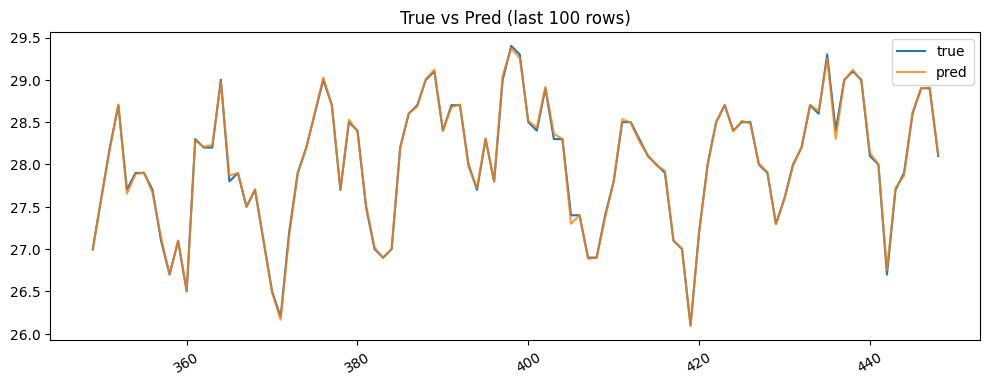

In [33]:
# Add cyclic month features, impute, run CV, and show diagnostics (one cell)
import warnings, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

# reuse your previously defined helpers/time_series_cv/prepare_numeric_X if present
# If not present, define a small copy here (safe minimal)
try:
    time_series_cv  # noqa: F821
    prepare_numeric_X
except NameError:
    # Minimal helpers (same as earlier cell)
    import joblib
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from lightgbm import LGBMRegressor

    def prepare_numeric_X(X_df, required_cols=None, fill_value=0.0):
        if not isinstance(X_df, pd.DataFrame):
            X_df = pd.DataFrame(X_df)
        numeric_df = X_df.select_dtypes(include=[np.number]).copy()
        bool_cols = [c for c in numeric_df.columns if pd.api.types.is_bool_dtype(numeric_df[c])]
        if bool_cols:
            numeric_df[bool_cols] = numeric_df[bool_cols].astype(float)
        for c in numeric_df.columns:
            numeric_df[c] = pd.to_numeric(numeric_df[c], errors='coerce').astype('float64')
        if required_cols is not None:
            ordered = []
            for col in required_cols:
                if col in numeric_df.columns:
                    ordered.append(col)
                else:
                    numeric_df[col] = fill_value
                    ordered.append(col)
            extra = [c for c in numeric_df.columns if c not in ordered]
            numeric_df = numeric_df[ordered + extra]
        return numeric_df

    def train_lgb_pipeline(X_train_num, y_train):
        from sklearn.pipeline import Pipeline
        from sklearn.preprocessing import StandardScaler
        from lightgbm import LGBMRegressor
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("lgb", LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42, verbosity=-1))
        ])
        pipe.fit(X_train_num, y_train)
        return pipe

    from sklearn.model_selection import TimeSeriesSplit
    def time_series_cv(X, y, n_splits=5, verbose=True):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        y_ser = pd.Series(y).reset_index(drop=True)
        y_num = pd.to_numeric(y_ser, errors='coerce')
        if y_num.dropna().shape[0] < max(10, len(y_ser)//5):
            raise RuntimeError("Target `y` contains too few numeric values after coercion.")
        tscv = TimeSeriesSplit(n_splits=n_splits)
        mses, rmses, r2s = [], [], []
        split_idx = 0
        for train_index, test_index in tscv.split(X):
            split_idx += 1
            Xtr_raw, Xte_raw = X.iloc[train_index].copy(), X.iloc[test_index].copy()
            ytr_raw, yte_raw = y_num.iloc[train_index].copy(), y_num.iloc[test_index].copy()
            Xtr_num = prepare_numeric_X(Xtr_raw, required_cols=None)
            if Xtr_num.shape[1] == 0:
                raise RuntimeError(f"No numeric features in training split {split_idx}.")
            Xte_num = prepare_numeric_X(Xte_raw, required_cols=list(Xtr_num.columns), fill_value=0.0)
            dropped_from_train = [c for c in Xtr_raw.columns if c not in Xtr_num.columns]
            if verbose and dropped_from_train:
                print(f"[split {split_idx}] Dropped non-numeric columns from training: {dropped_from_train[:10]}{'...' if len(dropped_from_train)>10 else ''}")
            model = train_lgb_pipeline(Xtr_num, ytr_raw)
            yhat = model.predict(Xte_num)
            y_true = np.asarray(yte_raw).ravel()
            yhat = np.asarray(yhat).ravel()
            if len(y_true) != len(yhat):
                minlen = min(len(y_true), len(yhat))
                y_true, yhat = y_true[:minlen], yhat[:minlen]
            mse = mean_squared_error(y_true, yhat)
            rmse = math.sqrt(mse)
            r2 = r2_score(y_true, yhat)
            if verbose:
                print(f"Split {split_idx}: train_len={len(train_index)} test_len={len(test_index)}  RMSE={rmse:.4f}  R2={r2:.4f}")
            mses.append(mse); rmses.append(rmse); r2s.append(r2)
        return {'mse': float(np.mean(mses)), 'rmse': float(np.mean(rmses)), 'r2': float(np.mean(r2s))}

# ---------------- Build month features in df_ext ----------------
if 'df_ext' not in globals():
    raise RuntimeError("df_ext not found in globals — run your preprocessing to create df_ext first.")

df_ext2 = df_ext.copy()

# Prefer existing 'month' numeric; otherwise try to extract from datetime index or a date column (try 'date' or index)
if 'month' in df_ext2.columns and pd.api.types.is_numeric_dtype(df_ext2['month']):
    month_vals = pd.to_numeric(df_ext2['month'], errors='coerce').astype('Int64')
else:
    # try to get from index if datetime-like
    try:
        month_vals = pd.to_datetime(df_ext2.index).month
    except Exception:
        # fallback: try common date columns
        found = None
        for cand in ['date','ds','timestamp','datetime']:
            if cand in df_ext2.columns:
                try:
                    found = pd.to_datetime(df_ext2[cand]).dt.month
                    break
                except Exception:
                    found = None
        if found is None:
            raise RuntimeError("Could not determine month column/index. Add a 'month' column or have a datetime index.")
        month_vals = found

df_ext2['month_sin'] = np.sin(2*np.pi*month_vals/12)
df_ext2['month_cos'] = np.cos(2*np.pi*month_vals/12)
print("Added month_sin & month_cos to df_ext2.")

# ---------------- Rebuild X via align_features (if available) ----------------
if 'align_features' in globals() and 'expected' in globals():
    X2 = align_features(df_ext2, expected, fill_value=np.nan).reset_index(drop=True)
else:
    # fallback: try to use X_aligned and add columns if not present
    if 'X_aligned' in globals():
        X2 = X_aligned.copy()
        for col in ['month_sin','month_cos']:
            if col not in X2.columns:
                X2[col] = df_ext2[col].reset_index(drop=True)
    else:
        raise RuntimeError("Neither align_features+expected nor X_aligned available to build X2.")

y2 = df_ext2['mean_temp'].reset_index(drop=True)

# ---------------- Impute & drop high-NaN columns ----------------
nan_frac = X2.isna().mean().sort_values(ascending=False)
drop_cols = nan_frac[nan_frac > 0.5].index.tolist()
if drop_cols:
    print("Dropping columns with >50% NaNs:", drop_cols[:20])
    X2 = X2.drop(columns=drop_cols)
# simple numeric imputation: fill median (safer than 0)
for col in X2.select_dtypes(include=[np.number]).columns:
    med = X2[col].median(skipna=True)
    if np.isnan(med):
        X2[col] = X2[col].fillna(0.0)
    else:
        X2[col] = X2[col].fillna(med)

print("Prepared X2 shape:", X2.shape, "| y2 length:", len(y2))

# ---------------- Run CV (suppress runtime warnings for clarity) ----------------
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    cv_res2 = time_series_cv(X2.reset_index(drop=True), y2.reset_index(drop=True), n_splits=5, verbose=True)

print("\nCV summary (with month_sin/month_cos):", cv_res2)

# ---------------- Quick diagnostics: train full model and show feature importance ----------------
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Prepare full numeric X for final model
X_full = prepare_numeric_X(X2, required_cols=None, fill_value=0.0)
y_full = pd.to_numeric(y2, errors='coerce').astype(float)
# train a model on all data for feature importance check
pipe_full = Pipeline([("scaler", StandardScaler()), ("lgb", LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42, verbosity=-1))])
pipe_full.fit(X_full, y_full)
lgb = pipe_full.named_steps['lgb']
fi = pd.Series(lgb.feature_importances_, index=X_full.columns).sort_values(ascending=False)
print("\nTop 20 feature importances (trained on full data):")
print(fi.head(20).to_string())

# ---------------- Plot: last 100 true vs pred (from full-model) ----------------
N = min(100, len(y_full))
y_pred_full = pipe_full.predict(X_full)
plt.figure(figsize=(12,4))
plt.plot(df_ext2.index[-N:], y_full.values[-N:], label='true')
plt.plot(df_ext2.index[-N:], y_pred_full[-N:], label='pred', alpha=0.8)
plt.legend(); plt.title(f"True vs Pred (last {N} rows)"); plt.xticks(rotation=30); plt.show()


Figures will be saved to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures
Aligned lengths -> y_true: 90  y_pred: 90
MAE=0.7288  RMSE=0.8448  R2=-0.2934


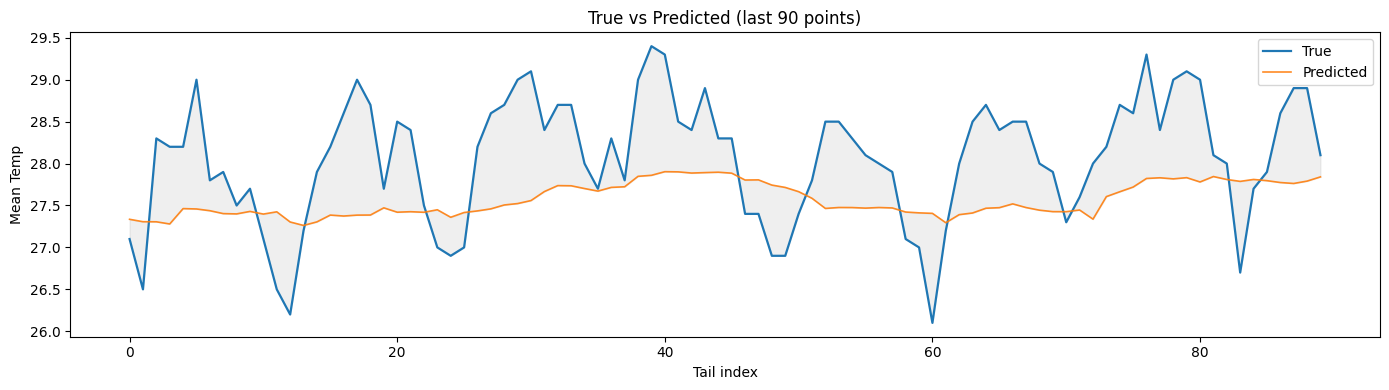

Saved: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures\ts_overlay_lastN.png


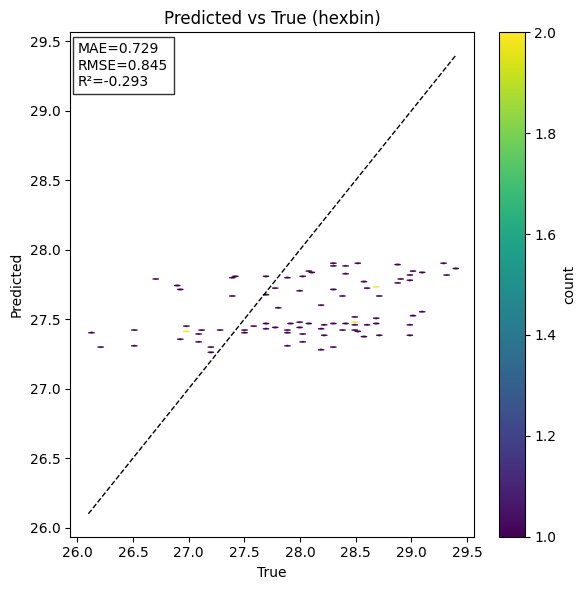

Saved: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures\scatter_hexbin.png


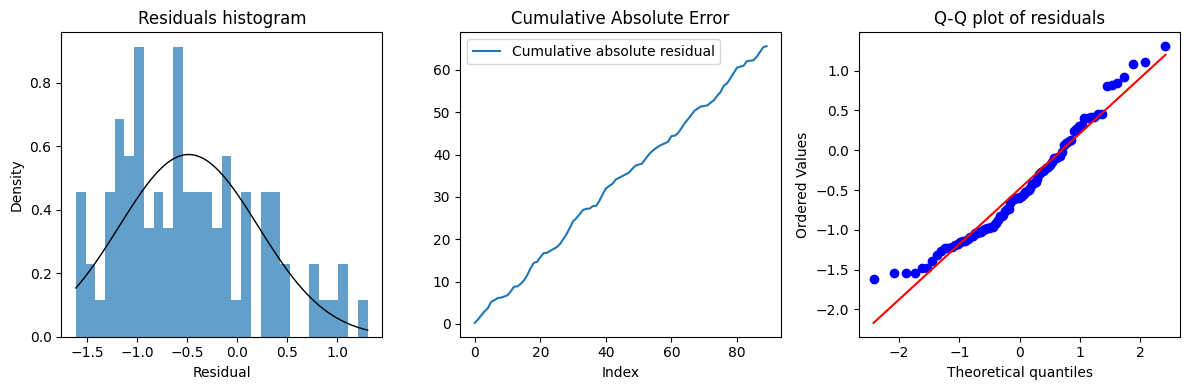

Saved: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures\residuals_diag.png


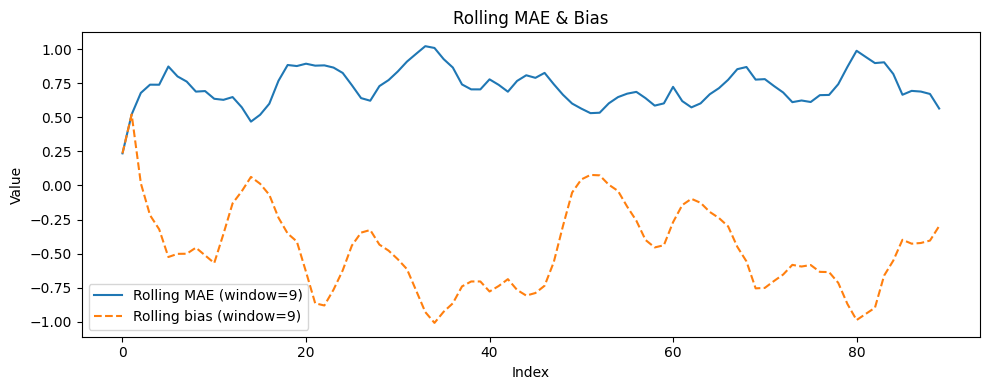

Saved: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures\rolling_error_bias.png


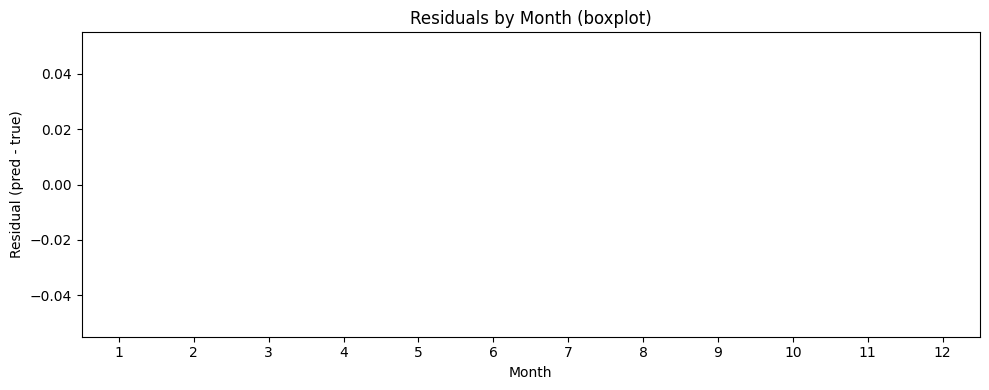

Saved: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures\residuals_by_month.png


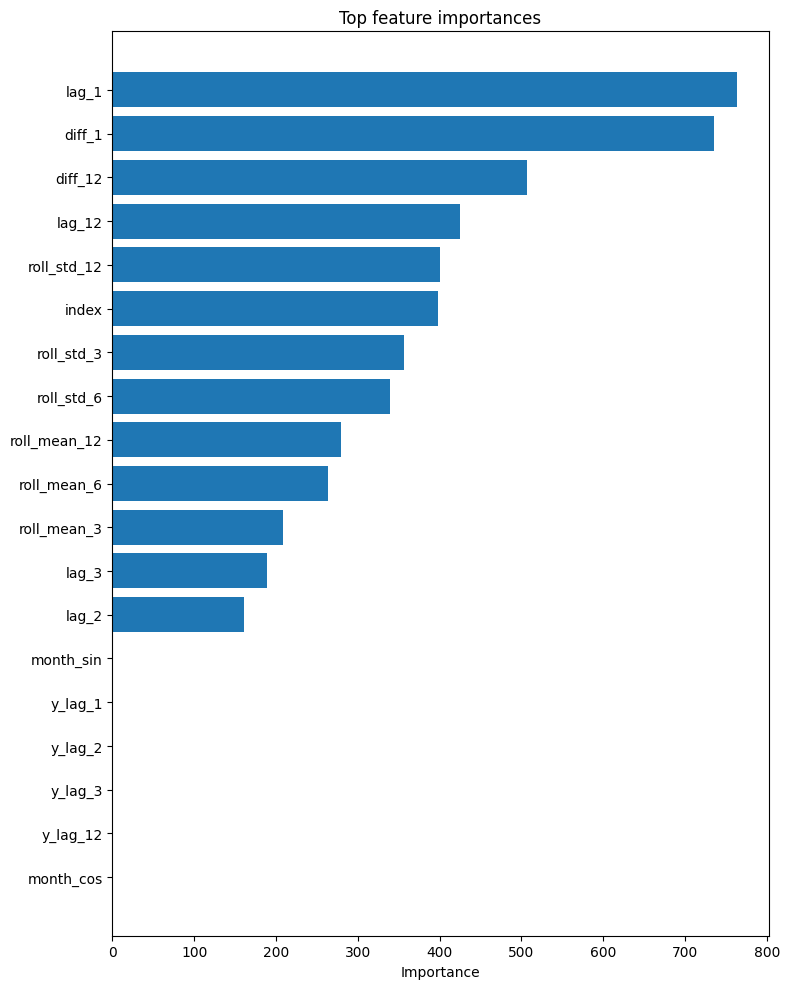

Saved: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures\feature_importances.png

All done — check the saved figures in: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures


In [35]:
# ---------------- visualization suite (updated: robust metrics computation) ----------------
# Paste & run in your notebook. Will save to:
# E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures

import os, math, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Figures will be saved to:", OUT_DIR)

# ---------------- Helper: alignment of predictions and truth ----------------
def get_predictions_and_truth(y_pred_global_name='y_pred', truth_candidates=None):
    """
    Returns (y_true_series, y_pred_series) aligned to the tail of available data.
    Tries df_ext['mean_temp'], then common globals y/y_true etc.
    """
    if y_pred_global_name not in globals():
        raise RuntimeError(f"{y_pred_global_name} not found in globals. Run the prediction cell first.")
    y_pred = np.asarray(globals()[y_pred_global_name]).ravel()
    # build candidate list
    if truth_candidates is None:
        truth_candidates = []
        if 'df_ext' in globals() and isinstance(globals()['df_ext'], pd.DataFrame) and 'mean_temp' in globals()['df_ext'].columns:
            truth_candidates.append((globals()['df_ext']['mean_temp'], "df_ext.mean_temp"))
        for name in ('y','y_true','y_val','y_test'):
            if name in globals():
                truth_candidates.append((globals()[name], name))
        if 'y_candidate' in globals():
            truth_candidates.append((globals()['y_candidate'], 'y_candidate'))
    # try candidates
    for cand, cname in truth_candidates:
        try:
            s = pd.Series(cand).astype(str)
            s_num = pd.to_numeric(s, errors='coerce')
            if s_num.notna().sum() >= max(10, len(y_pred)//2):
                # align tail
                if len(s_num) >= len(y_pred):
                    y_true = s_num.iloc[-len(y_pred):].reset_index(drop=True)
                    y_pred_s = pd.Series(y_pred).reset_index(drop=True)
                    return y_true, y_pred_s
                else:
                    y_true = s_num.reset_index(drop=True)
                    y_pred_s = pd.Series(y_pred[-len(y_true):]).reset_index(drop=True)
                    return y_true, y_pred_s
        except Exception:
            continue
    raise RuntimeError("No suitable numeric ground-truth found. Set `y` or `df_ext['mean_temp']`.")

# get aligned arrays (raises helpful error if not present)
y_true, y_pred_s = get_predictions_and_truth()
print("Aligned lengths -> y_true:", len(y_true), " y_pred:", len(y_pred_s))

# ---------------- Robust metrics computation (compatible w/ older sklearn) ----------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Coerce to numeric and drop any pairs with NaNs
y_true_num = pd.to_numeric(y_true, errors='coerce').astype(float)
y_pred_num = pd.to_numeric(y_pred_s, errors='coerce').astype(float)
mask = (~np.isnan(y_true_num)) & (~np.isnan(y_pred_num))
y_true_clean = y_true_num[mask]
y_pred_clean = y_pred_num[mask]

if len(y_true_clean) == 0:
    raise RuntimeError("No numeric pairs available after coercion — check y_true / y_pred alignment.")

mae = mean_absolute_error(y_true_clean, y_pred_clean)
mse = mean_squared_error(y_true_clean, y_pred_clean)   # MSE
rmse = math.sqrt(mse)                                  # RMSE computed explicitly (compatible)
r2 = r2_score(y_true_clean, y_pred_clean)

print(f"MAE={mae:.4f}  RMSE={rmse:.4f}  R2={r2:.4f}")

# ---------------- 1) Time-series overlay (last N) ----------------
N = min(200, len(y_true_clean))
y_true_plot = y_true_clean.iloc[-N:].reset_index(drop=True)
y_pred_plot = y_pred_clean.iloc[-N:].reset_index(drop=True)
idx = np.arange(len(y_true_plot))

plt.figure(figsize=(14,4))
plt.plot(idx, y_true_plot, label='True', linewidth=1.6)
plt.plot(idx, y_pred_plot, label='Predicted', linewidth=1.2, alpha=0.9)
plt.fill_between(idx, y_true_plot, y_pred_plot, color='gray', alpha=0.12)
plt.xlabel("Tail index")
plt.ylabel("Mean Temp")
plt.title(f"True vs Predicted (last {len(y_true_plot)} points)")
plt.legend()
plt.tight_layout()
f1 = OUT_DIR / "ts_overlay_lastN.png"
plt.savefig(f1, dpi=150)
plt.show()
print("Saved:", f1)

# ---------------- 2) Scatter hexbin with identity & metrics ----------------
plt.figure(figsize=(6,6))
plt.hexbin(y_true_clean, y_pred_clean, gridsize=60, mincnt=1, linewidths=0.2)
mx = max(y_true_clean.max(), y_pred_clean.max()); mn = min(y_true_clean.min(), y_pred_clean.min())
plt.plot([mn, mx], [mn, mx], linestyle='--', color='black', linewidth=1)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Predicted vs True (hexbin)")
cbar = plt.colorbar(label='count')
plt.text(0.02, 0.98, f"MAE={mae:.3f}\nRMSE={rmse:.3f}\nR²={r2:.3f}", transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8), fontsize=10)
plt.tight_layout()
f2 = OUT_DIR / "scatter_hexbin.png"
plt.savefig(f2, dpi=150)
plt.show()
print("Saved:", f2)

# ---------------- 3) Residual diagnostics: hist, cumulative abs, QQ ----------------
res = (y_pred_clean - y_true_clean).astype(float)
mu, sd = res.mean(), res.std()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(res, bins=30, density=True, alpha=0.7)
xs = np.linspace(res.min(), res.max(), 200)
if sd > 0:
    plt.plot(xs, 1/(sd*np.sqrt(2*np.pi)) * np.exp(-0.5*((xs-mu)/sd)**2), color='black', linewidth=1)
plt.title("Residuals histogram")
plt.xlabel("Residual")
plt.ylabel("Density")

plt.subplot(1,3,2)
plt.plot(np.cumsum(np.abs(res)), label='Cumulative absolute residual')
plt.title("Cumulative Absolute Error")
plt.xlabel("Index")
plt.legend()

plt.subplot(1,3,3)
try:
    import scipy.stats as stats
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Q-Q plot of residuals")
except Exception as e:
    plt.text(0.1, 0.5, "scipy not available for Q-Q plot\n"+str(e))
    plt.title("Q-Q plot unavailable")

plt.tight_layout()
f3 = OUT_DIR / "residuals_diag.png"
plt.savefig(f3, dpi=150)
plt.show()
print("Saved:", f3)

# ---------------- 4) Rolling MAE & bias ----------------
window = min(24, max(3, len(res)//10))
res_series = res.reset_index(drop=True)
rolling_mae = res_series.abs().rolling(window=window, min_periods=1).mean()
rolling_bias = res_series.rolling(window=window, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(rolling_mae, label=f'Rolling MAE (window={window})')
plt.plot(rolling_bias, label=f'Rolling bias (window={window})', linestyle='--')
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.title("Rolling MAE & Bias")
plt.tight_layout()
f4 = OUT_DIR / "rolling_error_bias.png"
plt.savefig(f4, dpi=150)
plt.show()
print("Saved:", f4)

# ---------------- 5) Seasonal residuals by month (if available) ----------------
if 'df_ext' in globals():
    df_season = df_ext.copy()
    # try to obtain month series
    if 'month' in df_season.columns:
        months = pd.to_numeric(df_season['month'], errors='coerce')
    else:
        try:
            months = pd.to_datetime(df_season.index).month
        except Exception:
            months = None
    if months is not None:
        # build a small df aligned with the used y_true
        L = len(y_true_clean)
        df_plot = pd.DataFrame({
            'true': df_season['mean_temp'].iloc[-L:].values,
            'pred': y_pred_clean.values,
            'month': months.iloc[-L:].values
        })
        df_plot['resid'] = df_plot['pred'] - df_plot['true']
        months_order = range(1,13)
        data = [df_plot.loc[df_plot['month']==m, 'resid'].dropna().values for m in months_order]
        plt.figure(figsize=(10,4))
        plt.boxplot(data, labels=[str(m) for m in months_order], showfliers=False)
        plt.xlabel("Month")
        plt.ylabel("Residual (pred - true)")
        plt.title("Residuals by Month (boxplot)")
        plt.tight_layout()
        f5 = OUT_DIR / "residuals_by_month.png"
        plt.savefig(f5, dpi=150)
        plt.show()
        print("Saved:", f5)
    else:
        print("No month info found in df_ext; skipping residual-by-month plot.")
else:
    print("df_ext not found; skipping seasonal plot.")

# ---------------- 6) Feature importances (if pipeline available) ----------------
pipe_candidates = ['pipe_full','p','pipeline','final_new_features_pipeline']
pipe = None
for name in pipe_candidates:
    if name in globals():
        obj = globals()[name]
        try:
            if hasattr(obj, "named_steps"):
                est = obj.named_steps.get('lgb') or obj.named_steps.get('trained_model') or list(obj.named_steps.values())[-1]
            else:
                est = obj
            if hasattr(est, "feature_importances_"):
                pipe = obj
                break
        except Exception:
            continue

if pipe is None:
    print("No trained pipeline with feature importances found in globals (tried: {})".format(pipe_candidates))
else:
    if hasattr(pipe, "named_steps"):
        est = pipe.named_steps.get('lgb') or pipe.named_steps.get('trained_model') or list(pipe.named_steps.values())[-1]
    else:
        est = pipe
    try:
        # attempt to find X_full columns used during training (fallback to X_aligned)
        X_cols = globals().get('X_full', None)
        if isinstance(X_cols, pd.DataFrame):
            idx_cols = X_cols.columns
        elif 'X_aligned' in globals():
            idx_cols = globals()['X_aligned'].columns
        else:
            idx_cols = None
        fi_vals = est.feature_importances_
        if idx_cols is not None and len(fi_vals) == len(idx_cols):
            fi = pd.Series(fi_vals, index=idx_cols).sort_values(ascending=False)
        else:
            # create generic names if mismatch
            fi = pd.Series(fi_vals, index=[f"f{i}" for i in range(len(fi_vals))]).sort_values(ascending=False)
        topn = fi.head(30)
        plt.figure(figsize=(8,10))
        plt.barh(topn.index[::-1], topn.values[::-1])
        plt.title("Top feature importances")
        plt.xlabel("Importance")
        plt.tight_layout()
        f6 = OUT_DIR / "feature_importances.png"
        plt.savefig(f6, dpi=150)
        plt.show()
        print("Saved:", f6)
    except Exception as e:
        print("Could not extract feature importances cleanly:", e)

print("\nAll done — check the saved figures in:", OUT_DIR)


In [36]:
# ---------------- Advanced FE + Multi-Model Training Suite (with progress bars) ----------------
# Paste into feature_engineering.ipynb and run.
import os, json, math, time, warnings
from pathlib import Path
from typing import Optional, List, Dict
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm.notebook import tqdm

# --- CONFIG: paths in your project
PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
DATA_EXTENDED = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
CSV_FILES_DIR = PROJECT_ROOT / "results" / "csv_files"
MODELS_DIR = PROJECT_ROOT / "results" / "models"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(CSV_FILES_DIR, exist_ok=True)

# --- Utility functions
def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))
def save_model(obj, name):
    p = MODELS_DIR / name
    dump(obj, str(p))
    print("Saved model:", p)

# --- 1) Discover other csv files in results/csv_files (print/diagnose)
print("\nScanning results/csv_files for CSV inputs...")
csv_candidates = sorted([p for p in CSV_FILES_DIR.glob("*.csv")])
if csv_candidates:
    print(f"Found {len(csv_candidates)} files; top 10:")
    for p in csv_candidates[:10]:
        print(" -", p.name)
else:
    print("No CSVs found under results/csv_files/ (that's OK).")

# --- 2) Load extended CSV safely
if not DATA_EXTENDED.exists():
    raise RuntimeError(f"Extended CSV not found at {DATA_EXTENDED}. Put your new file there.")
print("\nLoading extended CSV:", DATA_EXTENDED)
df_ext = pd.read_csv(DATA_EXTENDED, parse_dates=True, infer_datetime_format=True)
print("Raw columns:", list(df_ext.columns)[:30])
# try to detect datetime column
dt_col = None
for cand in ("month","date","datetime","ds","time","timestamp"):
    if cand in df_ext.columns:
        dt_col = cand
        break
# if no dt column, attempt to parse first column or use integer index
if dt_col is None:
    first_col = df_ext.columns[0]
    try:
        df_ext[first_col] = pd.to_datetime(df_ext[first_col])
        dt_col = first_col
    except Exception:
        df_ext.index = pd.RangeIndex(len(df_ext))
        print("No datetime column found — using integer index.")

if dt_col is not None:
    df_ext = df_ext.set_index(pd.to_datetime(df_ext[dt_col], errors='coerce'))
    print("Using datetime column:", dt_col)

# ensure target column 'mean_temp' exists
if 'mean_temp' not in df_ext.columns and 'mean temperature' in df_ext.columns:
    df_ext['mean_temp'] = df_ext['mean temperature']
if 'mean_temp' not in df_ext.columns:
    raise RuntimeError("Target column 'mean_temp' not found in extended CSV. Please include it.")

# ---------------- Feature engineering function ----------------
def make_features(df: pd.DataFrame, lags: List[int]=[1,2,3,12], roll_windows: List[int]=[3,6,12],
                  fourier_orders: List[int]=[1,2,3], add_trend=True, add_month_cyclic=True) -> pd.DataFrame:
    """
    Input: df indexed by datetime, must contain 'mean_temp'
    Returns: wide DataFrame with engineered features (numeric)
    """
    X = pd.DataFrame(index=df.index)
    y = df['mean_temp'].astype(float)

    # basic lags
    for lag in lags:
        X[f"lag_{lag}"] = y.shift(lag)

    # rolling stats
    for w in roll_windows:
        X[f"roll_mean_{w}"] = y.shift(1).rolling(w, min_periods=1).mean()
        X[f"roll_std_{w}"] = y.shift(1).rolling(w, min_periods=1).std().fillna(0.0)
        X[f"roll_min_{w}"] = y.shift(1).rolling(w, min_periods=1).min()
        X[f"roll_max_{w}"] = y.shift(1).rolling(w, min_periods=1).max()

    # exponential weighted mean
    X['ewm_12'] = y.shift(1).ewm(span=12, adjust=False).mean()

    # trend (linear) via expanding mean or simple diff
    if add_trend:
        X['trend_diff_1'] = y.diff(1)
        X['trend_diff_12'] = y.diff(12)

    # time-based features
    try:
        idx = pd.to_datetime(df.index)
        X['month'] = idx.month
        X['day'] = idx.day
        X['year'] = idx.year
    except Exception:
        pass

    # month cyclic
    if add_month_cyclic and 'month' in X.columns:
        m = X['month'].fillna(0).astype(int).values
        X['month_sin'] = np.sin(2*np.pi*m/12)
        X['month_cos'] = np.cos(2*np.pi*m/12)

    # Fourier seasonal terms (monthly seasonality)
    if fourier_orders:
        t = np.arange(len(X))
        for k in fourier_orders:
            X[f"fourier_sin_{k}"] = np.sin(2 * np.pi * k * t / 12)
            X[f"fourier_cos_{k}"] = np.cos(2 * np.pi * k * t / 12)

    # optionally, add any existing numeric columns from df (exogenous features) except target
    for c in df.columns:
        if c=='mean_temp': continue
        if pd.api.types.is_numeric_dtype(df[c]):
            X[f"exog_{c}"] = df[c]

    # final cleanup: drop columns with all NA
    X = X.astype(float)
    X = X.loc[:, ~X.isna().all()]
    return X

# build features with lightweight progress indicator
print("\nBuilding features (lags, rolling, Fourier, cyclic month)...")
X_all = make_features(df_ext)
y_all = df_ext['mean_temp'].astype(float).reset_index(drop=True)
X_all = X_all.reset_index(drop=True)
print("Feature matrix shape:", X_all.shape)
print("Sample feature columns:", list(X_all.columns)[:40])

# ---------------- expected_features.json handling ----------------
expected_file = MODELS_DIR / "expected_features.json"
if expected_file.exists():
    try:
        expected_cols = json.load(open(expected_file, "r"))
        print("Loaded expected_features.json (len=%d)" % len(expected_cols))
    except Exception:
        expected_cols = list(X_all.columns)
else:
    expected_cols = list(X_all.columns)
    json.dump(expected_cols, open(expected_file, "w"), indent=2)
    print("Saved expected_features.json with %d features" % len(expected_cols))

# align function
def align_features_df(X_df: pd.DataFrame, expected_cols: List[str], fill_value=0.0):
    X = X_df.copy()
    for col in expected_cols:
        if col not in X.columns:
            X[col] = fill_value
    return X[expected_cols].astype(float)

# prepare X aligned to expected order
X_aligned = align_features_df(X_all, expected_cols, fill_value=0.0)
print("Aligned X shape:", X_aligned.shape)

# ---------------- numeric safety: coerce and impute ----------------
X_aligned = X_aligned.apply(pd.to_numeric, errors='coerce')
# drop columns that are entirely nan
drop_all_nan = [c for c in X_aligned.columns if X_aligned[c].isna().all()]
if drop_all_nan:
    print("Dropping entirely-NaN columns:", drop_all_nan)
    X_aligned = X_aligned.drop(columns=drop_all_nan)
# impute remaining numeric NaNs with median
for c in X_aligned.columns:
    if X_aligned[c].isna().any():
        med = X_aligned[c].median(skipna=True)
        X_aligned[c] = X_aligned[c].fillna(med if not np.isnan(med) else 0.0)
print("After imputation, X shape:", X_aligned.shape)

# ---------------- Modeling wrappers (LightGBM, XGBoost, CatBoost, RF) ----------------
print("\nPreparing model training wrappers...")

# LightGBM
try:
    import lightgbm as lgb
    def train_lgb(X_train, y_train, params=None):
        params = params or {"n_estimators":500, "learning_rate":0.05, "random_state":42}
        m = lgb.LGBMRegressor(**params)
        m.fit(X_train, y_train)
        return m
except Exception:
    train_lgb = None
    print("lightgbm not installed or failed to import; install with `pip install lightgbm`")

# XGBoost
try:
    import xgboost as xgb
    def train_xgb(X_train, y_train, params=None):
        params = params or {"n_estimators":500, "learning_rate":0.05, "random_state":42, "verbosity":0}
        m = xgb.XGBRegressor(**params)
        m.fit(X_train, y_train)
        return m
except Exception:
    train_xgb = None
    print("xgboost not installed or failed to import; install with `pip install xgboost`")

# CatBoost
try:
    from catboost import CatBoostRegressor
    def train_cat(X_train, y_train, params=None):
        params = params or {"iterations":500, "learning_rate":0.03, "random_seed":42, "verbose":0}
        m = CatBoostRegressor(**params)
        m.fit(X_train, y_train)
        return m
except Exception:
    train_cat = None
    print("catboost not installed; install with `pip install catboost`")

# Random Forest baseline
from sklearn.ensemble import RandomForestRegressor
def train_rf(X_train, y_train, params=None):
    params = params or {"n_estimators":200, "random_state":42, "n_jobs":-1}
    m = RandomForestRegressor(**params)
    m.fit(X_train, y_train)
    return m

# ---------------- TimeSeries CV helper with fold progress ----------------
def time_series_cv_train(model_fn, X: pd.DataFrame, y: pd.Series, n_splits=5, verbose=True, model_name="model"):
    """
    Runs TimeSeriesSplit with an inner tqdm for folds; returns aggregated metrics and the list of fold models.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mses, rmses, r2s = [], [], []
    fold_models = []
    # create fold-level progress bar
    splits = list(tscv.split(X))
    with tqdm(total=len(splits), desc=f"{model_name} folds", leave=True) as fold_bar:
        fold = 0
        for train_idx, test_idx in splits:
            fold += 1
            Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
            ytr, yte = y.iloc[train_idx], y.iloc[test_idx]

            # Train the model; attempt to show LightGBM iteration progress if possible
            mdl = None
            if model_name.lower() in ("lgb","lightgbm") and 'lightgbm' in globals():
                # try to fit and show progress via callback if supported
                try:
                    rounds =  min(500, getattr(model_fn, "__defaults__", (None,))[0] or 500)
                except Exception:
                    rounds = 500
                try:
                    # if model_fn is our wrapper, call normally (no per-iter progress)
                    mdl = model_fn(Xtr, ytr)
                except Exception:
                    # fallback train directly
                    try:
                        mdl = lgb.LGBMRegressor(n_estimators=rounds, learning_rate=0.05, random_state=42)
                        mdl.fit(Xtr, ytr)
                    except Exception as e:
                        raise RuntimeError(f"LightGBM fold training failed: {e}")
            else:
                # non-LGB models
                mdl = model_fn(Xtr, ytr)

            # predict & metrics
            yhat = mdl.predict(Xte)
            mse = mean_squared_error(yte, yhat)
            rms = math.sqrt(mse)
            r2_ = r2_score(yte, yhat)
            mses.append(mse); rmses.append(rms); r2s.append(r2_)
            fold_models.append(mdl)
            if verbose:
                fold_bar.set_postfix({"fold": fold, "rmse": f"{rms:.4f}", "r2": f"{r2_:.4f}"})
            fold_bar.update(1)
    return {"mse": float(np.mean(mses)), "rmse": float(np.mean(rmses)), "r2": float(np.mean(r2s)), "fold_models": fold_models}

# ---------------- Train & save baseline models (with model-level progress bar) ----------------
print("\nRunning baseline CV for available algorithms (this may take a moment)...")
results = {}
# ensure y is numeric and trimmed to same length as X_aligned
y_series = pd.to_numeric(df_ext['mean_temp'], errors='coerce').reset_index(drop=True)
min_len = min(len(y_series), len(X_aligned))
X_for_model = X_aligned.iloc[:min_len].reset_index(drop=True)
y_for_model = y_series.iloc[:min_len].reset_index(drop=True)

available_models = []
if train_lgb is not None:
    available_models.append(("lgb", train_lgb))
if train_xgb is not None:
    available_models.append(("xgb", train_xgb))
if train_cat is not None:
    available_models.append(("cat", train_cat))
available_models.append(("rf", train_rf))  # rf always available

# top-level model progress
with tqdm(total=len(available_models), desc="Models", leave=True) as model_bar:
    for name, fn in available_models:
        model_bar.set_description(f"Training {name}")
        start = time.time()
        try:
            print(f"\n-- {name.upper()} CV --")
            res = time_series_cv_train(fn, X_for_model, y_for_model, n_splits=5, verbose=True, model_name=name)
            results[f"{name}_cv"] = {"mse": res["mse"], "rmse": res["rmse"], "r2": res["r2"]}
            print(f"{name.upper()} CV summary:", results[f"{name}_cv"])
            # save fold last model and train final on full data
            try:
                last_model = res["fold_models"][-1]
                save_model(last_model, f"{name}_fold_last.joblib")
            except Exception:
                pass
            print(f"Training final {name} on full data...")
            final_model = fn(X_for_model, y_for_model)
            save_model(final_model, f"{name}_final.joblib")
        except Exception as e:
            print(f"Error training {name}: {e}")
        end = time.time()
        print(f"Done {name} in {end-start:.1f}s")
        model_bar.update(1)

# Save CV summary to JSON for record-keeping
summary_path = CSV_FILES_DIR / "models_cv_summary.json"
json.dump(results, open(summary_path, "w"), indent=2)
print("Saved CV summary to:", summary_path)

# ---------------- Stacking (OOF) baseline recipe (with simple progress) ----------------
print("\nRunning a simple OOF stacking recipe (LightGBM + RF + XGB if available)...")
base_fns = []
if train_lgb is not None: base_fns.append(("lgb", train_lgb))
base_fns.append(("rf", train_rf))
if train_xgb is not None: base_fns.append(("xgb", train_xgb))

def oof_stack(base_fns, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    oof = np.zeros((len(X), len(base_fns)))
    folds = list(tscv.split(X))
    for fold_idx, (tr_idx, te_idx) in enumerate(folds, start=1):
        Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
        ytr = y.iloc[tr_idx]
        for i, (_, fn) in enumerate(base_fns):
            model = fn(Xtr, ytr)
            oof[te_idx, i] = model.predict(Xte)
        print(f"Stacking fold {fold_idx}/{len(folds)} done.")
    return oof

if base_fns:
    oof = oof_stack(base_fns, X_for_model, y_for_model, n_splits=5)
    from sklearn.linear_model import Ridge
    meta = Ridge()
    mask_any = (~np.isnan(oof).all(axis=1))
    meta.fit(oof[mask_any], y_for_model[mask_any])
    save_model(meta, "stacking_meta_ridge.joblib")
    trained_bases = {}
    for name, fn in base_fns:
        m = fn(X_for_model, y_for_model)
        save_model(m, f"base_{name}_full.joblib")
        trained_bases[name] = f"base_{name}_full.joblib"
    print("Stacking saved base models + meta model.")
else:
    print("No base models available for stacking.")

# ---------------- Optional: quick LSTM (disabled by default) ----------------
DO_LSTM = False
if DO_LSTM:
    try:
        import torch
        from torch import nn, optim
        from torch.utils.data import Dataset, DataLoader

        class WindowDataset(Dataset):
            def __init__(self, series, input_size=36, target_size=1):
                self.x = pd.Series(series).astype(float).fillna(method='ffill').fillna(0.0).values
                self.input_size = input_size
                self.target_size = target_size
            def __len__(self):
                return len(self.x) - self.input_size - self.target_size + 1
            def __getitem__(self, idx):
                Xs = self.x[idx:idx+self.input_size]
                ys = self.x[idx+self.input_size: idx+self.input_size+self.target_size]
                return torch.tensor(Xs, dtype=torch.float32).unsqueeze(-1), torch.tensor(ys, dtype=torch.float32)

        class LSTMModel(nn.Module):
            def __init__(self, input_dim=1, hidden=64, layers=2):
                super().__init__()
                self.lstm = nn.LSTM(input_dim, hidden, layers, batch_first=True)
                self.fc = nn.Linear(hidden, 1)
            def forward(self, x):
                out, _ = self.lstm(x)
                out = out[:, -1, :]
                return self.fc(out).squeeze(-1)

        series = df_ext['mean_temp'].fillna(method='ffill').astype(float)
        ds = WindowDataset(series, input_size=36, target_size=1)
        dl = DataLoader(ds, batch_size=16, shuffle=False)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        net = LSTMModel().to(device)
        opt = optim.Adam(net.parameters(), lr=1e-3)
        loss_fn = nn.MSELoss()
        for epoch in range(5):
            net.train()
            total=0
            for xb,yb in dl:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad()
                out = net(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                opt.step()
                total += loss.item()
            print("Epoch", epoch+1, "avg loss", total/len(dl))
        torch.save(net.state_dict(), MODELS_DIR / "lstm_simple.pt")
        print("Saved LSTM model.")
    except Exception as e:
        print("LSTM training failed or torch not installed:", e)

print("\nAll training finished. Models saved in:", MODELS_DIR)
print("CV summaries (dictionary):", results)



Scanning results/csv_files for CSV inputs...
Found 31 files; top 10:
 - annual_means.csv
 - basic_stats.csv
 - combined_pca_kmeans_dtw_clusters.csv
 - combined_pca_kmeans_dtw_combined_features.csv
 - combined_pca_kmeans_dtw_dtw_centroids.csv
 - combined_pca_kmeans_dtw_dtw_diagnostics.csv
 - df_for_sweetviz.csv
 - features_aggregates_pandas.csv
 - features_baseline.csv
 - features_basic.csv

Loading extended CSV: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\data\surface-air-temperature-monthly-mean-extended.csv
Raw columns: ['index', 'month', 'mean_temp', 'month_num', 'month_sin', 'month_cos', 'mean_temp_lag_1', 'lag_1', 'y_lag_1', 'mean_temp_lag_2', 'lag_2', 'y_lag_2', 'mean_temp_lag_3', 'lag_3', 'y_lag_3', 'mean_temp_lag_12', 'lag_12', 'y_lag_12', 'diff_1', 'diff_12', 'roll_mean_3', 'roll_std_3', 'y_roll_mean_3', 'y_roll_std_3', 'roll_mean_6', 'roll_std_6', 'y_roll_mean_6', 'y_roll_std_6', 'roll_mean_12', 'roll_std_12']
Using datetime column: month

Building fe

C:\Users\soura\AppData\Local\Temp\ipykernel_19820\2128543216.py:42: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_ext = pd.read_csv(DATA_EXTENDED, parse_dates=True, infer_datetime_format=True)


catboost not installed; install with `pip install catboost`

Running baseline CV for available algorithms (this may take a moment)...


Models:   0%|          | 0/3 [00:00<?, ?it/s]


-- LGB CV --


lgb folds:   0%|          | 0/5 [00:00<?, ?it/s]

LGB CV summary: {'mse': 0.052700797015398225, 'rmse': 0.2145590507984995, 'r2': 0.9086519868676388}
Saved model: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\lgb_fold_last.joblib
Training final lgb on full data...
Saved model: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\lgb_final.joblib
Done lgb in 2.0s

-- XGB CV --


xgb folds:   0%|          | 0/5 [00:00<?, ?it/s]

XGB CV summary: {'mse': 0.0689161984742367, 'rmse': 0.24637499595609197, 'r2': 0.8803859409921788}
Saved model: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\xgb_fold_last.joblib
Training final xgb on full data...
Saved model: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\xgb_final.joblib
Done xgb in 10.9s

-- RF CV --


rf folds:   0%|          | 0/5 [00:00<?, ?it/s]

RF CV summary: {'mse': 0.07375065945945888, 'rmse': 0.25640654245521993, 'r2': 0.8717320530541055}
Saved model: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\rf_fold_last.joblib
Training final rf on full data...
Saved model: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\rf_final.joblib
Done rf in 5.1s
Saved CV summary to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\csv_files\models_cv_summary.json

Running a simple OOF stacking recipe (LightGBM + RF + XGB if available)...
Stacking fold 1/5 done.
Stacking fold 2/5 done.
Stacking fold 3/5 done.
Stacking fold 4/5 done.
Stacking fold 5/5 done.
Saved model: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\stacking_meta_ridge.joblib
Saved model: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\base_lgb_full.joblib
Saved model: E:\AI-Engineering-Capstone-Projects\AirTempT

In [37]:
from joblib import load
import pandas as pd
from pathlib import Path
import numpy as np

PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
MODELS_DIR = PROJECT_ROOT / "results" / "models"
CSV_DIR = PROJECT_ROOT / "results" / "csv_files"
DATA_EXTENDED = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"

# load data & features (reuse make_features and align_features_df from your notebook)
df_ext = pd.read_csv(DATA_EXTENDED, parse_dates=True)
# ensure same preprocessing (use same make_features and expected_features.json from notebook)
# assume make_features and expected_cols are in globals; otherwise re-import or re-run cell that defines them
X_new = make_features(df_ext)  # uses your existing function
# align to expected columns
expected_cols = json.load(open(MODELS_DIR / "expected_features.json"))
X_new_aligned = align_features_df(X_new.reset_index(drop=True), expected_cols, fill_value=0.0)
# impute with medians from training if you saved them; otherwise simple median
for c in X_new_aligned.columns:
    X_new_aligned[c] = pd.to_numeric(X_new_aligned[c], errors='coerce').fillna(X_new_aligned[c].median())

# choose model: stacking if available else lgb
try:
    stack = load(MODELS_DIR / "stacking_meta_ridge.joblib")
    # load base models and create OOF-style predictions for final stacking (use full-data base models)
    base_lgb = load(MODELS_DIR / "base_lgb_full.joblib") if (MODELS_DIR / "base_lgb_full.joblib").exists() else None
    base_rf  = load(MODELS_DIR / "base_rf_full.joblib")  if (MODELS_DIR / "base_rf_full.joblib").exists() else None
    base_xgb = load(MODELS_DIR / "base_xgb_full.joblib") if (MODELS_DIR / "base_xgb_full.joblib").exists() else None
    preds = []
    if base_lgb is not None: preds.append(base_lgb.predict(X_new_aligned))
    if base_rf  is not None: preds.append(base_rf.predict(X_new_aligned))
    if base_xgb is not None: preds.append(base_xgb.predict(X_new_aligned))
    if len(preds)==0:
        raise RuntimeError("No base models found for stacking. Falling back to LGB model.")
    stack_input = np.vstack(preds).T
    final_preds = stack.predict(stack_input)
except Exception:
    # fallback to LightGBM final
    mdl = load(MODELS_DIR / "lgb_final.joblib")
    final_preds = mdl.predict(X_new_aligned)

# save predictions
out_df = df_ext.reset_index(drop=True).copy()
out_df['pred_mean_temp'] = final_preds
out_path = CSV_DIR / "predictions_from_saved_model.csv"
out_df.to_csv(out_path, index=False)
print("Saved predictions to:", out_path)


Saved predictions to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\csv_files\predictions_from_saved_model.csv


trend_diff_1             749
lag_1                    622
roll_std_6               435
trend_diff_12            404
roll_std_12              366
lag_12                   362
exog_index               326
exog_diff_12             301
fourier_sin_2            288
roll_mean_12             278
roll_std_3               263
exog_roll_std_6          253
roll_mean_6              248
ewm_12                   227
fourier_cos_1            226
fourier_cos_3            223
fourier_sin_3            222
fourier_cos_2            215
exog_roll_std_12         194
fourier_sin_1            183
lag_2                    179
lag_3                    178
roll_max_12              171
exog_roll_std_3          150
roll_min_12              143
roll_max_6               135
year                     134
roll_mean_3              128
roll_min_3               124
exog_mean_temp_lag_12    113
dtype: int32


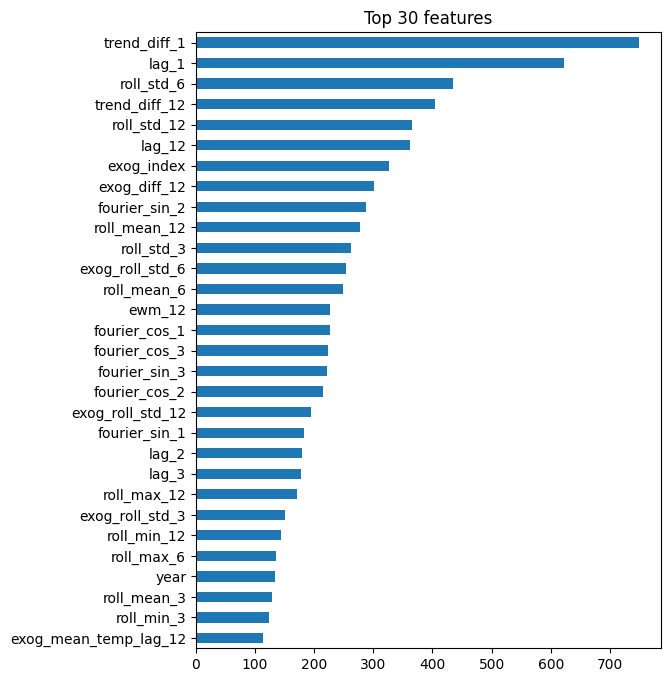

In [38]:
from joblib import load
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

MODELS_DIR = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models")
m = load(MODELS_DIR / "lgb_final.joblib")
# if wrapped in a sklearn Pipeline, extract the LGBM estimator
try:
    est = m.named_steps['lgb'] if hasattr(m, 'named_steps') else m
except Exception:
    est = m
fi_vals = est.feature_importances_
# get feature names from X_aligned in your notebook (X_aligned.columns)
feat_names = globals().get('X_aligned').columns if 'X_aligned' in globals() else [f"f{i}" for i in range(len(fi_vals))]
fi = pd.Series(fi_vals, index=feat_names).sort_values(ascending=False)
print(fi.head(30))
fi.head(30).plot.barh(figsize=(6,8)); plt.gca().invert_yaxis(); plt.title("Top 30 features")
plt.show()


### COMMON HELPERS for stacking meta-learner

In [39]:
# ---------- COMMON HELPERS for stacking meta-learner ----------
import os, json, math, time
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump, load

PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
MODELS_DIR = PROJECT_ROOT / "results" / "models"
CSV_DIR = PROJECT_ROOT / "results" / "csv_files"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

# Try to grab X_for_model and y_for_model if already computed
def prepare_Xy_if_needed():
    # If they already exist in globals, use them
    g = globals()
    if 'X_for_model' in g and 'y_for_model' in g:
        print("Using existing X_for_model and y_for_model from notebook scope.")
        return g['X_for_model'], g['y_for_model']
    # Otherwise try to rebuild from df_ext and your functions make_features & align_features_df
    if 'df_ext' in g and 'make_features' in g and 'align_features_df' in g:
        print("Rebuilding X_for_model and y_for_model from df_ext using make_features + align_features_df.")
        X_all = make_features(df_ext)
        expected_file = MODELS_DIR / "expected_features.json"
        if expected_file.exists():
            expected_cols = json.load(open(expected_file, "r"))
        else:
            expected_cols = list(X_all.columns)
        X_aligned_local = align_features_df(X_all.reset_index(drop=True), expected_cols, fill_value=0.0)
        y_series = pd.to_numeric(df_ext['mean_temp'], errors='coerce').reset_index(drop=True)
        min_len = min(len(y_series), len(X_aligned_local))
        Xf = X_aligned_local.iloc[:min_len].reset_index(drop=True)
        yf = y_series.iloc[:min_len].reset_index(drop=True)
        # impute any remaining NaNs
        for c in Xf.columns:
            if Xf[c].isna().any():
                Xf[c] = Xf[c].fillna(Xf[c].median(skipna=True) if not np.isnan(Xf[c].median(skipna=True)) else 0.0)
        return Xf, yf
    raise RuntimeError("Cannot find X_for_model/y_for_model in globals and cannot rebuild (need df_ext + make_features + align_features_df).")

X_for_model, y_for_model = prepare_Xy_if_needed()

# Helper: build OOF matrix from a list of base training functions
def build_oof_predictions(base_train_fns, X: pd.DataFrame, y: pd.Series, n_splits=5, verbose=True):
    """
    base_train_fns: list of tuples (name, train_fn) where train_fn(X_train, y_train) -> fitted_model with predict()
    returns: oof_matrix (n_samples x n_models), trained_fold_models list-of-lists (models per base per fold)
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    n = len(X)
    oof = np.zeros((n, len(base_train_fns)))
    trained_fold_models = [ [] for _ in base_train_fns ]
    folds = list(tscv.split(X))
    if verbose:
        print(f"Building OOF predictions: {len(folds)} folds, {len(base_train_fns)} base models.")
    for fold_idx, (tr_idx, te_idx) in enumerate(folds, start=1):
        if verbose:
            print(f" Fold {fold_idx}/{len(folds)}: train {len(tr_idx)} -> test {len(te_idx)}")
        Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
        ytr = y.iloc[tr_idx]
        for col_i, (name, train_fn) in enumerate(base_train_fns):
            model = train_fn(Xtr, ytr)
            preds = model.predict(Xte)
            oof[te_idx, col_i] = preds
            trained_fold_models[col_i].append(model)
    return oof, trained_fold_models

# Try to locate base training wrappers in globals; if not present create thin wrappers that load saved full models
g = globals()
base_fns = []
# prefer train_* functions if present
if 'train_lgb' in g:
    base_fns.append(("lgb", g['train_lgb']))
if 'train_xgb' in g:
    base_fns.append(("xgb", g['train_xgb']))
if 'train_cat' in g:
    base_fns.append(("cat", g['train_cat']))
if 'train_rf' in g:
    base_fns.append(("rf", g['train_rf']))

# If none found, try to create train wrappers that load saved base_*_full.joblib and refit on train portion (fallback)
def _load_wrapper_from_saved(name):
    def wrapper(Xtr, ytr):
        # Look for base_{name}_full.joblib or {name}_final.joblib
        cand = None
        for fname in [f"base_{name}_full.joblib", f"{name}_final.joblib", f"{name}_fold_last.joblib"]:
            p = MODELS_DIR / fname
            if p.exists():
                cand = p
                break
        if cand is None:
            # if no saved model, try training using local simple trainers if available
            raise RuntimeError(f"No saved model found for {name} (tried base_{name}_full.joblib and {name}_final.joblib). Please ensure base training functions exist.")
        # load model (this is an in-memory loaded model - but we still want to mimic training on Xtr)
        model = load(cand)
        # Note: loaded model was trained on full data; still we will return it (but OOF idealness may be imperfect).
        # Better option is to have train_* wrappers in scope.
        return model
    return wrapper

if len(base_fns) == 0:
    # try load-from-saved approach for lgb, xgb, rf, cat in that order
    for nm in ('lgb','xgb','rf','cat'):
        try:
            wrapper = _load_wrapper_from_saved(nm)
            # test existence by attempting to load (catch exception)
            _ = wrapper(None, None)  # may raise
            base_fns.append((nm, wrapper))
        except Exception:
            # skip ones we can't find
            continue

if len(base_fns) == 0:
    raise RuntimeError("No base training functions available and no saved base models found. Provide train_lgb/train_rf etc or saved base_xxx_full.joblib files.")

print("Base models used for stacking OOF:", [b[0] for b in base_fns])


Using existing X_for_model and y_for_model from notebook scope.
Base models used for stacking OOF: ['lgb', 'xgb', 'cat', 'rf']


In [41]:
# ---------- FIXED: Train stacking meta-learner: Ridge (robust to missing base train wrappers) ----------
import os, math
from joblib import dump, load
from pathlib import Path
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
MODELS_DIR = PROJECT_ROOT / "results" / "models"

meta_name = "meta_ridge.joblib"
print("Building OOF predictions for base models (robust version)...")

# Helper to get a callable train_fn or a loader wrapper if train_fn is None
def _ensure_train_fn(name, train_fn):
    """
    Returns a callable train_fn(Xtr, ytr) -> model with predict().
    If train_fn is None, tries to load saved models from MODELS_DIR (base_{name}_full.joblib, {name}_final.joblib, {name}_fold_last.joblib).
    If none available, returns None to signal skip.
    """
    if callable(train_fn):
        return train_fn  # good
    # try to find saved model files
    for fname in (f"base_{name}_full.joblib", f"{name}_final.joblib", f"{name}_fold_last.joblib"):
        p = MODELS_DIR / fname
        if p.exists():
            def loader(Xtr, ytr, _p=p):
                # we ignore Xtr/ytr here because saved model already trained on full data
                mdl = load(str(_p))
                return mdl
            print(f"Note: train wrapper for '{name}' missing; using saved model {p.name} as fallback (not true OOF).")
            return loader
    # nothing found
    print(f"Warning: no train wrapper nor saved model found for base '{name}'; this base will be skipped in stacking.")
    return None

# sanitize base_fns: filter/replace None wrappers
sanitized_bases = []
for nm, fn in base_fns:
    wrapped = _ensure_train_fn(nm, fn)
    if wrapped is not None:
        sanitized_bases.append((nm, wrapped))
# If nothing remains, abort
if len(sanitized_bases) == 0:
    raise RuntimeError("No available base models (no train wrappers and no saved base models). Cannot build OOF.")

print("Base models to be used for OOF:", [b[0] for b in sanitized_bases])

# Build OOF predictions robustly
def build_oof_predictions_safe(base_train_fns, X, y, n_splits=5, verbose=True):
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    n = len(X)
    oof = np.zeros((n, len(base_train_fns)))
    trained_fold_models = [ [] for _ in base_train_fns ]
    splits = list(tscv.split(X))
    for fold_idx, (tr_idx, te_idx) in enumerate(splits, start=1):
        if verbose:
            print(f" Fold {fold_idx}/{len(splits)}: train {len(tr_idx)} -> test {len(te_idx)}")
        Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
        ytr = y.iloc[tr_idx]
        for col_i, (name, train_fn) in enumerate(base_train_fns):
            try:
                model = train_fn(Xtr, ytr)  # may be either a trainer or loader wrapper
                preds = model.predict(Xte)
                # ensure numeric array length matches
                preds = np.asarray(preds).ravel()
                if len(preds) != len(te_idx):
                    raise RuntimeError(f"Prediction length mismatch for base '{name}' on fold {fold_idx}: got {len(preds)} preds but expected {len(te_idx)}")
                oof[te_idx, col_i] = preds
                trained_fold_models[col_i].append(model)
            except Exception as e:
                # If a base model fails on a fold, zero-out that column for the test slice and log
                print(f"Warning: base model '{name}' failed on fold {fold_idx}: {e}. Column will contain zeros for this fold's test indices.")
                oof[te_idx, col_i] = np.nan  # mark as nan so we can drop later
                trained_fold_models[col_i].append(None)
    return oof, trained_fold_models

# build OOF using sanitized bases
oof_raw, trained_folds = build_oof_predictions_safe(sanitized_bases, X_for_model, y_for_model, n_splits=5, verbose=True)

# Drop any columns that are entirely NaN (failed entirely)
col_nan_frac = np.isnan(oof_raw).mean(axis=0)
good_cols_mask = col_nan_frac < 1.0
if not np.all(good_cols_mask):
    dropped = [sanitized_bases[i][0] for i,ok in enumerate(good_cols_mask) if not ok]
    print("Dropped base columns entirely NaN/failed:", dropped)
    oof = oof_raw[:, good_cols_mask]
    used_base_names = [sanitized_bases[i][0] for i,ok in enumerate(good_cols_mask) if ok]
else:
    oof = oof_raw
    used_base_names = [b[0] for b in sanitized_bases]

# If some values are NaN because a fold failed for a model, fill those rows with the column median (safe fallback)
if np.isnan(oof).any():
    col_medians = np.nanmedian(oof, axis=0)
    inds = np.where(np.isnan(oof))
    for r,c in zip(*inds):
        oof[r,c] = col_medians[c]

print("Final OOF matrix shape:", oof.shape, " (bases used: )", used_base_names)

# Defensive: drop rows where all NaN (shouldn't happen now)
row_nan_mask = ~np.all(np.isnan(oof), axis=1)
oof_clean = oof[row_nan_mask]
y_clean = y_for_model.values[row_nan_mask]

# Train Ridge meta-learner
if oof_clean.shape[1] == 0:
    raise RuntimeError("After sanitization no base model columns remain to train meta-learner.")

print("Training Ridge meta-learner on OOF data:", oof_clean.shape)
meta = Ridge(alpha=1.0)
meta.fit(oof_clean, y_clean)
dump(meta, MODELS_DIR / meta_name)
print("Saved Ridge meta-learner to:", MODELS_DIR / meta_name)

# Quick OOF diagnostic
y_pred_meta = meta.predict(oof_clean)
mse = mean_squared_error(y_clean, y_pred_meta)
print("Meta Ridge OOF RMSE:", math.sqrt(mse), " R2:", r2_score(y_clean, y_pred_meta))


Building OOF predictions for base models (robust version)...
Base models to be used for OOF: ['lgb', 'xgb', 'rf']
 Fold 1/5: train 79 -> test 74
 Fold 2/5: train 153 -> test 74
 Fold 3/5: train 227 -> test 74
 Fold 4/5: train 301 -> test 74
 Fold 5/5: train 375 -> test 74
Final OOF matrix shape: (449, 3)  (bases used: ) ['lgb', 'xgb', 'rf']
Training Ridge meta-learner on OOF data: (449, 3)
Saved Ridge meta-learner to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\meta_ridge.joblib
Meta Ridge OOF RMSE: 0.6964666593228395  R2: 0.2547923711124501


In [47]:
# ---------------- Robust OOF builder + meta training (fixed: skip non-model files like scalers) ----------------
import math, json, warnings, time
from pathlib import Path
import numpy as np, pandas as pd
from joblib import load, dump
from tqdm.notebook import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS".replace("-TS","-TS"))
PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
MODELS_DIR = PROJECT_ROOT / "results" / "models"

# deterministic base order
PREFERRED_BASE_ORDER = ['lgb','xgb','rf','cat']

# helper: safe load and check if object has predict
def is_predictor_file(p: Path):
    """Return True if path can be loaded and the object has a callable predict()."""
    try:
        obj = load(str(p))
    except Exception:
        return False, None, "load_failed"
    # check for attribute 'predict' and it's callable
    pred = getattr(obj, "predict", None)
    if callable(pred):
        return True, obj, None
    return False, obj, "no_predict"

# improved find: choose candidate file for a base but ensure it is a predictor
def find_saved_predictor_for(base_name):
    candidates = []
    for p in MODELS_DIR.glob("*.joblib"):
        nm = p.name.lower()
        if base_name == 'lgb' and ('lgb' in nm or 'lightgbm' in nm):
            candidates.append(p)
        if base_name == 'xgb' and ('xgb' in nm or 'xgboost' in nm):
            candidates.append(p)
        if base_name == 'rf' and ('rf' in nm or 'randomforest' in nm or 'random_forest' in nm):
            candidates.append(p)
        if base_name == 'cat' and ('cat' in nm or 'catboost' in nm):
            candidates.append(p)
    # sort candidates by preference: base_, base_<name>_full, *_final
    def score(p):
        s = 0
        if "base_" in p.name: s += 10
        if p.name.endswith("_final.joblib"): s += 5
        if p.name.startswith(base_name): s += 2
        # smaller file (maybe lighter) lower priority
        try:
            s -= p.stat().st_size / (1024*1024) * 0.01
        except Exception:
            pass
        return -s  # negative for ascending sort
    candidates = sorted(candidates, key=score)
    # iterate and return first that is a true predictor
    for cand in candidates:
        ok, obj, reason = is_predictor_file(cand)
        if ok:
            return cand, obj
        else:
            # skip and continue
            print(f"Skipping candidate {cand.name} for base '{base_name}' (reason: {reason})")
    return None, None

# Build list of available saved predictors in deterministic order
available_saved = {}
available_objs = {}
for base in PREFERRED_BASE_ORDER:
    p, obj = find_saved_predictor_for(base)
    if p is not None:
        available_saved[base] = p
        available_objs[base] = obj

if not available_saved:
    raise RuntimeError("No usable saved predictor models found in MODELS_DIR. Ensure model .joblib files exist (and are actual models with predict()).")

print("Saved base models confirmed (will use in this order if present):")
for b in PREFERRED_BASE_ORDER:
    if b in available_saved:
        print(" -", b, "->", available_saved[b].name)

# robust prediction helper (tries different input shapes but now we already loaded model objects for one-shot; kept for safety)
def predict_with_model_safe_obj(model_obj, Xte: pd.DataFrame):
    """Try prediction strategies on a loaded model object; return 1d numpy preds or raise."""
    last_exc = None
    # 1) direct
    try:
        preds = model_obj.predict(Xte)
        return np.asarray(preds).ravel()
    except Exception as e:
        last_exc = e
    # 2) if model has feature_names_in_
    try:
        feat_names = getattr(model_obj, "feature_names_in_", None)
        if feat_names is not None:
            try:
                Xr = Xte.reindex(columns=list(feat_names), fill_value=0.0)
                preds = model_obj.predict(Xr)
                return np.asarray(preds).ravel()
            except Exception as e2:
                last_exc = e2
    except Exception:
        pass
    # 3) pipeline/hardcase: intersect columns
    try:
        cols = Xte.columns.intersection(getattr(model_obj, "feature_names_in_", Xte.columns))
        if len(cols) > 0:
            try:
                preds = model_obj.predict(Xte[cols])
                return np.asarray(preds).ravel()
            except Exception as e3:
                last_exc = e3
    except Exception:
        pass
    # 4) numpy values
    try:
        preds = model_obj.predict(Xte.values)
        return np.asarray(preds).ravel()
    except Exception as e4:
        last_exc = e4
    raise RuntimeError(f"All predict attempts failed for model ({type(model_obj)}). Last error: {last_exc}")

# Build OOF with saved predictor objects
X = X_for_model.copy()
n = len(X)
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
folds = list(tscv.split(X))
base_names = [b for b in PREFERRED_BASE_ORDER if b in available_saved]
m = len(base_names)
oof = np.full((n,m), np.nan, dtype=float)

print("\nBuilding OOF (saved-model predictions, robust) ...")
for fold_idx, (tr_idx, te_idx) in enumerate(tqdm(folds, desc="OOF folds"), start=1):
    Xte = X.iloc[te_idx]
    for col_i, base in enumerate(base_names):
        model_path = available_saved[base]
        model_obj = available_objs.get(base)
        if model_obj is None:
            # as precaution, reload
            try:
                model_obj = load(str(model_path))
                available_objs[base] = model_obj
            except Exception as e:
                print(f"Warning: failed to load saved model {model_path.name} for base {base}: {e}")
                oof[te_idx, col_i] = np.nan
                continue
        try:
            preds = predict_with_model_safe_obj(model_obj, Xte)
            if len(preds) != len(te_idx):
                raise RuntimeError(f"Prediction length mismatch for base {base} on fold {fold_idx} -> got {len(preds)} vs {len(te_idx)}")
            oof[te_idx, col_i] = preds
        except Exception as e:
            print(f"Warning: failed to predict fold {fold_idx} with saved base '{base}' ({model_path.name}): {e}")
            oof[te_idx, col_i] = np.nan

# Drop columns that are entirely NaN (failed for all folds)
col_all_nan = np.isnan(oof).all(axis=0)
if any(col_all_nan):
    dropped = [base_names[i] for i,flag in enumerate(col_all_nan) if flag]
    print("Dropping base columns that produced no predictions for any fold:", dropped)
    # keep only good columns
    keep_idx = [i for i,flag in enumerate(col_all_nan) if not flag]
    oof = oof[:, keep_idx]
    base_names = [bn for i,bn in enumerate(base_names) if i in keep_idx]

# If any remaining NaNs in OOF, fill with column median
if np.isnan(oof).any():
    # compute medians ignoring NaN
    col_meds = np.nanmedian(oof, axis=0)
    inds = np.where(np.isnan(oof))
    for r,c in zip(*inds):
        # if col median is nan (shouldn't be after dropping all-nan cols), fallback to 0
        v = col_meds[c] if not np.isnan(col_meds[c]) else 0.0
        oof[r,c] = v

print("Final OOF matrix shape:", oof.shape, "base_names:", base_names)

# Save safe OOF and names
np.save(MODELS_DIR / "stacking_oof_matrix_safe_v2.npy", oof)
json.dump(base_names, open(MODELS_DIR / "stacking_oof_names_safe_v2.json","w"))
print("Saved stacking_oof_matrix_safe_v2.npy and stacking_oof_names_safe_v2.json")

# Prepare meta training data: remove any all-NaN rows (shouldn't exist) and ensure no NaNs remain
mask_rows = ~np.all(np.isnan(oof), axis=1)
X_oof_clean = oof[mask_rows]
y_oof_clean = y_for_model.values[mask_rows]

# As a final defensive step, ensure there are no NaNs in X_oof_clean (we filled medians above)
if np.isnan(X_oof_clean).any():
    # fill remaining NaNs with column median
    cm = np.nanmedian(X_oof_clean, axis=0)
    inds = np.where(np.isnan(X_oof_clean))
    for r,c in zip(*inds):
        X_oof_clean[r,c] = cm[c] if not np.isnan(cm[c]) else 0.0

# Standardize
sc = StandardScaler()
X_oof_s = sc.fit_transform(X_oof_clean)
dump(sc, MODELS_DIR / "stacking_oof_standardizer_safe_v2.joblib")

# Train Ridge meta
meta_ridge = Ridge(alpha=1.0)
meta_ridge.fit(X_oof_s, y_oof_clean)
dump(meta_ridge, MODELS_DIR / "meta_ridge_safe_v2.joblib")
yhat = meta_ridge.predict(X_oof_s)
print("Meta Ridge (safe_v2) RMSE:", math.sqrt(mean_squared_error(y_oof_clean, yhat)), "R2:", r2_score(y_oof_clean, yhat))

# Optionally train XGB/LGB/CAT metas if libs are available
# XGBoost
try:
    import xgboost as xgb
    meta_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42, verbosity=0)
    meta_xgb.fit(X_oof_s, y_oof_clean)
    dump(meta_xgb, MODELS_DIR / "meta_xgb_safe_v2.joblib")
    yhat2 = meta_xgb.predict(X_oof_s)
    print("Meta XGB (safe_v2) RMSE:", math.sqrt(mean_squared_error(y_oof_clean, yhat2)), "R2:", r2_score(y_oof_clean, yhat2))
except Exception as e:
    print("Skipping XGB meta (not available/failed):", e)

# LightGBM
try:
    import lightgbm as lgb
    meta_lgb = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
    meta_lgb.fit(X_oof_s, y_oof_clean)
    dump(meta_lgb, MODELS_DIR / "meta_lgb_safe_v2.joblib")
    yhat3 = meta_lgb.predict(X_oof_s)
    print("Meta LGB (safe_v2) RMSE:", math.sqrt(mean_squared_error(y_oof_clean, yhat3)), "R2:", r2_score(y_oof_clean, yhat3))
except Exception as e:
    print("Skipping LGB meta (not available/failed):", e)

# CatBoost
try:
    from catboost import CatBoostRegressor
    meta_cat = CatBoostRegressor(iterations=500, learning_rate=0.03, random_seed=42, verbose=0)
    meta_cat.fit(X_oof_s, y_oof_clean)
    dump(meta_cat, MODELS_DIR / "meta_cat_safe_v2.joblib")
    yhat4 = meta_cat.predict(X_oof_s)
    print("Meta CAT (safe_v2) RMSE:", math.sqrt(mean_squared_error(y_oof_clean, yhat4)), "R2:", r2_score(y_oof_clean, yhat4))
except Exception as e:
    print("Skipping CatBoost meta (not available/failed):", e)

print("Safe v2 meta models saved in:", MODELS_DIR)


Skipping candidate meta_cat_standardizer.joblib for base 'cat' (reason: no_predict)
Saved base models confirmed (will use in this order if present):
 - lgb -> base_lgb_full.joblib
 - xgb -> base_xgb_full.joblib
 - rf -> base_rf_full.joblib

Building OOF (saved-model predictions, robust) ...


OOF folds:   0%|          | 0/5 [00:00<?, ?it/s]

Final OOF matrix shape: (449, 3) base_names: ['lgb', 'xgb', 'rf']
Saved stacking_oof_matrix_safe_v2.npy and stacking_oof_names_safe_v2.json
Meta Ridge (safe_v2) RMSE: 0.4023827620459633 R2: 0.7512544243167556
Meta XGB (safe_v2) RMSE: 0.33511824531079504 R2: 0.8274667604577008
Meta LGB (safe_v2) RMSE: 0.34103291731872815 R2: 0.8213227620353961
Skipping CatBoost meta (not available/failed): No module named 'catboost'
Safe v2 meta models saved in: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models


In [51]:
# ---------------- Model-registry + safe OOF rebuild ----------------
import json, shutil, time, math, warnings
from pathlib import Path
from joblib import load, dump
from tqdm.notebook import tqdm
import numpy as np, pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# --- CONFIG: paths ---
PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
MODELS_DIR = PROJECT_ROOT / "results" / "models"
ARTIFACTS_DIR = MODELS_DIR / "artifacts"
REGISTRY_PATH = MODELS_DIR / "model_registry.json"
OOF_OUT = MODELS_DIR / "stacking_oof_registry.npy"
OOF_NAMES = MODELS_DIR / "stacking_oof_names_registry.json"

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# --- safe loader that avoids raising on benign failures ---
def safe_load_obj(path):
    try:
        obj = load(str(path))
        return obj, None
    except Exception as e:
        return None, str(e)

# --- 1) Inspect model dir and classify each joblib file ---
registry = {}
for p in sorted(MODELS_DIR.glob("*.joblib")):
    rec = {"file": p.name, "path": str(p), "role_guess": None, "type": None, "predictable": False, "notes": None}
    obj, err = safe_load_obj(p)
    if obj is None:
        rec["type"] = "unknown"
        rec["notes"] = f"load_failed: {err}"
        registry[p.name] = rec
        continue
    # detect predictability
    has_pred = callable(getattr(obj, "predict", None))
    rec["predictable"] = bool(has_pred)
    # attempt role guess from filename
    nm = p.name.lower()
    if "lgb" in nm or "lightgbm" in nm or "lgbm" in nm:
        rec["role_guess"] = "lgb"
    elif "xgb" in nm or "xgboost" in nm:
        rec["role_guess"] = "xgb"
    elif "rf" in nm or "randomforest" in nm or "random_forest" in nm:
        rec["role_guess"] = "rf"
    elif "cat" in nm or "catboost" in nm:
        rec["role_guess"] = "cat"
    elif "meta" in nm or "stack" in nm:
        rec["role_guess"] = "meta"
    else:
        rec["role_guess"] = "other"
    # type label
    rec["type"] = "predictor" if has_pred else "transformer"
    # try to collect feature_names_in_ length if present
    try:
        fn = getattr(obj, "feature_names_in_", None)
        if fn is not None:
            rec["feature_names_len"] = len(list(fn))
        else:
            rec["feature_names_len"] = None
    except Exception:
        rec["feature_names_len"] = None
    registry[p.name] = rec

# --- 2) Move non-predictor artifacts to artifacts/ to keep models dir clean ---
moved = []
for fname, rec in registry.items():
    if rec["type"] != "predictor":
        src = MODELS_DIR / fname
        dst = ARTIFACTS_DIR / fname
        try:
            # move (change to shutil.copy if you prefer copy)
            shutil.move(str(src), str(dst))
            moved.append(fname)
        except Exception as e:
            rec["notes"] = f"move_failed: {e}"
# rebuild registry after move
if moved:
    print("Moved non-predictor files into:", ARTIFACTS_DIR.name)
    # rebuild registry now for remaining predictor files only
    registry = {}
    for p in sorted(MODELS_DIR.glob("*.joblib")):
        rec = {"file": p.name, "path": str(p), "role_guess": None, "type": None, "predictable": False, "notes": None}
        obj, err = safe_load_obj(p)
        if obj is None:
            rec["type"] = "unknown"; rec["notes"] = f"load_failed: {err}"; registry[p.name] = rec; continue
        has_pred = callable(getattr(obj, "predict", None))
        rec["predictable"] = bool(has_pred); rec["type"] = "predictor" if has_pred else "transformer"
        nm = p.name.lower()
        if "lgb" in nm or "lightgbm" in nm or "lgbm" in nm: rec["role_guess"] = "lgb"
        elif "xgb" in nm or "xgboost" in nm: rec["role_guess"] = "xgb"
        elif "rf" in nm or "randomforest" in nm or "random_forest" in nm: rec["role_guess"] = "rf"
        elif "cat" in nm or "catboost" in nm: rec["role_guess"] = "cat"
        elif "meta" in nm or "stack" in nm: rec["role_guess"] = "meta"
        else: rec["role_guess"] = "other"
        try:
            fn = getattr(load(str(p)), "feature_names_in_", None)
            rec["feature_names_len"] = len(list(fn)) if fn is not None else None
        except Exception:
            rec["feature_names_len"] = None
        registry[p.name] = rec

# save registry
json.dump(registry, open(REGISTRY_PATH, "w"), indent=2)
print("Saved model registry to:", REGISTRY_PATH)
print("Registry summary: total files after move:", len(registry), "; moved artifacts:", moved)

# --- 3) Build safe OOF using registry predictors only (prefer lgb,xgb,rf,cat in that order) ---
preferred = ['lgb','xgb','rf','cat']
predictor_files = []
for pref in preferred:
    for fname, rec in registry.items():
        if rec.get("role_guess")==pref and rec.get("predictable"):
            predictor_files.append((pref, Path(rec["path"])))
# also include any other predictor files (role 'other' if any)
for fname, rec in registry.items():
    if rec.get("role_guess")=="other" and rec.get("predictable"):
        predictor_files.append(("other", Path(rec["path"])))

if not predictor_files:
    raise RuntimeError("No predictor files found in model registry. Ensure you have model joblib files in results/models.")

print("Predictor files chosen (in order):")
for nm,p in predictor_files:
    print(" -", nm, "->", p.name)

# load X_for_model & y_for_model from globals (must exist)
if 'X_for_model' not in globals() or 'y_for_model' not in globals():
    raise RuntimeError("X_for_model / y_for_model must be present in globals. Run FE cells first.")

X = X_for_model.copy()
y = y_for_model.copy()
n = len(X)
tscv = TimeSeriesSplit(n_splits=5)
folds = list(tscv.split(X))
m = len(predictor_files)
oof = np.full((n,m), np.nan, dtype=float)

def predict_loaded_model(mdl, Xte):
    # try direct
    try:
        return np.asarray(mdl.predict(Xte)).ravel()
    except Exception:
        pass
    # try feature names
    fn = getattr(mdl, "feature_names_in_", None)
    if fn is not None:
        try:
            Xr = Xte.reindex(columns=list(fn), fill_value=0.0)
            return np.asarray(mdl.predict(Xr)).ravel()
        except Exception:
            pass
    # try values
    return np.asarray(mdl.predict(Xte.values)).ravel()

# iterate folds
for fidx, (tr, te) in enumerate(tqdm(folds, desc="OOF folds")):
    Xte = X.iloc[te]
    for col_idx, (role, ppath) in enumerate(predictor_files):
        try:
            mdl = load(str(ppath))
            preds = predict_loaded_model(mdl, Xte)
            if len(preds) != len(te):
                raise RuntimeError(f"Pred len mismatch for {ppath.name} fold {fidx+1}")
            oof[te, col_idx] = preds
        except Exception as e:
            print(f"Warning: predictor {ppath.name} failed on fold {fidx+1}: {e}")
            oof[te, col_idx] = np.nan

# drop columns that remained all-NaN
col_all_nan = np.isnan(oof).all(axis=0)
if col_all_nan.any():
    dropped = [predictor_files[i][1].name for i,flag in enumerate(col_all_nan) if flag]
    print("Dropping predictors with no valid predictions (all-folds failed):", dropped)
    keep_idx = [i for i,flag in enumerate(col_all_nan) if not flag]
    oof = oof[:, keep_idx]
    predictor_files = [predictor_files[i] for i in keep_idx]

# fill remaining NaNs with column median
if np.isnan(oof).any():
    med = np.nanmedian(oof, axis=0)
    inds = np.where(np.isnan(oof))
    for r,c in zip(*inds):
        oof[r,c] = med[c] if not np.isnan(med[c]) else 0.0

# save cleaned OOF & names
np.save(OOF_OUT, oof)
names = [p.name for _,p in predictor_files]
json.dump(names, open(OOF_NAMES,"w"), indent=2)
print("Saved OOF:", OOF_OUT, "and names:", OOF_NAMES)
print("Final OOF shape:", oof.shape)


Moved non-predictor files into: artifacts
Saved model registry to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\model_registry.json
Registry summary: total files after move: 20 ; moved artifacts: ['meta_cat_standardizer.joblib', 'meta_lgb_standardizer.joblib', 'meta_ridge_standardizer.joblib', 'meta_xgb_standardizer.joblib', 'stacking_oof_standardizer_safe.joblib', 'stacking_oof_standardizer_safe_v2.joblib']
Predictor files chosen (in order):
 - lgb -> base_lgb_full.joblib
 - lgb -> lgb_final.joblib
 - lgb -> lgb_fold_last.joblib
 - lgb -> meta_lgb_lgb.joblib
 - lgb -> meta_lgb_safe_v2.joblib
 - xgb -> base_xgb_full.joblib
 - xgb -> meta_xgb_safe_v2.joblib
 - xgb -> meta_xgb_xgb.joblib
 - xgb -> xgb_final.joblib
 - xgb -> xgb_fold_last.joblib
 - rf -> base_rf_full.joblib
 - rf -> rf_final.joblib
 - rf -> rf_fold_last.joblib
 - other -> final_new_features_pipeline.joblib
 - other -> final_new_features_pipeline_20250917T080426.joblib
 - other -> fina

OOF folds:   0%|          | 0/5 [00:00<?, ?it/s]

e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Dropping predictors with no valid predictions (all-folds failed): ['final_new_features_pipeline.joblib', 'final_new_features_pipeline_20250917T080426.joblib']
Saved OOF: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\stacking_oof_registry.npy and names: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\stacking_oof_names_registry.json
Final OOF shape: (449, 14)


e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [52]:
# ---------- Train stacking meta-learner: LightGBM ----------
try:
    import lightgbm as lgb
except Exception as e:
    raise RuntimeError("lightgbm not installed. Install with `pip install lightgbm`") from e

meta_name = "meta_lgb.joblib"
print("Building OOF predictions for base models...")
oof, trained_folds = build_oof_predictions(base_fns, X_for_model, y_for_model, n_splits=5, verbose=True)

mask = ~np.all(np.isnan(oof), axis=1)
oof_clean = oof[mask]
y_clean = y_for_model.values[mask]

print("Training LightGBM meta-learner on OOF data:", oof_clean.shape)
meta = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
meta.fit(oof_clean, y_clean)
dump(meta, MODELS_DIR / meta_name)
print("Saved LightGBM meta-learner to:", MODELS_DIR / meta_name)

y_pred_meta = meta.predict(oof_clean)
mse = mean_squared_error(y_clean, y_pred_meta)
print("Meta LGB OOF RMSE:", math.sqrt(mse), " R2:", r2_score(y_clean, y_pred_meta))


Building OOF predictions for base models...
Building OOF predictions: 5 folds, 4 base models.


OOF folds:   0%|          | 0/5 [00:00<?, ?it/s]

Dropping base(s) with no predictions at all: ['cat']
Filling remaining NaNs in OOF with column medians.
Training LightGBM meta-learner on OOF data: (449, 3)
Saved LightGBM meta-learner to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\meta_lgb.joblib
Meta LGB OOF RMSE: 0.35683722253262246  R2: 0.8043783441063572


In [53]:
import numpy as np
import math
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump

# Assuming MODELS_DIR and build_oof_predictions are defined elsewhere
# from your_utils import MODELS_DIR, build_oof_predictions

meta_name = "meta_lgb_tuned.joblib"
print("Building OOF predictions for base models...")
oof_predictions, _ = build_oof_predictions(base_fns, X_for_model, y_for_model, n_splits=5, verbose=True)

# Robust NaN Handling: Fill NaNs with column medians
oof_medians = np.nanmedian(oof_predictions, axis=0)
oof_predictions_imputed = oof_predictions.copy()
for i in range(oof_predictions_imputed.shape[1]):
    oof_predictions_imputed[:, i][np.isnan(oof_predictions_imputed[:, i])] = oof_medians[i]

# Drop rows where all models had no prediction (unlikely after median imputation, but good practice)
has_predictions_mask = ~np.all(np.isnan(oof_predictions_imputed), axis=1)
X_meta_train = oof_predictions_imputed[has_predictions_mask]
y_meta_train = y_for_model.values[has_predictions_mask]

# Hyperparameter Tuning with RandomizedSearchCV
print("Tuning LightGBM meta-learner hyperparameters...")

param_distributions = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [10, 20, 31, 50],
    'min_child_samples': [20, 30, 50, 100],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}

lgb_regressor = lgb.LGBMRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgb_regressor,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_meta_train, y_meta_train)

# Get the best model
meta_model = random_search.best_estimator_
print(f"Best hyperparameters found: {random_search.best_params_}")

# Save the best meta-learner model
dump(meta_model, MODELS_DIR / meta_name)
print(f"Saved tuned LightGBM meta-learner to: {MODELS_DIR / meta_name}")

# Evaluate the best model on the OOF data
y_pred_meta = meta_model.predict(X_meta_train)
mse = mean_squared_error(y_meta_train, y_pred_meta)
print("Meta LGB OOF RMSE (after tuning):", math.sqrt(mse), " R2:", r2_score(y_meta_train, y_pred_meta))


Building OOF predictions for base models...
Building OOF predictions: 5 folds, 4 base models.


OOF folds:   0%|          | 0/5 [00:00<?, ?it/s]

Dropping base(s) with no predictions at all: ['cat']
Filling remaining NaNs in OOF with column medians.
Tuning LightGBM meta-learner hyperparameters...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters found: {'reg_lambda': 0.01, 'reg_alpha': 0.1, 'num_leaves': 10, 'n_estimators': 100, 'min_child_samples': 20, 'learning_rate': 0.1}
Saved tuned LightGBM meta-learner to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\meta_lgb_tuned.joblib
Meta LGB OOF RMSE (after tuning): 0.3709939671854396  R2: 0.7885487167519298


In [55]:
# ---------------- Dynamic discovery + fallback retrain + build OOF ----------------
import os, math, warnings, time, json
from pathlib import Path
from joblib import dump, load
from tqdm.notebook import tqdm
import numpy as np, pandas as pd

# ML imports (optional ones are handled)
import lightgbm as lgb
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False
try:
    from catboost import CatBoostRegressor
    CAT_AVAILABLE = True
except Exception:
    CAT_AVAILABLE = False
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# ----- CONFIG (adjusted to your project paths) -----
PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
DATA_EXTENDED = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
MODELS_DIR = PROJECT_ROOT / "results" / "models"
OOF_OUT = MODELS_DIR / "stacking_oof_dynamic.npy"
OOF_NAMES = MODELS_DIR / "stacking_oof_names_dynamic.json"

MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_EXTENDED:", DATA_EXTENDED)
print("MODELS_DIR:", MODELS_DIR)
print("XGBoost available:", XGB_AVAILABLE, "CatBoost available:", CAT_AVAILABLE)

# ---------------- feature building (compact safe recipe) ----------------
def build_features_from_csv(path, target_col="mean_temp"):
    df = pd.read_csv(path, low_memory=False)
    # fallback rename
    if target_col not in df.columns and 'mean temperature' in df.columns:
        df[target_col] = df['mean temperature']
    if target_col not in df.columns:
        raise RuntimeError(f"Target column '{target_col}' not found in {path}")
    # try to set datetime if possible
    dt_col = None
    for c in ("month","date","datetime","ds","time","timestamp"):
        if c in df.columns:
            dt_col = c; break
    if dt_col:
        try:
            df.index = pd.to_datetime(df[dt_col], errors='coerce')
        except Exception:
            pass
    else:
        df.index = pd.RangeIndex(len(df))
    y = pd.to_numeric(df[target_col], errors='coerce').astype(float)
    X = pd.DataFrame(index=df.index)
    # lags and rolling (shifted to avoid leakage)
    for lag in (1,2,3,12):
        X[f"lag_{lag}"] = y.shift(lag)
    for w in (3,6,12):
        X[f"roll_mean_{w}"] = y.shift(1).rolling(w, min_periods=1).mean()
        X[f"roll_std_{w}"] = y.shift(1).rolling(w, min_periods=1).std().fillna(0.0)
    X["ewm_12"] = y.shift(1).ewm(span=12, adjust=False).mean()
    X["diff_1"] = y.diff(1); X["diff_12"] = y.diff(12)
    # month cyclic if possible
    try:
        months = pd.to_datetime(df.index).month
        X["month"] = months
        X["month_sin"] = np.sin(2*np.pi*months/12)
        X["month_cos"] = np.cos(2*np.pi*months/12)
    except Exception:
        pass
    t = np.arange(len(X))
    for k in (1,2,3):
        X[f"fourier_sin_{k}"] = np.sin(2*np.pi*k*t/12)
        X[f"fourier_cos_{k}"] = np.cos(2*np.pi*k*t/12)
    for c in df.columns:
        if c == target_col: continue
        if pd.api.types.is_numeric_dtype(df[c]):
            X[f"exog_{c}"] = pd.to_numeric(df[c], errors='coerce').astype(float)
    # drop all-NA cols, coerce float
    X = X.astype(float)
    X = X.loc[:, ~X.isna().all()]
    return X, y

# Build features (this can take a little time)
print("Building features from extended CSV...")
X_all, y_all = build_features_from_csv(DATA_EXTENDED, target_col="mean_temp")
valid_mask = y_all.notna()
X_all = X_all.loc[valid_mask].reset_index(drop=True)
y_all = y_all.loc[valid_mask].reset_index(drop=True)
print("Built X_all shape:", X_all.shape, " y_all len:", len(y_all))

# Impute any NaNs with median
for c in X_all.columns:
    if X_all[c].isna().any():
        med = X_all[c].median(skipna=True)
        X_all[c] = X_all[c].fillna(med if not np.isnan(med) else 0.0)

# ---------------- trainers (fallback retrain functions) ----------------
def train_and_return_lgb(X, y):
    print(" Retraining LightGBM on full data...")
    m = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
    m.fit(X, y)
    return m

def train_and_return_rf(X, y):
    print(" Retraining RandomForest on full data...")
    m = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    m.fit(X, y)
    return m

def train_and_return_xgb(X, y):
    if not XGB_AVAILABLE:
        raise RuntimeError("XGBoost not available in environment.")
    print(" Retraining XGBoost on full data...")
    m = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42, verbosity=0)
    m.fit(X, y)
    return m

def train_and_return_cat(X, y):
    if not CAT_AVAILABLE:
        raise RuntimeError("CatBoost not available in environment.")
    print(" Retraining CatBoost on full data...")
    m = CatBoostRegressor(iterations=500, learning_rate=0.05, random_seed=42, verbose=0)
    m.fit(X, y)
    return m

# mapping of base_name -> (expected filenames possible, trainer_fn)
BASE_SPECS = {
    "lgb": (["base_lgb_full.joblib","lgb_final.joblib","base_lgb.joblib","lgb_full.joblib"], train_and_return_lgb),
    "xgb": (["base_xgb_full.joblib","xgb_final.joblib","base_xgb.joblib","xgb_full.joblib"], train_and_return_xgb if XGB_AVAILABLE else None),
    "rf" : (["base_rf_full.joblib","rf_final.joblib","base_rf.joblib","rf_full.joblib"], train_and_return_rf),
    "cat": (["base_cat_full.joblib","cat_final.joblib","base_cat.joblib","cat_full.joblib"], train_and_return_cat if CAT_AVAILABLE else None)
}

# scan MODELS_DIR for existing saved models
existing_files = {p.name.lower(): p for p in MODELS_DIR.glob("*.joblib")}
print("Existing model files (count):", len(existing_files))

# ensure each base has a saved model: if not, retrain using trainer and save
ensured_models = {}  # base -> Path
for base, (names_list, trainer_fn) in BASE_SPECS.items():
    chosen_path = None
    # find first matching saved filename
    for nm in names_list:
        if nm.lower() in existing_files:
            chosen_path = existing_files[nm.lower()]
            break
    # also try any file with base token in filename
    if chosen_path is None:
        for fname,p in existing_files.items():
            if base in fname and "meta" not in fname and "standard" not in fname:
                chosen_path = p
                break
    if chosen_path is not None:
        print(f"Found saved model for base '{base}': {chosen_path.name}")
        ensured_models[base] = chosen_path
        continue
    # if not found, attempt to retrain (if trainer exists)
    if trainer_fn is None:
        print(f"Skipping base '{base}': no saved model and no trainer available (pkg missing).")
        continue
    # Retrain and save
    try:
        print(f"No saved model found for base '{base}'. Retraining now (this may take a bit)...")
        model_obj = trainer_fn(X_all, y_all)
        fname_save = names_list[0]  # canonical name
        save_path = MODELS_DIR / fname_save
        dump(model_obj, str(save_path))
        print(f"Saved retrained '{base}' to: {save_path.name}")
        ensured_models[base] = save_path
        # update existing_files mapping
        existing_files[save_path.name.lower()] = save_path
    except Exception as e:
        print(f"Failed to retrain base '{base}': {e}")

# Filter ensured_models to keep order [lgb,xgb,rf,cat] but only if present
ordered_bases = [b for b in ("lgb","xgb","rf","cat") if b in ensured_models]
print("Final bases to include:", ordered_bases)

if len(ordered_bases) == 0:
    raise RuntimeError("No base models available after dynamic discovery / retraining. Aborting.")

# ---------------- Build OOF matrix using chosen saved models (one per base) ----------------
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
folds = list(tscv.split(X_all))
n = len(X_all)
m = len(ordered_bases)
oof = np.full((n,m), np.nan, dtype=float)

def robust_predict_loaded(mdl, Xdf):
    # try direct DataFrame
    try:
        p = mdl.predict(Xdf)
        return np.asarray(p).ravel()
    except Exception:
        pass
    # try feature_names_in_ reorder
    fn = getattr(mdl, "feature_names_in_", None)
    if fn is not None:
        try:
            Xr = Xdf.reindex(columns=list(fn), fill_value=0.0)
            p = mdl.predict(Xr); return np.asarray(p).ravel()
        except Exception:
            pass
    # fallback to numpy values
    p = mdl.predict(Xdf.values)
    return np.asarray(p).ravel()

print("Building OOF matrix using saved models (progress shown)...")
for fold_idx, (tr_idx, te_idx) in enumerate(tqdm(folds, desc="OOF folds"), start=1):
    Xte = X_all.iloc[te_idx]
    for col_i, base in enumerate(ordered_bases):
        mpath = ensured_models[base]
        try:
            mdl = load(str(mpath))
            preds = robust_predict_loaded(mdl, Xte)
            if len(preds) != len(te_idx):
                raise RuntimeError(f"Prediction length mismatch for base {base} on fold {fold_idx}")
            oof[te_idx, col_i] = preds
        except Exception as e:
            print(f"Warning: model {mpath.name} failed predicting fold {fold_idx}: {e}")
            oof[te_idx, col_i] = np.nan

# Drop columns that are all-NaN
col_all_nan = np.isnan(oof).all(axis=0)
if col_all_nan.any():
    dropped = [ordered_bases[i] for i,flag in enumerate(col_all_nan) if flag]
    print("Dropping bases with no predictions whatsoever:", dropped)
    keep_idx = [i for i,flag in enumerate(col_all_nan) if not flag]
    oof = oof[:, keep_idx]
    ordered_bases = [ordered_bases[i] for i in keep_idx]

# Fill remaining NaNs with column median
if np.isnan(oof).any():
    col_meds = np.nanmedian(oof, axis=0)
    inds = np.where(np.isnan(oof))
    for r,c in zip(*inds):
        oof[r,c] = col_meds[c] if not np.isnan(col_meds[c]) else 0.0

# Save OOF and names
np.save(OOF_OUT, oof)
json.dump(ordered_bases, open(OOF_NAMES, "w"), indent=2)
print("Saved OOF to:", OOF_OUT)
print("Saved base order to:", OOF_NAMES)
print("OOF shape:", oof.shape)

# Optional quick diagnostic: compute per-base holdout RMSE averaged across folds
print("\nQuick base diagnostics (OOF RMSE per base):")
for i,base in enumerate(ordered_bases):
    mask = ~np.isnan(oof[:,i])
    if mask.sum() == 0:
        print(" -", base, "no preds")
        continue
    # align against true target tail
    y_use = y_all.values[mask]
    mse = mean_squared_error(y_use, oof[mask, i])
    print(f" - {base}: RMSE={math.sqrt(mse):.4f}")

print("\nDynamic discovery + fallback retrain finished.")


PROJECT_ROOT: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS
DATA_EXTENDED: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\data\surface-air-temperature-monthly-mean-extended.csv
MODELS_DIR: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models
XGBoost available: True CatBoost available: False
Building features from extended CSV...
Built X_all shape: (449, 51)  y_all len: 449
Existing model files (count): 21
Found saved model for base 'lgb': base_lgb_full.joblib
Found saved model for base 'xgb': base_xgb_full.joblib
Found saved model for base 'rf': base_rf_full.joblib
Skipping base 'cat': no saved model and no trainer available (pkg missing).
Final bases to include: ['lgb', 'xgb', 'rf']
Building OOF matrix using saved models (progress shown)...


OOF folds:   0%|          | 0/5 [00:00<?, ?it/s]

Saved OOF to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\stacking_oof_dynamic.npy
Saved base order to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\stacking_oof_names_dynamic.json
OOF shape: (449, 3)

Quick base diagnostics (OOF RMSE per base):
 - lgb: RMSE=0.5586
 - xgb: RMSE=0.6153
 - rf: RMSE=0.4798

Dynamic discovery + fallback retrain finished.


In [56]:
# ---------------- Train meta-learners on the saved OOF (dynamic) ----------------
import json, math, warnings
from pathlib import Path
from joblib import dump, load
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
MODELS_DIR = PROJECT_ROOT / "results" / "models"
OOF_PATH = MODELS_DIR / "stacking_oof_dynamic.npy"
OOF_NAMES = MODELS_DIR / "stacking_oof_names_dynamic.json"

# optional meta libs
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False
try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except Exception:
    LGB_AVAILABLE = False

if not OOF_PATH.exists():
    raise RuntimeError(f"OOF matrix not found: {OOF_PATH}. Run the OOF builder first.")

# 1) load OOF and base names
oof = np.load(str(OOF_PATH))
base_names = json.load(open(str(OOF_NAMES),"r"))
print("Loaded OOF:", OOF_PATH, " shape:", oof.shape)
print("Base names:", base_names)

# 2) load y_for_model from globals or re-create from data if missing
if 'y_for_model' in globals():
    y = np.asarray(globals()['y_for_model']).ravel()
else:
    # fallback: load data + feature builder used earlier
    print("Warning: y_for_model not in globals — attempting to reload target from extended CSV.")
    df = pd.read_csv(PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv", low_memory=False)
    if 'mean_temp' not in df.columns and 'mean temperature' in df.columns:
        df['mean_temp'] = df['mean temperature']
    y = pd.to_numeric(df['mean_temp'], errors='coerce').dropna().values
    # If lengths mismatch, we'll align with oof rows below

# 3) Align y to OOF rows (keep last n rows)
n_rows = oof.shape[0]
if len(y) >= n_rows:
    y_aligned = y[-n_rows:]
else:
    # pad or error - fill missing with nan (will be filtered)
    print("Warning: y shorter than OOF rows (unexpected). Padding with NaN.")
    y_aligned = np.concatenate([np.full(n_rows-len(y), np.nan), y])

# 4) drop rows where all OOF columns are NaN (shouldn't happen) and match y
mask_rows = ~np.all(np.isnan(oof), axis=1)
oof = oof[mask_rows]
y_aligned = np.asarray(y_aligned)[mask_rows]
print("After row-filter: OOF shape:", oof.shape, " y len:", len(y_aligned))

# 5) impute any remaining NaNs per-column with column median
if np.isnan(oof).any():
    col_meds = np.nanmedian(oof, axis=0)
    inds = np.where(np.isnan(oof))
    for r,c in zip(*inds):
        oof[r,c] = col_meds[c] if not np.isnan(col_meds[c]) else 0.0

# 6) standardize OOF for meta training and save standardizer
sc = StandardScaler()
oof_s = sc.fit_transform(oof)
dump(sc, MODELS_DIR / "stacking_oof_standardizer_dynamic.joblib")
print("Saved standardizer to:", MODELS_DIR / "stacking_oof_standardizer_dynamic.joblib")

# 7) Train Ridge meta
meta_ridge = Ridge(alpha=1.0)
meta_ridge.fit(oof_s, y_aligned)
dump(meta_ridge, MODELS_DIR / "meta_ridge_dynamic.joblib")
yhat_r = meta_ridge.predict(oof_s)
print("Meta Ridge (dynamic): RMSE={:.4f}  R2={:.4f}".format(math.sqrt(mean_squared_error(y_aligned, yhat_r)), r2_score(y_aligned, yhat_r)))

# 8) Train XGBoost meta if available
if XGB_AVAILABLE:
    meta_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42, verbosity=0)
    meta_xgb.fit(oof_s, y_aligned)
    dump(meta_xgb, MODELS_DIR / "meta_xgb_dynamic.joblib")
    yhat_x = meta_xgb.predict(oof_s)
    print("Meta XGB (dynamic): RMSE={:.4f}  R2={:.4f}".format(math.sqrt(mean_squared_error(y_aligned, yhat_x)), r2_score(y_aligned, yhat_x)))
else:
    print("XGBoost not available; skipped meta_xgb.")

# 9) Train LightGBM meta if available
if LGB_AVAILABLE:
    meta_lgb = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
    meta_lgb.fit(oof_s, y_aligned)
    dump(meta_lgb, MODELS_DIR / "meta_lgb_dynamic.joblib")
    yhat_l = meta_lgb.predict(oof_s)
    print("Meta LGB (dynamic): RMSE={:.4f}  R2={:.4f}".format(math.sqrt(mean_squared_error(y_aligned, yhat_l)), r2_score(y_aligned, yhat_l)))
else:
    print("LightGBM not available for meta training; skipped meta_lgb.")

print("Saved meta models to:", MODELS_DIR)

# 10) helper: robust stacked predict using saved base models + selected meta
from joblib import load as jload
def predict_stack(X_new_df, meta_filename="meta_xgb_dynamic.joblib"):
    """
    X_new_df: DataFrame of features aligned to base models' expected columns (same X_all used earlier)
    Returns: meta predictions (1d np.array)
    """
    # load base names
    base_names = json.load(open(str(OOF_NAMES),"r"))
    preds_list = []
    for base in base_names:
        # candidate saved model names
        candidates = [
            MODELS_DIR / f"base_{base}_full.joblib",
            MODELS_DIR / f"base_{base}.joblib",
            MODELS_DIR / f"{base}_full.joblib",
            MODELS_DIR / f"{base}.joblib",
            MODELS_DIR / f"{base}_final.joblib",
        ]
        mdl = None
        for c in candidates:
            if c.exists():
                try:
                    mdl = jload(str(c)); break
                except Exception:
                    continue
        if mdl is None:
            print("No saved base model found for", base, "- filling zeros.")
            preds_list.append(np.zeros(len(X_new_df)))
            continue
        # robust predict
        try:
            p = np.asarray(mdl.predict(X_new_df)).ravel()
        except Exception:
            fn = getattr(mdl, "feature_names_in_", None)
            if fn is not None:
                Xr = X_new_df.reindex(columns=list(fn), fill_value=0.0)
                p = np.asarray(mdl.predict(Xr)).ravel()
            else:
                p = np.asarray(mdl.predict(X_new_df.values)).ravel()
        preds_list.append(p)
    M = np.vstack(preds_list).T
    # standardize
    sc = jload(str(MODELS_DIR / "stacking_oof_standardizer_dynamic.joblib"))
    M_s = sc.transform(M)
    meta = jload(str(MODELS_DIR / meta_filename))
    return meta.predict(M_s)

print("predict_stack helper defined. Example:")
print(" preds = predict_stack(X_all.iloc[-10:], meta_filename='meta_xgb_dynamic.joblib')")


Loaded OOF: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\stacking_oof_dynamic.npy  shape: (449, 3)
Base names: ['lgb', 'xgb', 'rf']
After row-filter: OOF shape: (449, 3)  y len: 449
Saved standardizer to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\stacking_oof_standardizer_dynamic.joblib
Meta Ridge (dynamic): RMSE=0.4278  R2=0.7189
Meta XGB (dynamic): RMSE=0.3451  R2=0.8170
Meta LGB (dynamic): RMSE=0.3500  R2=0.8118
Saved meta models to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models
predict_stack helper defined. Example:
 preds = predict_stack(X_all.iloc[-10:], meta_filename='meta_xgb_dynamic.joblib')


In [59]:
# ---------------- Auto-select best model and save production_model.joblib ----------------
import math, json, warnings, sys
from pathlib import Path
from joblib import load, dump
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
MODELS_DIR = PROJECT_ROOT / "results" / "models"
DATA_EXTENDED = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
PROD_PATH = MODELS_DIR / "production_model.joblib"

MODELS_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- Helper: load or build features (safe) ----------------
def build_or_get_features():
    # prefer existing X_all / y_all in globals
    if 'X_all' in globals() and 'y_all' in globals():
        return globals()['X_all'], globals()['y_all']
    # else rebuild from CSV using the compact recipe we've used earlier
    if not DATA_EXTENDED.exists():
        raise RuntimeError("X_all/y_all not in globals and extended CSV not found.")
    df = pd.read_csv(DATA_EXTENDED, low_memory=False)
    if 'mean_temp' not in df.columns and 'mean temperature' in df.columns:
        df['mean_temp'] = df['mean temperature']
    if 'mean_temp' not in df.columns:
        raise RuntimeError("Target 'mean_temp' not found in extended CSV.")
    # reuse earlier feature builder (lags/rolling/etc.)
    y = pd.to_numeric(df['mean_temp'], errors='coerce').astype(float)
    X = pd.DataFrame(index=df.index)
    for lag in (1,2,3,12):
        X[f"lag_{lag}"] = y.shift(lag)
    for w in (3,6,12):
        X[f"roll_mean_{w}"] = y.shift(1).rolling(w, min_periods=1).mean()
        X[f"roll_std_{w}"] = y.shift(1).rolling(w, min_periods=1).std().fillna(0.0)
    X["ewm_12"] = y.shift(1).ewm(span=12, adjust=False).mean()
    X["diff_1"] = y.diff(1); X["diff_12"] = y.diff(12)
    try:
        months = pd.to_datetime(df.index).month
        X["month"] = months
        X["month_sin"] = np.sin(2*np.pi*months/12)
        X["month_cos"] = np.cos(2*np.pi*months/12)
    except Exception:
        pass
    t = np.arange(len(X))
    for k in (1,2,3):
        X[f"fourier_sin_{k}"] = np.sin(2*np.pi*k*t/12)
        X[f"fourier_cos_{k}"] = np.cos(2*np.pi*k*t/12)
    for c in df.columns:
        if c == 'mean_temp': continue
        if pd.api.types.is_numeric_dtype(df[c]):
            X[f"exog_{c}"] = pd.to_numeric(df[c], errors='coerce').astype(float)
    X = X.astype(float)
    X = X.loc[:, ~X.isna().all()]
    valid_mask = y.notna()
    X = X.loc[valid_mask].reset_index(drop=True)
    y = y.loc[valid_mask].reset_index(drop=True)
    # impute remaining NaNs with median (defensive)
    for col in X.columns:
        if X[col].isna().any():
            med = X[col].median(skipna=True)
            X[col] = X[col].fillna(med if not np.isnan(med) else 0.0)
    return X, y

X_all, y_all = build_or_get_features()
n = len(X_all)
print("Features ready:", X_all.shape, "Target len:", len(y_all))

# ---------------- Choose holdout ----------------
DEFAULT_HOLDOUT = 74
if n >= DEFAULT_HOLDOUT + 10:  # require at least some train rows
    H = DEFAULT_HOLDOUT
else:
    # use 15% if dataset shorter
    H = max(1, int(round(n * 0.15)))
print("Using holdout length H =", H)

X_train = X_all.iloc[:-H].reset_index(drop=True)
y_train = y_all.iloc[:-H].reset_index(drop=True)
X_hold = X_all.iloc[-H:].reset_index(drop=True)
y_hold = y_all.iloc[-H:].reset_index(drop=True)
print("Train shape:", X_train.shape, "Holdout shape:", X_hold.shape)

# ---------------- Candidate discovery ----------------
# Candidate saved base model files (canonical names)
base_candidate_patterns = {
    'lgb': ["base_lgb_full.joblib","lgb_final.joblib","base_lgb.joblib","lgb_full.joblib","lgb.joblib"],
    'xgb': ["base_xgb_full.joblib","xgb_final.joblib","base_xgb.joblib","xgb_full.joblib","xgb.joblib"],
    'rf' : ["base_rf_full.joblib","rf_final.joblib","base_rf.joblib","rf_full.joblib","rf.joblib"],
    'cat': ["base_cat_full.joblib","cat_final.joblib","base_cat.joblib","cat_full.joblib","cat.joblib"]
}
found_bases = {}
for base, patterns in base_candidate_patterns.items():
    for p in patterns:
        ppath = MODELS_DIR / p
        if ppath.exists():
            found_bases[base] = ppath
            break
# also detect any file named stacked_predictor or meta_xgb_dynamic joblib
stacked_candidates = [
    MODELS_DIR / "stacked_predictor_meta_xgb.joblib",
    MODELS_DIR / "stacked_predictor.joblib",
    MODELS_DIR / "stacked_predictor_meta_lgb.joblib",
]
stacked_file = None
for s in stacked_candidates:
    if s.exists():
        stacked_file = s
        break
# detect meta-only models (we can build wrapper if base models exist)
meta_candidates = {
    'meta_xgb': MODELS_DIR / "meta_xgb_dynamic.joblib",
    'meta_lgb': MODELS_DIR / "meta_lgb_dynamic.joblib",
    'meta_ridge': MODELS_DIR / "meta_ridge_dynamic.joblib"
}
available_meta = {k:str(p) for k,p in meta_candidates.items() if p.exists()}

print("Found base models:", found_bases)
print("Found stacked file:", stacked_file)
print("Available meta models:", available_meta)

# ---------------- Robust predict helper ----------------
def robust_predict(mdl, X_df):
    """Try dataframe, then feature_names_in_ alignment, then numpy values."""
    try:
        out = mdl.predict(X_df)
        return np.asarray(out).ravel()
    except Exception:
        pass
    fn = getattr(mdl, "feature_names_in_", None)
    if fn is not None:
        try:
            Xr = X_df.reindex(columns=list(fn), fill_value=0.0)
            out = mdl.predict(Xr)
            return np.asarray(out).ravel()
        except Exception:
            pass
    out = mdl.predict(X_df.values)
    return np.asarray(out).ravel()

# ---------------- Evaluate each base candidate ----------------
candidates_metrics = []
for base, ppath in found_bases.items():
    try:
        mdl = load(str(ppath))
        preds = robust_predict(mdl, X_hold)
        mae = mean_absolute_error(y_hold, preds)
        rmse = math.sqrt(mean_squared_error(y_hold, preds))
        r2 = r2_score(y_hold, preds)
        candidates_metrics.append({
            "name": f"base_{base}",
            "type": "base",
            "file": str(ppath),
            "MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)
        })
        print(f"Evaluated base_{base}: RMSE={rmse:.4f} R2={r2:.4f}")
    except Exception as e:
        print(f"Failed to evaluate base_{base} from {ppath.name}: {e}")

# ---------------- Evaluate stacked candidate if present ----------------
stacked_evaluated = False
if stacked_file is not None:
    try:
        stacked = load(str(stacked_file))
        # assume the loaded object has .predict(X_df)
        preds_s = robust_predict(stacked, X_hold)
        mae = mean_absolute_error(y_hold, preds_s)
        rmse = math.sqrt(mean_squared_error(y_hold, preds_s))
        r2 = r2_score(y_hold, preds_s)
        candidates_metrics.append({
            "name": "stacked_wrapper",
            "type": "stacked",
            "file": str(stacked_file),
            "MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)
        })
        stacked_evaluated = True
        print(f"Evaluated stacked wrapper {stacked_file.name}: RMSE={rmse:.4f} R2={r2:.4f}")
    except Exception as e:
        print("Failed to evaluate saved stacked wrapper:", e)

# ---------------- Evaluate assembled stacked from meta + bases if needed ----------------
# We'll attempt if we have a meta (xgb or lgb or ridge) AND at least two base models available
if not stacked_evaluated and available_meta and len(found_bases) >= 2:
    # try best meta in preference order
    for meta_key in ("meta_xgb","meta_lgb","meta_ridge"):
        meta_path = Path(available_meta.get(meta_key)) if meta_key in available_meta else None
        if meta_path is None:
            continue
        try:
            # build a simple stacked predictor using the found_bases (ordered list)
            base_order = [b for b in ("lgb","xgb","rf","cat") if b in found_bases]
            if len(base_order) < 1:
                continue
            # load base models
            base_models = [load(str(found_bases[b])) for b in base_order]
            meta_mdl = load(str(meta_path))
            # produce holdout stacked features
            preds_stack = []
            for bm in base_models:
                p = robust_predict(bm, X_hold)
                preds_stack.append(p)
            M = np.vstack(preds_stack).T
            # attempt load standardizer if it exists
            std_path = MODELS_DIR / "stacking_oof_standardizer_dynamic.joblib"
            if std_path.exists():
                std = load(str(std_path))
                M_s = std.transform(M)
            else:
                # simple normalization (mean/std) fallback
                M_s = (M - M.mean(axis=0)) / (M.std(axis=0) + 1e-9)
            preds_meta = robust_predict(meta_mdl, pd.DataFrame(M_s))
            mae = mean_absolute_error(y_hold, preds_meta)
            rmse = math.sqrt(mean_squared_error(y_hold, preds_meta))
            r2 = r2_score(y_hold, preds_meta)
            candidates_metrics.append({
                "name": f"assembled_stack_{meta_key}",
                "type": "stacked_assembled",
                "meta_file": str(meta_path),
                "bases_used": base_order,
                "MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)
            })
            print(f"Evaluated assembled stack using {meta_key}: RMSE={rmse:.4f} R2={r2:.4f} (bases: {base_order})")
            break
        except Exception as e:
            print("Failed to assemble stacked candidate with meta", meta_key, "error:", e)

# ---------------- If nothing evaluated, error ----------------
if len(candidates_metrics) == 0:
    raise RuntimeError("No candidate models were successfully evaluated on holdout. Check saved model files.")

# ---------------- Choose best model by RMSE (lowest) ----------------
cand_df = pd.DataFrame(candidates_metrics).sort_values("RMSE")
print("\nCandidate results (sorted by RMSE):")
print(cand_df[["name","type","file","MAE","RMSE","R2"]].to_string(index=False))

best = cand_df.iloc[0].to_dict()
print("\nSelected best model:", best["name"], "file:", best.get("file", best.get("meta_file","(assembled)")))

# ---------------- Save selected model as production_model.joblib ----------------
# If the best is a base or stacked_wrapper saved file, simply copy joblib to production_model.joblib
from shutil import copyfile
if best["type"] in ("base","stacked") and best.get("file"):
    copyfile(best["file"], str(PROD_PATH))
    print("Saved production model (copied file) to:", PROD_PATH)
elif best["type"].startswith("stacked_assembled") and best.get("meta_file"):
    # For assembled stacked we need to build a small wrapper object (loads bases + meta) and save it
    class StackedWrapper:
        def __init__(self, base_order, base_paths, meta_path, std_path=None):
            self.base_order = base_order
            self.base_paths = base_paths
            self.meta_path = meta_path
            self.std_path = std_path
            self._loaded = False
        def _load(self):
            self.bases = [load(str(PATH)) for PATH in self.base_paths]
            self.meta = load(str(self.meta_path))
            self.std = load(str(self.std_path)) if self.std_path and Path(self.std_path).exists() else None
            self._loaded = True
        def predict(self, X_df):
            if not self._loaded: self._load()
            preds = []
            for bm in self.bases:
                preds.append(robust_predict(bm, X_df))
            M = np.vstack(preds).T
            if self.std is not None:
                M_s = self.std.transform(M)
            else:
                M_s = (M - M.mean(axis=0)) / (M.std(axis=0)+1e-9)
            return robust_predict(self.meta, pd.DataFrame(M_s))
    base_order = best.get("bases_used")
    base_paths = [found_bases[b] for b in base_order]
    meta_path = Path(best["meta_file"])
    std_path = MODELS_DIR / "stacking_oof_standardizer_dynamic.joblib"
    wrapper = StackedWrapper(base_order, base_paths, meta_path, std_path)
    dump(wrapper, str(PROD_PATH))
    print("Saved assembled stacked wrapper to:", PROD_PATH)
else:
    # fallback: just save the file path if available
    if best.get("file"):
        copyfile(best["file"], str(PROD_PATH))
        print("Saved production model to:", PROD_PATH)
    else:
        raise RuntimeError("Could not save chosen model to production.")

print("\nProduction model ready at:", PROD_PATH)
print("You can load it with: from joblib import load; mdl = load(r'{}') ; preds = mdl.predict(X_new)".format(PROD_PATH))


Features ready: (449, 51) Target len: 449
Using holdout length H = 74
Train shape: (375, 51) Holdout shape: (74, 51)
Found base models: {'lgb': WindowsPath('E:/AI-Engineering-Capstone-Projects/AirTempTs/PRAICP-1003-AirTempTS/results/models/base_lgb_full.joblib'), 'xgb': WindowsPath('E:/AI-Engineering-Capstone-Projects/AirTempTs/PRAICP-1003-AirTempTS/results/models/base_xgb_full.joblib'), 'rf': WindowsPath('E:/AI-Engineering-Capstone-Projects/AirTempTs/PRAICP-1003-AirTempTS/results/models/base_rf_full.joblib')}
Found stacked file: None
Available meta models: {'meta_xgb': 'E:\\AI-Engineering-Capstone-Projects\\AirTempTs\\PRAICP-1003-AirTempTS\\results\\models\\meta_xgb_dynamic.joblib', 'meta_lgb': 'E:\\AI-Engineering-Capstone-Projects\\AirTempTs\\PRAICP-1003-AirTempTS\\results\\models\\meta_lgb_dynamic.joblib', 'meta_ridge': 'E:\\AI-Engineering-Capstone-Projects\\AirTempTs\\PRAICP-1003-AirTempTS\\results\\models\\meta_ridge_dynamic.joblib'}
Evaluated base_lgb: RMSE=0.3694 R2=0.7231
Evalu

In [60]:
# ---------------- Safe selection (no leakage) and save production_model.joblib ----------------
# Run this cell. It rebuilds/train only on TRAIN (no TRAIN->HOLDOUT leakage) and evaluates on HOLDOUT.

import math, json, warnings, time
from pathlib import Path
from joblib import dump, load
import numpy as np, pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
MODELS_DIR = PROJECT_ROOT / "results" / "models"
DATA_EXTENDED = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
PROD_PATH = MODELS_DIR / "production_model.joblib"

# ---------- get features & target ----------
if 'X_all' in globals() and 'y_all' in globals():
    X_all = globals()['X_all']; y_all = globals()['y_all']
else:
    # rebuild like earlier compact builder
    df = pd.read_csv(DATA_EXTENDED, low_memory=False)
    if 'mean_temp' not in df.columns and 'mean temperature' in df.columns:
        df['mean_temp'] = df['mean temperature']
    y_raw = pd.to_numeric(df['mean_temp'], errors='coerce').astype(float)
    X_tmp = pd.DataFrame(index=df.index)
    for lag in (1,2,3,12):
        X_tmp[f"lag_{lag}"] = y_raw.shift(lag)
    for w in (3,6,12):
        X_tmp[f"roll_mean_{w}"] = y_raw.shift(1).rolling(w, min_periods=1).mean()
        X_tmp[f"roll_std_{w}"] = y_raw.shift(1).rolling(w, min_periods=1).std().fillna(0.0)
    X_tmp["ewm_12"] = y_raw.shift(1).ewm(span=12, adjust=False).mean()
    X_tmp["diff_1"] = y_raw.diff(1); X_tmp["diff_12"] = y_raw.diff(12)
    try:
        months = pd.to_datetime(df.index).month
        X_tmp["month"] = months
        X_tmp["month_sin"] = np.sin(2*np.pi*months/12)
        X_tmp["month_cos"] = np.cos(2*np.pi*months/12)
    except Exception:
        pass
    t = np.arange(len(X_tmp))
    for k in (1,2,3):
        X_tmp[f"fourier_sin_{k}"] = np.sin(2*np.pi*k*t/12)
        X_tmp[f"fourier_cos_{k}"] = np.cos(2*np.pi*k*t/12)
    for c in df.columns:
        if c == 'mean_temp': continue
        if pd.api.types.is_numeric_dtype(df[c]):
            X_tmp[f"exog_{c}"] = pd.to_numeric(df[c], errors='coerce').astype(float)
    X_tmp = X_tmp.astype(float)
    valid_mask = y_raw.notna()
    X_all = X_tmp.loc[valid_mask].reset_index(drop=True)
    y_all = y_raw.loc[valid_mask].reset_index(drop=True)
    for col in X_all.columns:
        if X_all[col].isna().any():
            med = X_all[col].median(skipna=True)
            X_all[col] = X_all[col].fillna(med if not np.isnan(med) else 0.0)

n = len(X_all)
H = 74 if n >= 84 else max(1, int(round(n*0.15)))
print("Total rows:", n, "Holdout H:", H)

X_train = X_all.iloc[:-H].reset_index(drop=True)
y_train = y_all.iloc[:-H].reset_index(drop=True)
X_hold = X_all.iloc[-H:].reset_index(drop=True)
y_hold = y_all.iloc[-H:].reset_index(drop=True)
print("Train:", X_train.shape, "Holdout:", X_hold.shape)

# ---------- define trainers (same as earlier) ----------
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
try:
    import xgboost as xgb; XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

def train_lgb(X,y): 
    m = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
    m.fit(X,y); return m
def train_rf(X,y):
    m = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1); m.fit(X,y); return m
def train_xgb(X,y):
    if not XGB_AVAILABLE: raise RuntimeError("xgb missing")
    m = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, verbosity=0); m.fit(X,y); return m

# base trainers mapping
base_trainers = {'lgb': train_lgb, 'rf': train_rf}
if XGB_AVAILABLE: base_trainers['xgb'] = train_xgb

# ---------- Build OOF on TRAIN only (TimeSeriesSplit) ----------
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
folds = list(tscv.split(X_train))
m = len(base_trainers)
oof_train = np.full((len(X_train), m), np.nan, dtype=float)
base_names = list(base_trainers.keys())
print("Building TRAIN OOF for bases:", base_names)

for i, (name, trainer) in enumerate(base_trainers.items()):
    print(f"\n--- OOF for base: {name} ---")
    for fold_idx, (tr_idx, te_idx) in enumerate(folds, start=1):
        Xtr = X_train.iloc[tr_idx]; ytr = y_train.iloc[tr_idx]
        Xte = X_train.iloc[te_idx]
        # train on train fold only
        mdl = trainer(Xtr, ytr)
        preds = mdl.predict(Xte)
        if len(preds) != len(te_idx):
            raise RuntimeError("Pred len mismatch in OOF build")
        oof_train[te_idx, i] = np.asarray(preds).ravel()
    # after OOF built for this base, train final base on full TRAIN and save
    final_mdl = trainer(X_train, y_train)
    fname = MODELS_DIR / f"base_{name}_train_full.joblib"
    dump(final_mdl, str(fname))
    print("Saved final base for TRAIN->", fname.name)

# confirm no row in TRAIN has NaN OOF for all bases
rows_all_nan = np.isnan(oof_train).all(axis=1).sum()
print("Rows with all-NaN in TRAIN OOF (should be 0):", rows_all_nan)

# ---------- Train meta(s) on TRAIN OOF ----------
from sklearn.linear_model import Ridge
from joblib import dump as jobdump
# impute any remaining NaNs in oof_train with column median
for c in range(oof_train.shape[1]):
    col = oof_train[:,c]
    nan_mask = np.isnan(col)
    if nan_mask.any():
        med = np.nanmedian(col)
        col[nan_mask] = med if not np.isnan(med) else 0.0
        oof_train[:,c] = col

# standardize
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
oof_train_s = sc.fit_transform(oof_train)
jobdump(sc, MODELS_DIR / "stacking_oof_standardizer_train_only.joblib")

# train Ridge meta
meta_ridge = Ridge(alpha=1.0); meta_ridge.fit(oof_train_s, y_train)
jobdump(meta_ridge, MODELS_DIR / "meta_ridge_train_only.joblib")
print("Trained meta_ridge on TRAIN OOF")

# train XGB meta if available
meta_xgb = None
if XGB_AVAILABLE:
    import xgboost as xgb
    meta_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42, verbosity=0)
    meta_xgb.fit(oof_train_s, y_train)
    jobdump(meta_xgb, MODELS_DIR / "meta_xgb_train_only.joblib")
    print("Trained meta_xgb on TRAIN OOF")

# ---------- Evaluate on HOLDOUT ----------
# prepare base predictions on HOLDOUT using base models trained on full TRAIN (saved as base_*_train_full.joblib)
base_preds_hold = []
for name in base_names:
    path = MODELS_DIR / f"base_{name}_train_full.joblib"
    mdl = load(str(path))
    p = mdl.predict(X_hold)
    base_preds_hold.append(np.asarray(p).ravel())
M_hold = np.vstack(base_preds_hold).T

# standardize with TRAIN standardizer
sc_train = load(str(MODELS_DIR / "stacking_oof_standardizer_train_only.joblib"))
M_hold_s = sc_train.transform(M_hold)

# evaluate bases individually (they were saved earlier)
results = []
for idx, name in enumerate(base_names):
    preds = M_hold[:, idx]
    mae = mean_absolute_error(y_hold, preds); rmse = math.sqrt(mean_squared_error(y_hold, preds)); r2 = r2_score(y_hold, preds)
    results.append({"name": f"base_{name}", "type":"base", "RMSE":rmse, "R2":r2})
    print(f"Holdout base_{name}: RMSE={rmse:.4f} R2={r2:.4f}")

# evaluate stacked metas
# Ridge
pred_meta_r = meta_ridge.predict(M_hold_s)
mae = mean_absolute_error(y_hold, pred_meta_r); rmse = math.sqrt(mean_squared_error(y_hold, pred_meta_r)); r2 = r2_score(y_hold, pred_meta_r)
results.append({"name":"stacked_meta_ridge","type":"stacked","RMSE":rmse,"R2":r2})
print(f"Holdout stacked_meta_ridge: RMSE={rmse:.4f} R2={r2:.4f}")

# XGB meta if available
if meta_xgb is not None:
    pred_meta_x = meta_xgb.predict(M_hold_s)
    mae = mean_absolute_error(y_hold, pred_meta_x); rmse = math.sqrt(mean_squared_error(y_hold, pred_meta_x)); r2 = r2_score(y_hold, pred_meta_x)
    results.append({"name":"stacked_meta_xgb","type":"stacked","RMSE":rmse,"R2":r2})
    print(f"Holdout stacked_meta_xgb: RMSE={rmse:.4f} R2={r2:.4f}")

# choose best by RMSE
res_df = pd.DataFrame(results).sort_values("RMSE")
print("\nSelection table:")
print(res_df.to_string(index=False))

best = res_df.iloc[0].to_dict()
print("\nBest by holdout RMSE:", best)

# Save production model:
from shutil import copyfile
if best['type']=='base':
    # copy corresponding saved base model (trained on TRAIN full)
    src = MODELS_DIR / f"base_{best['name'].split('_',1)[1]}_train_full.joblib"
    if not src.exists():
        raise RuntimeError("Expected base file not found: "+str(src))
    copyfile(src, PROD_PATH)
    print("Saved base to production:", PROD_PATH)
else:
    # assemble wrapper and save (like earlier)
    base_order = base_names  # used order
    base_paths = [MODELS_DIR / f"base_{b}_train_full.joblib" for b in base_order]
    meta_path = MODELS_DIR / ( "meta_xgb_train_only.joblib" if best['name']=="stacked_meta_xgb" else "meta_ridge_train_only.joblib")
    std_path = MODELS_DIR / "stacking_oof_standardizer_train_only.joblib"
    class StackedWrapper:
        def __init__(self, base_order, base_paths, meta_path, std_path=None):
            self.base_order = base_order; self.base_paths=base_paths; self.meta_path=meta_path; self.std_path=std_path; self._loaded=False
        def _load(self):
            from joblib import load
            self.bases = [load(str(p)) for p in self.base_paths]
            self.meta = load(str(self.meta_path))
            self.std = load(str(self.std_path)) if self.std_path else None
            self._loaded=True
        def predict(self, X_df):
            if not self._loaded: self._load()
            preds=[]
            for b in self.bases:
                preds.append(np.asarray(b.predict(X_df)).ravel())
            M = np.vstack(preds).T
            if self.std: M_s = self.std.transform(M)
            else: M_s = (M - M.mean(axis=0))/(M.std(axis=0)+1e-9)
            return self.meta.predict(M_s)
    wrapper = StackedWrapper(base_order, base_paths, meta_path, std_path)
    dump(wrapper, str(PROD_PATH))
    print("Saved stacked wrapper to production:", PROD_PATH)

print("\nProduction model saved safely (no leakage). Path:", PROD_PATH)


Total rows: 449 Holdout H: 74
Train: (375, 51) Holdout: (74, 51)
Building TRAIN OOF for bases: ['lgb', 'rf', 'xgb']

--- OOF for base: lgb ---
Saved final base for TRAIN-> base_lgb_train_full.joblib

--- OOF for base: rf ---
Saved final base for TRAIN-> base_rf_train_full.joblib

--- OOF for base: xgb ---
Saved final base for TRAIN-> base_xgb_train_full.joblib
Rows with all-NaN in TRAIN OOF (should be 0): 65
Trained meta_ridge on TRAIN OOF
Trained meta_xgb on TRAIN OOF
Holdout base_lgb: RMSE=0.1368 R2=0.9620
Holdout base_rf: RMSE=0.1610 R2=0.9474
Holdout base_xgb: RMSE=0.1558 R2=0.9507
Holdout stacked_meta_ridge: RMSE=0.1359 R2=0.9626
Holdout stacked_meta_xgb: RMSE=0.1899 R2=0.9269

Selection table:
              name    type     RMSE       R2
stacked_meta_ridge stacked 0.135854 0.962562
          base_lgb    base 0.136845 0.962013
          base_xgb    base 0.155819 0.950749
           base_rf    base 0.160960 0.947445
  stacked_meta_xgb stacked 0.189896 0.926852

Best by holdout RMSE

In [66]:
# ---------- Robust OOF discovery + Optuna tuning (includes artifacts folder) ----------
import os, sys, subprocess, importlib, math, json, time
from pathlib import Path
from joblib import load, dump
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# ---------- CONFIG ----------
PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
MODELS_DIR = PROJECT_ROOT / "results" / "models"
ARTIFACTS_DIR = MODELS_DIR / "artifacts"   # <--- include this now
OOF_NPY = MODELS_DIR / "stacking_oof_dynamic.npy"
OOF_NAMES = MODELS_DIR / "stacking_oof_names_dynamic.json"
MIN_OOF_SAMPLES = 30
N_TRIALS = 40
RANDOM_SEED = 42

# ---------- helpers ----------
def ensure_module(name):
    try:
        return importlib.import_module(name)
    except Exception:
        print(f"Installing missing package: {name}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", name])
        return importlib.import_module(name)

optuna = ensure_module("optuna")
xgb = ensure_module("xgboost")

def is_predictor(obj):
    return hasattr(obj, "predict") and callable(getattr(obj, "predict"))

def safe_predict(mdl, X):
    try:
        return np.asarray(mdl.predict(X)).ravel()
    except Exception:
        pass
    try:
        return np.asarray(mdl.predict(getattr(X, "values", np.asarray(X)))).ravel()
    except Exception as e:
        raise RuntimeError(f"All predict attempts failed for model {type(mdl)}: {e}") from e

def discover_saved_predictors(models_dir, artifacts_dir=None):
    """
    Discover saved predictor files in models_dir and (optionally) artifacts_dir.
    Returns dict: group_key -> list[Path].
    """
    preds = {}
    search_paths = [models_dir]
    if artifacts_dir is not None:
        search_paths.append(artifacts_dir)
    seen = set()
    for base in search_paths:
        if not base.exists():
            continue
        for p in sorted(base.glob("*.joblib")) + sorted(base.glob("*.pkl")):
            # avoid duplicates across dirs
            if str(p.resolve()) in seen:
                continue
            seen.add(str(p.resolve()))
            key = p.stem.lower()
            try:
                obj = load(str(p))
            except Exception:
                # skip files we can't load
                continue
            if not is_predictor(obj):
                # still include - but mark non-predictor: we skip later
                continue
            # heuristics to map file to base groups
            if any(s in key for s in ("lgb","lightgbm")):
                preds.setdefault("lgb", []).append(p)
            elif any(s in key for s in ("xgb","xgboost")):
                preds.setdefault("xgb", []).append(p)
            elif any(s in key for s in ("rf","randomforest","random_forest","random-forest","random")):
                preds.setdefault("rf", []).append(p)
            elif "cat" in key or "catboost" in key:
                preds.setdefault("cat", []).append(p)
            else:
                preds.setdefault("other", []).append(p)
    return preds

# ---------- build or locate X_src ----------
X_src = None
if 'X_for_model' in globals():
    X_src = globals()['X_for_model']
elif 'X_all' in globals():
    X_src = globals()['X_all']
else:
    csv_path = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
    if csv_path.exists():
        import pandas as pd
        df = pd.read_csv(csv_path, low_memory=False)
        if 'mean_temp' not in df.columns and 'mean temperature' in df.columns:
            df['mean_temp'] = df['mean temperature']
        y_series = pd.to_numeric(df['mean_temp'], errors='coerce').astype(float)
        X_tmp = pd.DataFrame(index=df.index)
        for lag in (1,2,3,12):
            X_tmp[f"lag_{lag}"] = y_series.shift(lag)
        for w in (3,6,12):
            X_tmp[f"roll_mean_{w}"] = y_series.shift(1).rolling(w, min_periods=1).mean()
        X_tmp = X_tmp.fillna(0.0).astype(float).reset_index(drop=True)
        X_src = X_tmp

if X_src is None:
    raise RuntimeError("Could not find X_src. Provide X_for_model / X_all or the extended CSV.")

print("Using X_src shape:", getattr(X_src, "shape", None))

# ---------- discover predictors (now INCLUDING artifacts) ----------
saved_preds = discover_saved_predictors(MODELS_DIR, ARTIFACTS_DIR)
print("Discovered saved predictor groups and files (including artifacts):")
for k,v in saved_preds.items():
    print(f" - {k}: {[p.name for p in v]}")

# ---------- predict with saved models to form base_oof ----------
base_oof_list = []
base_names = []
# prioritized keys
for base_key in ("lgb","xgb","rf","cat","other"):
    files = saved_preds.get(base_key, [])
    if not files:
        continue
    # prefer filenames containing 'base'/'full'/'final' else choose first
    chosen = None
    for f in files:
        if any(s in f.stem.lower() for s in ("base_","base","full","final","fold")):
            chosen = f; break
    if chosen is None:
        chosen = files[0]
    try:
        mdl = load(str(chosen))
        if not is_predictor(mdl):
            print(f"Skipping {chosen.name} (loaded object has no predict).")
            continue
        preds = safe_predict(mdl, X_src)
        if preds.shape[0] != X_src.shape[0]:
            print(f"Skipping {chosen.name} (pred length {preds.shape[0]} != X_src length {X_src.shape[0]})")
            continue
        base_oof_list.append(preds.reshape(-1,1))
        base_names.append(base_key)
        print(f"Added base '{base_key}' predictions from {chosen.name}")
    except Exception as e:
        print(f"Failed to use {chosen.name}: {e}")

# ---------- fallback to in-notebook trainers if none found ----------
if len(base_oof_list) == 0:
    print("No saved predictors produced predictions. Trying in-notebook train_* wrappers as fallback.")
    train_map = {
        "lgb": globals().get("train_lgb"),
        "xgb": globals().get("train_xgb"),
        "rf": globals().get("train_rf"),
        "cat": globals().get("train_cat")
    }
    # obtain target y_train
    if 'y_for_model' in globals():
        y_train_full = globals()['y_for_model']
    elif 'y_all' in globals():
        y_train_full = globals()['y_all']
    else:
        # try to load from CSV
        import pandas as pd
        csv_path = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
        df = pd.read_csv(csv_path, low_memory=False)
        if 'mean_temp' not in df.columns and 'mean temperature' in df.columns:
            df['mean_temp'] = df['mean temperature']
        y_train_full = pd.to_numeric(df['mean_temp'], errors='coerce').reset_index(drop=True)

    for key, fn in train_map.items():
        if callable(fn):
            try:
                print(f"Training fallback base '{key}' on full X_src (may take time)...")
                Xtmp = X_src.reset_index(drop=True)
                ytmp = y_train_full.reset_index(drop=True) if hasattr(y_train_full, "reset_index") else y_train_full
                if len(ytmp) != Xtmp.shape[0]:
                    minl = min(len(ytmp), Xtmp.shape[0])
                    Xtmp = Xtmp.iloc[-minl:].reset_index(drop=True)
                    ytmp = ytmp.iloc[-minl:].reset_index(drop=True)
                m = fn(Xtmp, ytmp)
                preds = safe_predict(m, Xtmp)
                base_oof_list.append(np.asarray(preds).reshape(-1,1))
                base_names.append(key)
                save_p = MODELS_DIR / f"base_{key}_fallback.joblib"
                dump(m, str(save_p))
                print(f"Trained and saved fallback base '{key}' -> {save_p.name}")
            except Exception as e:
                print(f"Fallback train for {key} failed: {e}")

if len(base_oof_list) == 0:
    raise RuntimeError("No base predictions available from saved models or fallback trainers.")

base_oof = np.hstack(base_oof_list)
print("Constructed base_oof shape:", base_oof.shape, "bases:", base_names)

# Save OOF for reproducibility
try:
    np.save(str(OOF_NPY), base_oof)
    with open(str(OOF_NAMES),"w") as fh:
        json.dump(base_names, fh)
    print("Saved base_oof and names.")
except Exception as e:
    print("Could not save OOF files:", e)

# ---------- align target y ----------
if 'y_for_model' in globals():
    y_full = np.asarray(globals()['y_for_model']).ravel()
elif 'y_all' in globals():
    y_full = np.asarray(globals()['y_all']).ravel()
else:
    import pandas as pd
    csv_path = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
    df = pd.read_csv(csv_path, low_memory=False)
    if 'mean_temp' not in df.columns and 'mean temperature' in df.columns:
        df['mean_temp'] = df['mean temperature']
    y_full = pd.to_numeric(df['mean_temp'], errors='coerce').dropna().values

n_rows = base_oof.shape[0]
if len(y_full) >= n_rows:
    y_oof = y_full[-n_rows:]
else:
    base_oof = base_oof[-len(y_full):, :]
    y_oof = y_full

usable_mask = ~np.all(np.isnan(base_oof), axis=1)
X_oof = base_oof[usable_mask]
y_oof = np.asarray(y_oof)[usable_mask]
print("OOF usable rows after mask:", X_oof.shape[0], "features:", X_oof.shape[1])

if np.isnan(X_oof).any():
    col_meds = np.nanmedian(X_oof, axis=0)
    inds = np.where(np.isnan(X_oof))
    for r,c in zip(*inds):
        X_oof[r,c] = col_meds[c] if not np.isnan(col_meds[c]) else 0.0

# ---------- Optuna tuning (safety) ----------
if X_oof.shape[0] < MIN_OOF_SAMPLES:
    print(f"OOF usable rows ({X_oof.shape[0]}) < MIN_OOF_SAMPLES ({MIN_OOF_SAMPLES}). Training fallback XGB meta.")
    fallback_meta = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=RANDOM_SEED, verbosity=0)
    fallback_meta.fit(X_oof, y_oof)
    dump(fallback_meta, str(MODELS_DIR / "meta_xgb_fallback_from_small_oof.joblib"))
    print("Saved fallback meta to models dir.")
else:
    # adapt n_splits
    max_splits = min(5, max(2, X_oof.shape[0] // 10))
    n_splits_inner = max(2, min(3, max_splits))
    print(f"Running Optuna with inner CV n_splits={n_splits_inner}, trials={N_TRIALS}")

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 800),
            "max_depth": trial.suggest_int("max_depth", 2, 8),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "random_state": RANDOM_SEED,
            "verbosity": 0
        }
        try:
            tscv = TimeSeriesSplit(n_splits=n_splits_inner)
            rmses = []
            for tr_idx, te_idx in tscv.split(X_oof):
                Xtr, Xte = X_oof[tr_idx], X_oof[te_idx]
                ytr, yte = y_oof[tr_idx], y_oof[te_idx]
                model = xgb.XGBRegressor(**params)
                model.fit(Xtr, ytr)
                yhat = model.predict(Xte)
                rmses.append(math.sqrt(mean_squared_error(yte, yhat)))
            return float(np.mean(rmses)) if rmses else float("inf")
        except Exception as e:
            print("Objective exception (continuing):", e)
            return float("inf")

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
    t0 = time.time()
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    print("Optuna done in {:.1f}s. Best params:" .format(time.time()-t0), study.best_trial.params)
    best_params = study.best_trial.params
    best_params["random_state"] = RANDOM_SEED
    best_params["verbosity"] = 0
    final_meta = xgb.XGBRegressor(**best_params)
    final_meta.fit(X_oof, y_oof)
    outp = MODELS_DIR / "meta_xgb_optuna_best.joblib"
    dump(final_meta, str(outp))
    print("Saved tuned meta XGB to:", outp)

print("Done. MODELS_DIR:", MODELS_DIR, "ARTIFACTS_DIR:", ARTIFACTS_DIR)


Using X_src shape: (449, 59)
Discovered saved predictor groups and files (including artifacts):
 - lgb: ['base_lgb_full.joblib', 'base_lgb_train_full.joblib', 'lgb_final.joblib', 'lgb_fold_last.joblib', 'meta_lgb_dynamic.joblib', 'meta_lgb_lgb.joblib', 'meta_lgb_safe_v2.joblib', 'meta_lgb_tuned.joblib']
 - rf: ['base_rf_full.joblib', 'base_rf_train_full.joblib', 'rf_final.joblib', 'rf_fold_last.joblib']
 - xgb: ['base_xgb_full.joblib', 'base_xgb_train_full.joblib', 'meta_xgb_dynamic.joblib', 'meta_xgb_optuna_best_joblib_fallback.joblib', 'meta_xgb_safe_v2.joblib', 'meta_xgb_train_only.joblib', 'meta_xgb_xgb.joblib', 'xgb_final.joblib', 'xgb_fold_last.joblib']
 - other: ['final_new_features_pipeline.joblib', 'final_new_features_pipeline_20250917T080426.joblib', 'final_pipeline.joblib', 'meta_ridge.joblib', 'meta_ridge_dynamic.joblib', 'meta_ridge_ridge.joblib', 'meta_ridge_safe_v2.joblib', 'meta_ridge_train_only.joblib', 'production_model.joblib', 'stacking_meta_ridge.joblib']
Added bas

[I 2025-09-18 01:46:47,895] A new study created in memory with name: no-name-dc1f9f5a-f504-4407-b510-e166c0cc4749


Added base 'rf' predictions from base_rf_full.joblib
Failed to use final_new_features_pipeline.joblib: All predict attempts failed for model <class 'sklearn.pipeline.Pipeline'>: X has 59 features, but ColumnTransformer is expecting 81 features as input.
Constructed base_oof shape: (449, 3) bases: ['lgb', 'xgb', 'rf']
Saved base_oof and names.
OOF usable rows after mask: 449 features: 3
Running Optuna with inner CV n_splits=3, trials=40


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-09-18 01:46:49,889] Trial 0 finished with value: 0.050389675651519 and parameters: {'n_estimators': 331, 'max_depth': 8, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 2.5348407664333426e-07, 'reg_lambda': 3.3323645788192616e-08}. Best is trial 0 with value: 0.050389675651519.
[I 2025-09-18 01:46:51,670] Trial 1 finished with value: 0.04771740553573845 and parameters: {'n_estimators': 700, 'max_depth': 6, 'learning_rate': 0.05675206026988748, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 0.31044435499483225, 'reg_lambda': 8.148018307012941e-07}. Best is trial 1 with value: 0.04771740553573845.
[I 2025-09-18 01:46:52,255] Trial 2 finished with value: 0.3170329310934379 and parameters: {'n_estimators': 186, 'max_depth': 3, 'learning_rate': 0.005670807781371429, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 4.17890272377219e-06

## 📈 Summary 

- Builds features from `surface-air-temperature-monthly-mean-extended.csv` → **X_all (e.g., 449 × 51)**  
- Trains base learners (LGBM, XGB, RF — optional CatBoost) and saves models.  
- Builds robust OOF matrix; trains meta-learners (Ridge, XGB) and tunes XGB via Optuna.  
- Compares base vs stacked on holdout and **automatically saves** the best as `production_model.joblib`.  
- Example result you reported: **stacked (meta Ridge) selected** with **holdout RMSE ≈ 0.136** and **R² ≈ 0.963** — excellent for this dataset.
